# Progress toward fusion energy breakeven and gain as measured against the Lawson criterion - Figures and Tables

Samuel E. Wurzel, Scott C. Hsu

## Import python libraries, import fusionlib, setup Airtable credentials, configure LaTeX plotting

In [4]:
import configparser
import math
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import sys

from decimal import Decimal
from matplotlib import rc, ticker
from matplotlib.pyplot import figure
from matplotlib.ticker import NullFormatter, StrMethodFormatter
from pandas import DataFrame
from scipy import integrate

# Import our library/utility fuctions
from plasmapy.reaction_rates import (
    conversions,
    cross_section,
    exceptions,
    experiment,
    fusionlib,
    latexutils,
    plasmaprofile,
    reactivity,
)

# Plot styles
plt.style.use(["./styles/medium.mplstyle"])

# DPI and figure sizes for paper
dpi = 300
figsize = (3, 3)
figsize_fullpage = (8, 8)

# Setup plots to use LaTeX
latex_params = {
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{siunitx} \usepackage{mathtools}",
}
mpl.rcParams.update(latex_params)

# Color choices
four_colors = ["red", "purple", "slateblue", "navy"]
two_colors = ["red", "navy"]
reaction_color_dict = {
    "T(d,n)4He": "blue",
    "D(d,p)T": "lightgreen",
    "D(d,n)3He": "darkgreen",
    "CATDD": "green",
    "3He(d,p)4He": "red",
    "11B(p,4He)4He4He": "purple",
}

# Naming for figures
label_filename_dict = {
    ### Figures
    #'fig:fusion_energy_trinity': 'fig_1.png', # Illustration
    "fig:scatterplot_ntauE_vs_T": "fig_2.png",
    "fig:scatterplot_nTtauE_vs_year": "fig_3.png",
    "fig:reactivities": "fig_4.png",
    #'fig:lawsons_1st': 'fig_5.png', # Illustration
    "fig:ideal_ignition": "fig_6.png",
    #'fig:power_balances': 'fig_6.png', # Illustration
    #'fig:lawsons_2nd': 'fig_7.png', # Illustration
    "fig:Q_vs_T": "fig_8.png",
    #'fig:lawsons_generalized': 'fig_9.png' # Illustration
    "fig:Q_vs_T_extended": "fig_10.png",
    #'fig:power_balances': 'fig_11.png', # Illustration
    "fig:MCF_ntau_contours_q_fuel_q_sci": "fig_12.png",
    #'fig:conceptual_icf_basic': 'fig_13.png' # Illustration
    "fig:ICF_ntau_contours_q_fuel_q_sci": "fig_14.png",
    "fig:MCF_nTtau_contours_q_fuel": "fig_15.png",
    "fig:scatterplot_nTtauE_vs_T": "fig_16.png",
    #'fig:conceptual_plant': 'fig_16.png' # Illustration
    "fig:Qeng": "fig_18.png",
    "fig:Qeng_high_efficiency": "fig_19.png",
    "fig:parabolic_profiles_a": "fig_20a.png",
    "fig:parabolic_profiles_b": "fig_20b.png",
    "fig:parabolic_profiles_c": "fig_20c.png",
    "fig:peaked_broad_profiles_a": "fig_21a.png",
    "fig:peaked_broad_profiles_b": "fig_21b.png",
    "fig:peaked_broad_profiles_c": "fig_21c.png",
    "fig:nTtauE_vs_T_peaked_and_broad_bands": "fig_22.png",
    #'fig:conceptual_icf_detailed': 'fig_23.png' # Illustration
    #'fig:z_pinch': 'fig_24.png' # Illustration
    "fig:bennett_profiles": "fig_25.png",
    "fig:effect_of_bremsstrahlung_a": "fig_26a.png",
    "fig:effect_of_bremsstrahlung_b": "fig_26b.png",
    "fig:D-3He_a": "fig_27a.png",
    "fig:D-3He_b": "fig_27b.png",
    "fig:pB11_vs_bremsstrahlung": "fig_28.png",
    "fig:pB11_a": "fig_29a.png",
    "fig:pB11_b": "fig_29b.png",
    "fig:CAT_D-D_a": "fig_30a.png",
    "fig:CAT_D-D_b": "fig_30b.png",
    "fig:all_reactions_a": "fig_31a.png",
    "fig:all_reactions_b": "fig_31b.png",
    #'fig:conceptual_plant_non_electrical_recirculating': 'fig_33.png' # Illustration
    "fig:Qeng_appendix": "fig_33.png",
    #'fig:torus_cross_section': 'fig_34.png', # Illustration
    ### Tables
    "tab:glossary": "table_1.tex",
    "tab:minimum_lawson_parameter_table": "table_2.tex",
    "tab:minimum_triple_product_table": "table_3.tex",
    "tab:efficiency_table": "table_4.tex",
    "tab:mcf_peaking_values_table": "table_5.tex",
    "tab:mainstream_mcf_data_table": "table_6.tex",
    "tab:alternates_mcf_data_table": "table_7.tex",
    "tab:icf_mif_data_table": "table_8.tex",
}

# Initialize configparser
config = configparser.ConfigParser()

# Uncomment below to show all columns when printing dataframes
pd.set_option("display.max_columns", None)
# Uncomment below to show all rows when printing dataframes
# pd.set_option('display.max_rows', None)

# Create required folders
if not os.path.exists("tables"):
    os.makedirs("tables")
if not os.path.exists("images"):
    os.makedirs("images")

print("Setup complete.")

Setup complete.

## Table of variable names

In [5]:
definition_dict = {
    "$E_{\rm abs}$": "Externally applied energy absorbed by the fuel",
    "$f_c$": "Energy fraction of fusion products in charged particles",
    "$n$": "The generic density used to refer to either ion or electron density when $n_i=n_e$",
    "$n_e$": "Electron density",
    "$n_{e0}$": "Central electron density",
    "$n_i$": "Ion density",
    "$n_{i0}$": "Central ion density",
    "$(nT\tau)_{\rm ig, hs}^{\rm ICF}$": "Temperature-dependent triple product required to achieve ICF hot-spot ignition.",
    "$(n\tau)_{\rm ig, hs}^{\rm ICF}$": "Temperature-dependent Lawson parameter required to achieve ICF hot-spot ignition.",
    "$p$": "Plasma thermal pressure",
    "$P_{\rm abs}$": "Externally applied power absorbed by the fuel",
    "$P_{B}$": "Bremsstrahlung power",
    "$P_{c}$": "Fusion power emitted as charged particles",
    "$P_{\rm ext}$": "Externally applied heating power",
    "$P_{F}$": "Fusion power",
    "$P_{n}$": "Fusion power emitted as neutrons",
    "$P_{\rm out}$": "Sum of all power exiting the plasma",
    "$Q$": "Generic energy gain. For MCF, this can refer to $Q_{\rm fuel}$ or $Q_{\rm sci}$. For ICF, this refers to $Q_{\rm sci}$.",
    "$Q_{\rm eng}$": "Engineering gain. The ratio of electrical power to the grid to recirculating power",
    "$Q_{\rm fuel}$": "Fuel gain. The ratio of fusion power to power absorbed by the fuel",
    "$\langle Q_{\rm fuel} \rangle$": "The volume-averaged fuel gain in the case of non-uniform profiles",
    "$Q_{\rm sci}$": "Scientific gain. The ratio of fusion power to externally applied heating power",
    "$\langle Q_{\rm sci} \rangle$": "The volume-averaged scientific gain in the case of non-uniform profiles",
    "$Q_{\rm wp}$": "Wall-plug gain. The ratio of fusion power to input electrical power from the grid",
    "$S_{B}$": "Bremsstrahlung power density",
    "$S_{c}$": "Fusion power density in charged particles",
    "$S_{F}$": "Fusion power density",
    "$T$": "Generic temperature, used to refer to either ion or electron temperature when $T_i=T_e$",
    "$T_e$": "Electron temperature",
    "$T_{e0}$": "Central electron temperature",
    "$T_i$": "Ion temperature",
    "$T_{i0}$": "Central ion temperature",
    "$\langle T_i \rangle_{\rm n}$": "Neutron-averaged ion temperature",
    "$V$": "Plasma volume",
    "$Z$": "Charge state of an ion",
    "$Z_{\rm eff}$": "The effective value of the charge state. The factor by which bremsstrahlung is increased as compared to a hydrogenic plasma, see Eq.~(\ref{eq:Z_eff}).",
    "$\\bar{Z}$": "Mean charge state, i.e., the ratio of electron to ion density in a quasi-neutral plasma",
    "$\epsilon_F$": "Total energy released per fusion reaction",
    r"$\epsilon_{\alpha}$": r"Energy released in $\alpha$-particle per D-T fusion reaction",
    "$\eta$": "The efficiency of recapturing thermal energy after the confinement duration in Lawson's second scenario",
    "$\eta_{\rm abs}$": "The efficiency of coupling externally applied power to the fuel",
    "$\eta_{E}$": "The efficiency of converting electrical recirculating power to externally applied heating power",
    "$\eta_{\rm elec}$": "The efficiency of converting total output power to electricity",
    "$\eta_{\rm hs}$": "The efficiency of coupling shell kinetic energy to hotspot thermal energy in laser ICF implosions",
    "$\langle \sigma v \rangle_{ij}$": "Temperature-dependent fusion reactivity between species $i$ and $j$ (cross section $\sigma$ times the relative velocity $v$ of ions averaged over a Maxwellian velocity distribution)",
    "$\tau$": "Pulse duration",
    "$\tau_E$": "Energy confinement time",
    "$\tau_E^*$": "Modified energy confinement time, which accounts for transient heating, see Sec.~\ref{sec:accounting_for_transient_effects}",
    "$\tau_{\rm eff}$": "Effective characteristic time combining pulse duration and energy confinement time, see Sec.~\ref{sec:extending_lawsons_second_scenario}",
}
print(definition_dict.keys)
variable_dict_for_df = {
    "Variable": list(definition_dict.keys()),
    "Definition": list(definition_dict.values()),
}
variable_df = pd.DataFrame.from_dict(variable_dict_for_df)

label = "tab:glossary"

with pd.option_context("max_colwidth", 500):
    glossary_table_latex = variable_df.to_latex(
        caption=r"Definitions of variables used in this paper.",
        label=label,
        escape=False,
        index=False,
        column_format="l p{6cm}",
        longtable=True,
        formatters={},
        na_rep=latexutils.table_placeholder,
        header=["Variable", "Definition"],
    )
    glossary_table_latex = latexutils.JFE_comply(glossary_table_latex)
    # mcf_table_latex = latexutils.include_table_footnote(mcf_peaking_values_table_latex, 'some footnote')
    # print(mcf_peaking_values_table_latex)
    fh = open(os.path.join("tables", label_filename_dict[label]), "w")
    fh.write(glossary_table_latex)
    fh.close()
variable_df
# print(glossary_table_latex)

<built-in method keys of dict object at 0x7ff6f99d3b40>

/tmp/ipykernel_404822/3029250577.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  glossary_table_latex = variable_df.to_latex(


,Variable,Definition
0,$E_{\rm abs}$,Externally applied energy absorbed by the fuel
1,$f_c$,Energy fraction of fusion products in charged ...
2,$n$,The generic density used to refer to either io...
3,$n_e$,Electron density
4,$n_{e0}$,Central electron density
5,$n_i$,Ion density
6,$n_{i0}$,Central ion density
7,"$(nT\tau)_{\rm ig, hs}^{\rm ICF}$",Temperature-dependent triple product required ...
8,"$(n\tau)_{\rm ig, hs}^{\rm ICF}$",Temperature-dependent Lawson parameter require...
9,$p$,Plasma thermal pressure


## Cross sections and reactivities

### Evaluate cross sections

In [6]:
reaction_legend_dict = {
    "T(d,n)4He": r"$\mathrm{D+T} \rightarrow \mathrm{\alpha + n}$",
    "D(d,p)T": r"$\mathrm{D+D} \rightarrow \mathrm{T+p}$",
    "D(d,n)3He": r"$\mathrm{D+D} \rightarrow \mathrm{He^{3} + n}$",
    "3He(d,p)4He": r"$\mathrm{He^{3} + D} \rightarrow \mathrm{p+\alpha}$",
    "11B(p,4He)4He4He": r"$\mathrm{p+B^{11}} \rightarrow \mathrm{3 \alpha}$",
}

{'T(d,n)4He': '$\\mathrm{D+T} \\rightarrow \\mathrm{\\alpha + n}$',
 'D(d,p)T': '$\\mathrm{D+D} \\rightarrow \\mathrm{T+p}$',
 'D(d,n)3He': '$\\mathrm{D+D} \\rightarrow \\mathrm{He^{3} + n}$',
 '3He(d,p)4He': '$\\mathrm{He^{3} + D} \\rightarrow \\mathrm{p+\\alpha}$',
 '11B(p,4He)4He4He': '$\\mathrm{p+B^{11}} \\rightarrow \\mathrm{3 \\alpha}$'}

In [7]:
log_energy_values = np.logspace(math.log10(0.5), math.log10(3499), 1000)
cross_section_df = pd.DataFrame(log_energy_values, columns=["E"])

for reaction in reaction_legend_dict.keys():
    # Divide by 1000 to convert from millibarn to barn
    cross_section_df[reaction] = cross_section_df.apply(
        lambda row: cross_section.cross_section_cm(row["E"], reaction) / 1000, axis=1
    )

cross_section_df

,E,"T(d,n)4He","D(d,p)T","D(d,n)3He","3He(d,p)4He","11B(p,4He)4He4He"
0,0.500000,1.745141e-17,5.796529e-18,5.607568e-18,6.851373e-39,1.939988e-87
1,0.504451,2.145358e-17,6.991741e-18,6.763887e-18,1.043829e-38,4.921344e-87
2,0.508941,2.634848e-17,8.426082e-18,8.151571e-18,1.587287e-38,1.243266e-86
3,0.513472,3.232956e-17,1.014591e-17,9.815470e-18,2.409128e-38,3.127862e-86
4,0.518042,3.963091e-17,1.220626e-17,1.180884e-17,3.649609e-38,7.836872e-86
...,...,...,...,...,...,...
995,3377.136786,8.029009e-02,8.206869e-02,9.011231e-02,6.590256e-02,2.415950e-01
996,3407.198801,8.006103e-02,8.189587e-02,8.998398e-02,6.578374e-02,2.379936e-01
997,3437.528416,7.982257e-02,8.172270e-02,8.985584e-02,6.566235e-02,2.323806e-01
998,3468.128015,7.957481e-02,8.154929e-02,8.972774e-02,6.553815e-02,2.252409e-01


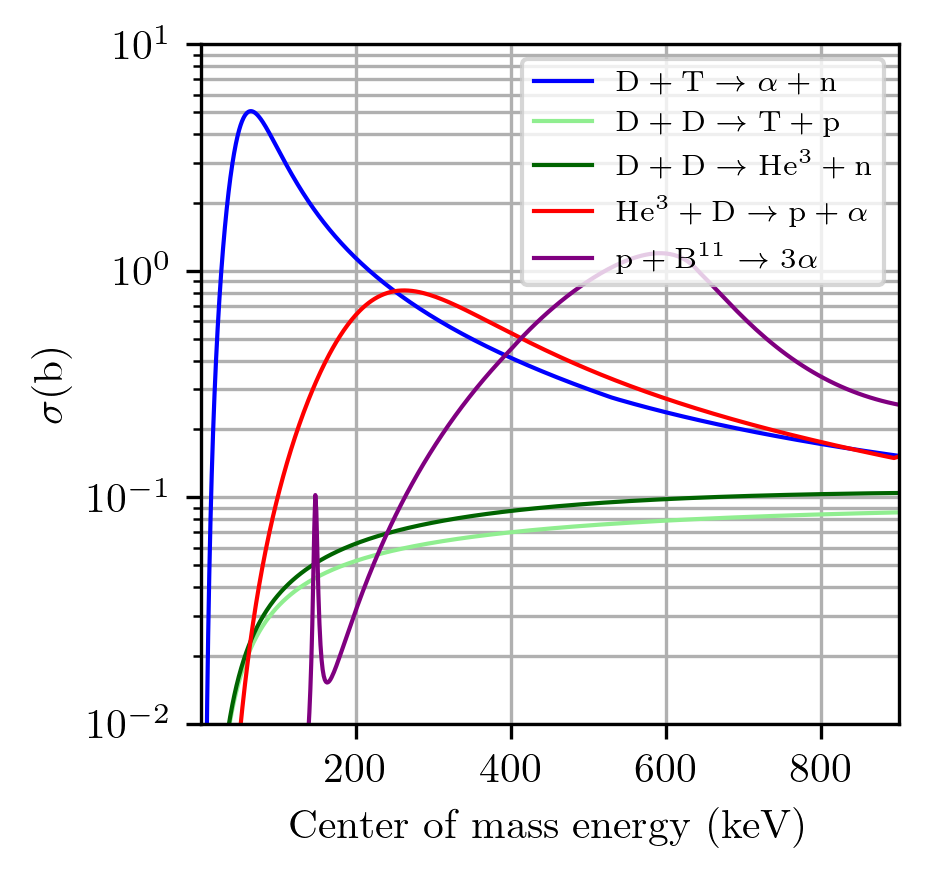

In [8]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

for reaction in reaction_legend_dict.keys():
    cross_section_df.plot(
        x="E",
        y=reaction,
        linewidth=1,
        color=reaction_color_dict[reaction],
        logx=False,
        logy=True,
        ax=ax,
    )
ax.set_xlim(1, 900)
ax.set_ylim(1e-2, 10)
ax.grid("on", which="both", axis="both")

ax.legend(reaction_legend_dict.values(), prop={"size": 7})

ax.set_xlabel(r"Center of mass energy ${\rm (keV)}$")
ax.set_ylabel(r"$\sigma {\rm (b)}$ ")
fig.savefig(os.path.join("images", "cross_section.png"), bbox_inches="tight")

### Calculate thermal reactivities

In [9]:
log_temperature_values = np.logspace(math.log10(0.2), math.log10(1000), 300)
sigma_v_df = pd.DataFrame(log_temperature_values, columns=["Temperature"])

# As stated in the text, reactivities for all reactions are obtained by
# integration except for p-11B which is obtained from the parameterization
# See reactivity.py for details.
for reaction in reaction_legend_dict.keys():
    sigma_v_df[reaction] = sigma_v_df.apply(
        lambda row: reactivity.reactivity(
            row["Temperature"],
            reaction=reaction,
            method="integrated",
        )
        if reaction != "11B(p,4He)4He4He"
        else reactivity.reactivity(
            row["Temperature"], reaction=reaction, method="parameterized"
        )
        if row["Temperature"] < 500
        else None,
        axis=1,
    )
sigma_v_df

/mnt/hdd/github/PlasmaPy/PlasmaPy/plasmapy/reaction_rates/reactivity.py:118: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(
/mnt/hdd/github/PlasmaPy/PlasmaPy/plasmapy/reaction_rates/reactivity.py:118: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(
/mnt/hdd/github/PlasmaPy/PlasmaPy/plasmapy/reaction_rates/reactivity.py:118: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(


,Temperature,"T(d,n)4He","D(d,p)T","D(d,n)3He","3He(d,p)4He","11B(p,4He)4He4He"
0,0.200000,3.020364e-35,1.544119e-37,2.261315e-37,8.563952e-42,8.792821e-56
1,0.205779,6.355461e-35,3.401195e-37,4.905585e-37,1.779097e-41,2.032501e-55
2,0.211725,1.308098e-34,7.318629e-37,1.040049e-36,3.616484e-41,4.659566e-55
3,0.217843,2.635167e-34,1.539432e-36,2.156406e-36,7.197805e-41,1.059510e-54
4,0.224138,5.198915e-34,3.167388e-36,4.375146e-36,1.403453e-40,2.389697e-54
...,...,...,...,...,...,...
295,892.309366,2.677377e-22,1.199204e-22,1.384144e-22,2.089645e-22,NaN
296,918.092815,2.638748e-22,1.213405e-22,1.398333e-22,2.068366e-22,NaN
297,944.621282,2.600877e-22,1.227162e-22,1.411980e-22,2.047095e-22,NaN
298,971.916294,2.563713e-22,1.240435e-22,1.425042e-22,2.025823e-22,NaN


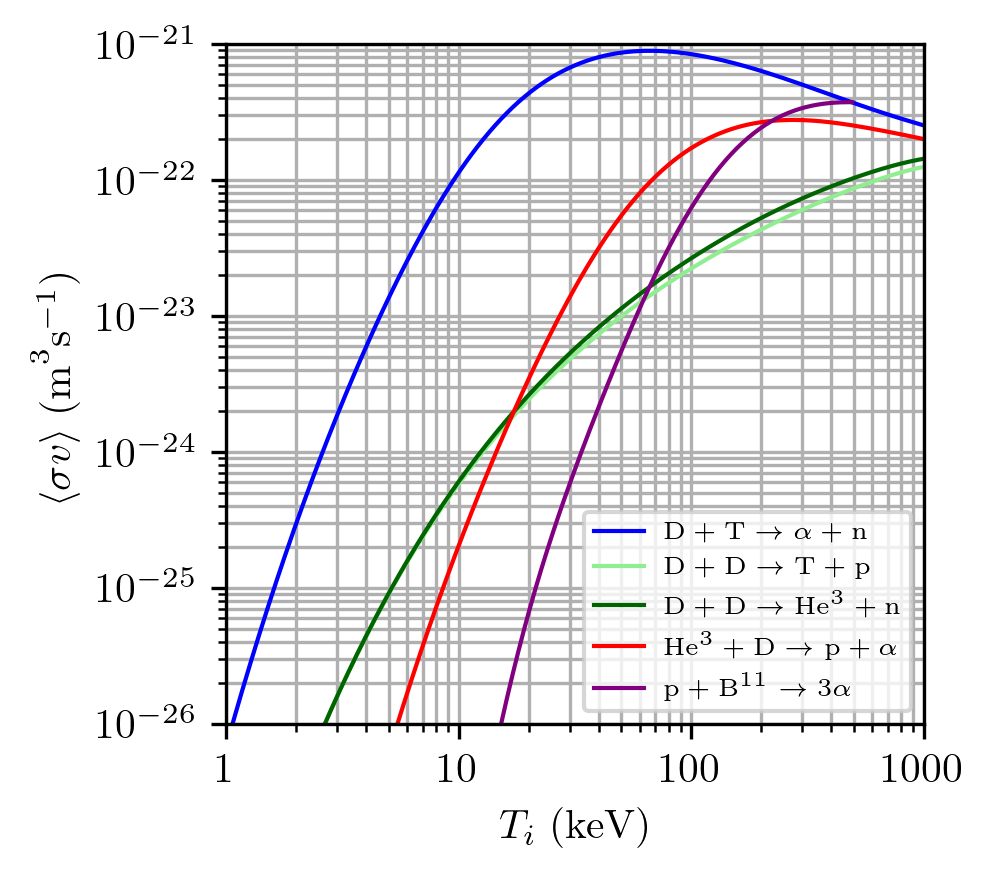

In [10]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)
for reaction in reaction_legend_dict.keys():
    sigma_v_df.plot(
        x="Temperature",
        y=reaction,
        linewidth=1,
        color=reaction_color_dict[reaction],
        logy=True,
        logx=True,
        ax=ax,
    )
ax.set_xlim(1, 1000)
ax.grid("on", which="both", axis="both")
ax.set_ylim(1e-26, 1e-21)
ax.legend(reaction_legend_dict.values(), prop={"size": 6}, loc="lower right")
ax.set_xlabel(r"$T_{i} \; \si{(keV)}$")
ax.set_ylabel(r"$\langle \sigma v \rangle \; \si{(\meter^{3} \second^{-1})}$ ")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:reactivities"]), bbox_inches="tight"
)

## Bremsstrahlung

### Relativistic bremsstrahlung (Ryder and Putvinski methods)

In [11]:
# Putvinski correction is only valid to 511 keV (electron rest mass)
log_temperature_values = np.logspace(math.log10(0.2), math.log10(511), 1000)
bremsstrahlung_correction_df = pd.DataFrame(
    log_temperature_values, columns=["Temperature"]
)

modes = ["ryder", "putvinski"]
Zeffs = [1, 2, 3]
for mode in modes:
    for Zeff in Zeffs:
        bremsstrahlung_correction_df[
            "Zeff=%s, mode=%s" % (Zeff, mode)
        ] = bremsstrahlung_correction_df.apply(
            lambda row: fusionlib.relativistic_bremsstrahlung_correction(
                T_e=row["Temperature"], Zeff=Zeff, relativistic_mode=mode
            ),
            axis=1,
        )
bremsstrahlung_correction_df

,Temperature,"Zeff=1, mode=ryder","Zeff=2, mode=ryder","Zeff=3, mode=ryder","Zeff=1, mode=putvinski","Zeff=2, mode=putvinski","Zeff=3, mode=putvinski"
0,0.200000,1.001141,2.001452,3.001763,1.000878,2.000927,3.000975
1,0.201577,1.001150,2.001464,3.001777,1.000886,2.000934,3.000983
2,0.203166,1.001159,2.001475,3.001791,1.000893,2.000942,3.000991
3,0.204768,1.001168,2.001487,3.001805,1.000900,2.000950,3.001000
4,0.206383,1.001178,2.001498,3.001819,1.000907,2.000957,3.001008
...,...,...,...,...,...,...,...
995,495.196645,5.584653,9.113590,12.642528,6.506304,9.212929,11.919554
996,499.101063,5.634786,9.197649,12.760511,6.555061,9.279741,12.004421
997,503.036266,5.685537,9.282813,12.880089,6.603939,9.346865,12.089792
998,507.002497,5.736912,9.369098,13.001284,6.652923,9.414289,12.175654


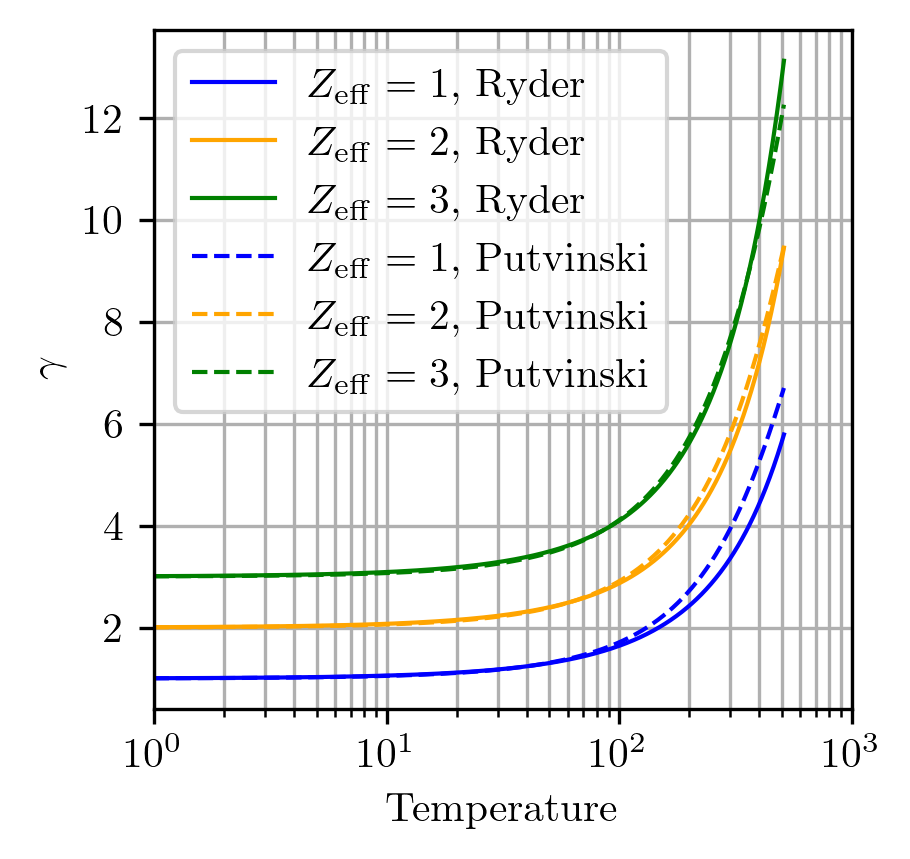

In [12]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {}
for mode in modes:
    for Zeff in Zeffs:
        legend_dict["Zeff=%s, mode=%s" % (Zeff, mode)] = r"$Z_{\rm eff}=%s$, %s" % (
            Zeff,
            mode.capitalize(),
        )

bremsstrahlung_correction_df.plot(
    x="Temperature",
    y=legend_dict.keys(),
    linewidth=1,
    logy=False,
    logx=True,
    style=[
        "-",
        "-",
        "-",
        "--",
        "--",
        "--",
    ],
    color=["blue", "orange", "green"],
    # xticks=[1,4.3,10,100],
    ax=ax,
)

# Must be after plot is called
# ax.set_xlabel(r'$T \; \si{(keV)}$')
ax.set_ylabel(r"$\gamma$")
ax.grid("on", which="both", axis="both")
ax.legend(legend_dict.values())
ax.set_xlim(1, 1000)
fig.savefig("images/relativistic_bremsstrahlung_correciton.png", bbox_inches="tight")

### Assume some fixed density and compare bremsstrahlung power density to D-T fusion power density

In [13]:
n = 1e20  # n = n_i = n_e in m^-3
# Create list of temperatures on log scale
log_temperature_values = np.logspace(math.log10(0.21), math.log10(100), 100)

# Import the reactivity coefficients from config file
config.read("config/reactions.ini")
reaction_info = config["T(d,n)4He"]

# Create dataframe with list of temperatures on log scale
relative_power_data = pd.DataFrame(log_temperature_values, columns=["Temperature"])

### D-T
dt_energy_per_reaction_total_keV = float(reaction_info["energy_per_reaction_total_keV"])
dt_fraction_charged = float(reaction_info["fraction_charged"])

# Factor of 1/4 since each reactant is 1/2 of total density
relative_power_data["DT reactivity"] = relative_power_data.apply(
    lambda row: reactivity.reactivity(row["Temperature"], "T(d,n)4He") / 1.0e-6,
    axis=1,
)

relative_power_data["DT Total"] = relative_power_data.apply(
    lambda row: (1.0 / 4.0)
    * n
    * n
    * reactivity.reactivity(row["Temperature"], "T(d,n)4He")
    * dt_energy_per_reaction_total_keV
    * 1000  # convert keV to Joules
    / 6.242e18,
    axis=1,
)

relative_power_data["DT Charged Watts"] = relative_power_data.apply(
    lambda row: row["DT Total"] * dt_fraction_charged,
    axis=1,
)

# Bremsstrahlung power density given a fixed electron density
relative_power_data["Bremsstrahlung"] = relative_power_data.apply(
    lambda row: fusionlib.power_density_bremsstrahlung(
        row["Temperature"], n, Zeff=1, return_units="W/m^3"
    ),
    axis=1,
)

relative_power_data

,Temperature,DT reactivity,DT Total,DT Charged Watts,Bremsstrahlung
0,0.210000,2.109467e-26,1.486968e-04,2.973935e-05,2449.042670
1,0.223495,4.045256e-26,2.851510e-04,5.703021e-05,2526.506948
2,0.237857,7.648875e-26,5.391710e-04,1.078342e-04,2606.421455
3,0.253142,1.426449e-25,1.005507e-03,2.011015e-04,2688.863692
4,0.269409,2.624514e-25,1.850026e-03,3.700052e-04,2773.913613
...,...,...,...,...,...
95,77.948335,8.865656e-16,6.249421e+06,1.249884e+06,47183.496921
96,82.957400,8.791539e-16,6.197176e+06,1.239435e+06,48675.931323
97,88.288354,8.695969e-16,6.129808e+06,1.225962e+06,50215.572070
98,93.961883,8.580725e-16,6.048572e+06,1.209714e+06,51803.912319


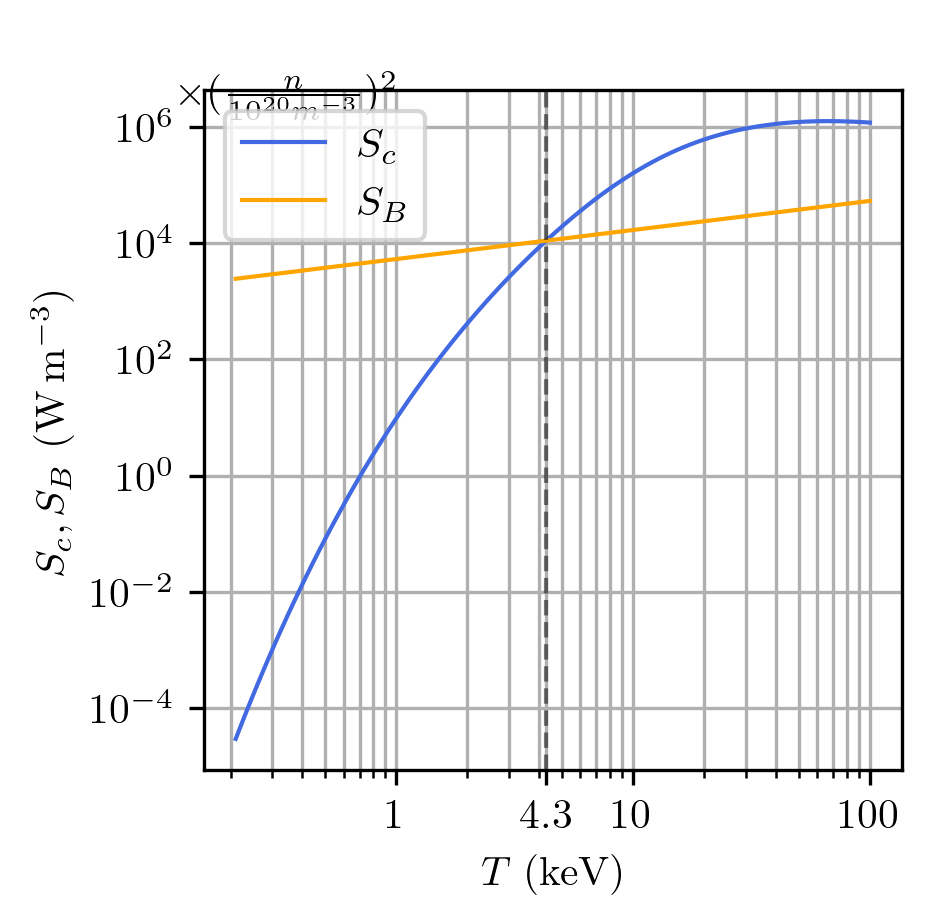

In [14]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "DT Charged Watts": r"$S_c$",
    "Bremsstrahlung": r"$S_B$",
}

relative_power_data.plot(
    x="Temperature",
    y=legend_dict.keys(),
    style=["royalblue", "orange"],
    linewidth=1,
    logy=True,
    logx=True,
    xticks=[1, 4.3, 10, 100],
    ax=ax,
)

ax.annotate(
    r"$\times (\frac{n}{10^{20}m^{-3}})^2$",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(0.2, 0.91),
)

# Must be after plot is called
ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$S_c, S_B ~\si{(W~m^{-3})}$")
ax.grid("on", which="both", axis="both")
ax.legend(legend_dict.values())
# ax.set_ylim(1e-5, 1e7)
ax.axvline(4.3, linewidth=1, linestyle="--", color="black", alpha=0.5)
ax.set_xticklabels([1, 4.3, 10, 100])
fig.savefig(
    os.path.join("images", label_filename_dict["fig:ideal_ignition"]),
    bbox_inches="tight",
)

## D-T reaction Recreate Lawson's 1955 Q vs T plot for various ntau values

In [15]:
# Create list of temperatures on log scale
log_temperature_values = np.logspace(math.log10(0.2), math.log10(100), 1000)

# Import the reactivity coefficients from config file
config.read("config/reactions.ini")
reaction_info = config["T(d,n)4He"]

# Create dataframe with list of temperatures on log scale
Q_vs_T = pd.DataFrame(log_temperature_values, columns=["Temperature"])

dt_energy_per_reaction_total_keV = float(reaction_info["energy_per_reaction_total_keV"])
dt_fraction_charged = float(reaction_info["fraction_charged"])
lawson_parameters = [1e19, 1e20, 1e21, float("inf")]  # m^-3 s
for lawson_parameter in lawson_parameters:
    Q_vs_T[f"ntau={lawson_parameter}"] = Q_vs_T.apply(
        lambda row: fusionlib.Q_vs_T_and_ntau(
            T=row["Temperature"], ntau=lawson_parameter
        ),
        axis=1,
    )
Q_vs_T

,Temperature,ntau=1e+19,ntau=1e+20,ntau=1e+21,ntau=inf
0,0.200000,8.972806e-10,7.365141e-09,2.638220e-08,3.699612e-08
1,0.201248,9.534007e-10,7.830042e-09,2.809236e-08,3.942952e-08
2,0.202504,1.012883e-09,8.323063e-09,2.990897e-08,4.201685e-08
3,0.203768,1.075919e-09,8.845827e-09,3.183835e-08,4.476745e-08
4,0.205039,1.142713e-09,9.400046e-09,3.388721e-08,4.769119e-08
...,...,...,...,...,...
995,97.542372,1.277067e-01,1.264275e+00,1.149164e+01,1.135923e+02
996,98.151058,1.267129e-01,1.254475e+00,1.140575e+01,1.130591e+02
997,98.763542,1.257241e-01,1.244725e+00,1.132026e+01,1.125259e+02
998,99.379848,1.247403e-01,1.235022e+00,1.123514e+01,1.119927e+02


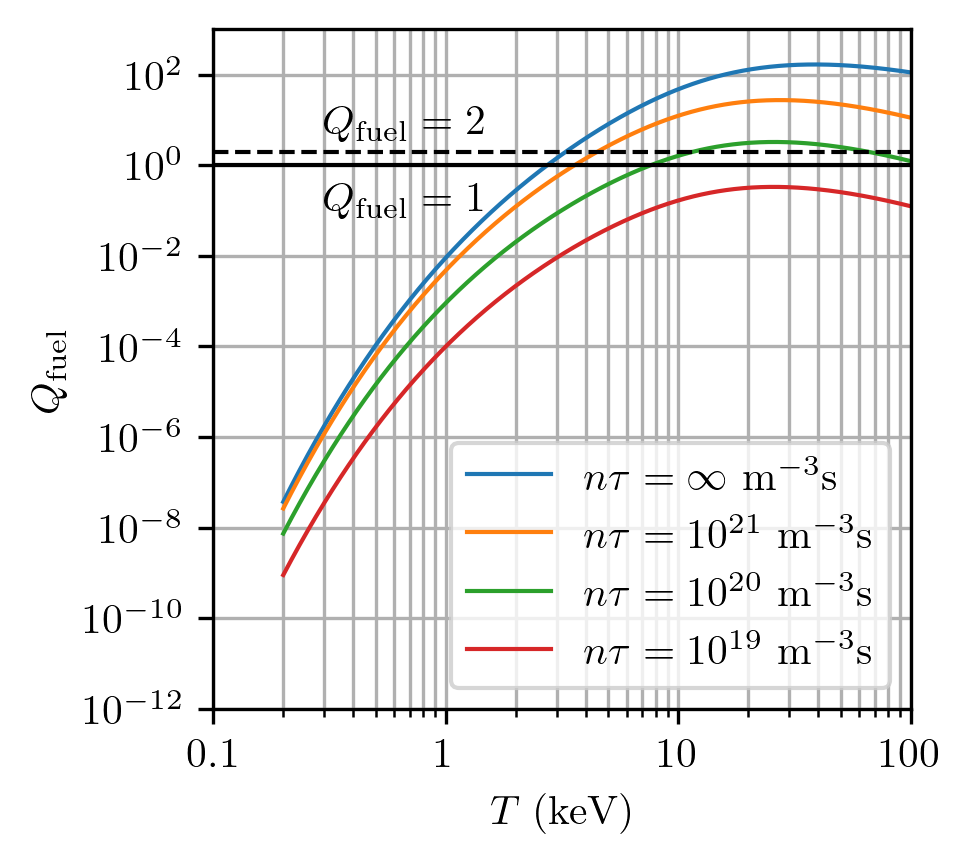

In [16]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "ntau=inf": r"$n\tau=\infty~\si{m^{-3}s}$",
    "ntau=1e+21": r"$n\tau=10^{21}~\si{m^{-3}s}$",
    "ntau=1e+20": r"$n\tau=10^{20}~\si{m^{-3}s}$",
    "ntau=1e+19": r"$n\tau=10^{19}~\si{m^{-3}s}$",
}

Q_vs_T.plot(
    x="Temperature", y=legend_dict.keys(), linewidth=1, logy=True, logx=True, ax=ax
)

# Must be after plot is called
ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$Q_{\rm fuel}$")
ax.grid("on", which="both", axis="both")
ax.legend(legend_dict.values())
ax.axhline(1, linewidth=1, linestyle="-", color="black", alpha=1)
ax.axhline(2, linewidth=1, linestyle="--", color="black", alpha=1)
ax.set_xlim(0.1, 100)
ax.set_ylim(1e-12, 1e3)
ax.annotate(r"$Q_{\rm fuel}=2$", xy=(1, 1), xycoords="data", xytext=(0.3, 5))
ax.annotate(r"$Q_{\rm fuel}=1$", xy=(1, 0.1), xycoords="data", xytext=(0.3, 0.1))
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", "Recreation_of_Lawson_Q_vs_T.png"), bbox_inches="tight"
)

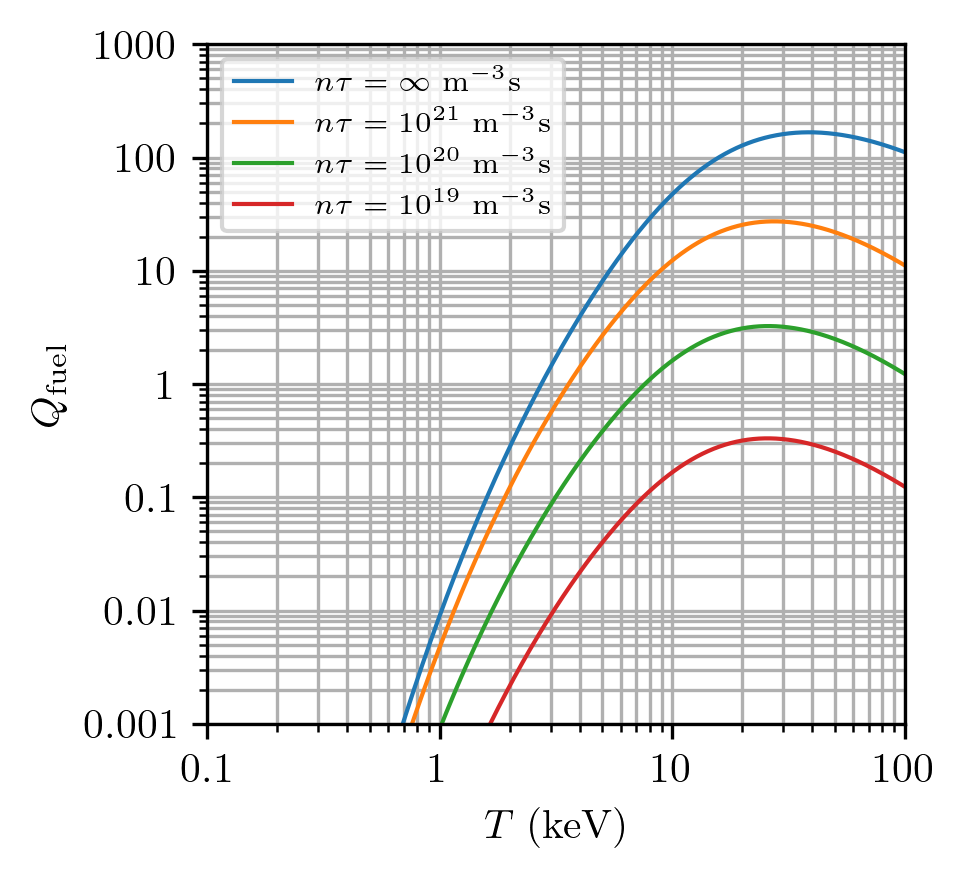

In [17]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "ntau=inf": r"$n\tau=\infty~\si{m^{-3}s}$",
    "ntau=1e+21": r"$n\tau=10^{21}~\si{m^{-3}s}$",
    "ntau=1e+20": r"$n\tau=10^{20}~\si{m^{-3}s}$",
    "ntau=1e+19": r"$n\tau=10^{19}~\si{m^{-3}s}$",
}

Q_vs_T.plot(
    x="Temperature",
    y=legend_dict.keys(),
    # style=['royalblue', 'orange'],
    linewidth=1,
    logy=True,
    logx=True,
    ax=ax,
)

# Must be after plot is called
ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$Q_{\rm fuel}$")
ax.grid("on", which="both", axis="both")
ax.legend(legend_dict.values(), prop={"size": 7})
# ax.axhline(1, linewidth=1, linestyle='-', color='black', alpha=1)
# ax.axhline(2, linewidth=1, linestyle='--', color='black', alpha=1)
ax.set_ylim(1e-3, 1e3)
ax.set_xlim(0.1, 100)

ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:Q_vs_T"]), bbox_inches="tight"
)

In [18]:
# Create list of temperatures on log scale
log_temperature_values = np.logspace(math.log10(0.21), math.log10(100), 10000)

# Import the reactivity coefficients from config file
config.read("reactions.ini")
reaction_info = config["T(d,n)4He"]

# Create dataframe with list of temperatures on log scale
Q_vs_T_extended = pd.DataFrame(log_temperature_values, columns=["Temperature"])

dt_energy_per_reaction_total_keV = float(reaction_info["energy_per_reaction_total_keV"])
dt_fraction_charged = float(reaction_info["fraction_charged"])
lawson_parameters = [1e19, 1e20, 1e21, float("inf")]  # m^-3 s
for lawson_parameter in lawson_parameters:
    Q_vs_T_extended[f"ntau={lawson_parameter}"] = Q_vs_T_extended.apply(
        lambda row: fusionlib.Q_vs_T_and_ntau_eff_generalized(
            T=row["Temperature"], ntau_eff=lawson_parameter
        ),
        axis=1,
    )
Q_vs_T_extended

,Temperature,ntau=1e+19,ntau=1e+20,ntau=1e+21,ntau=inf
0,0.210000,1.438387e-09,1.185668e-08,4.300640e-08,6.073575e-08
1,0.210130,1.446909e-09,1.192756e-08,4.327034e-08,6.111399e-08
2,0.210259,1.455480e-09,1.199885e-08,4.353583e-08,6.149450e-08
3,0.210389,1.464099e-09,1.207055e-08,4.380289e-08,6.187730e-08
4,0.210519,1.472768e-09,1.214265e-08,4.407152e-08,6.226239e-08
...,...,...,...,...,...
9995,99.753647,1.273101e-01,1.629877e+00,inf,inf
9996,99.815178,1.272081e-01,1.628196e+00,inf,inf
9997,99.876747,1.271062e-01,1.626517e+00,inf,inf
9998,99.938355,1.270044e-01,1.624840e+00,inf,inf


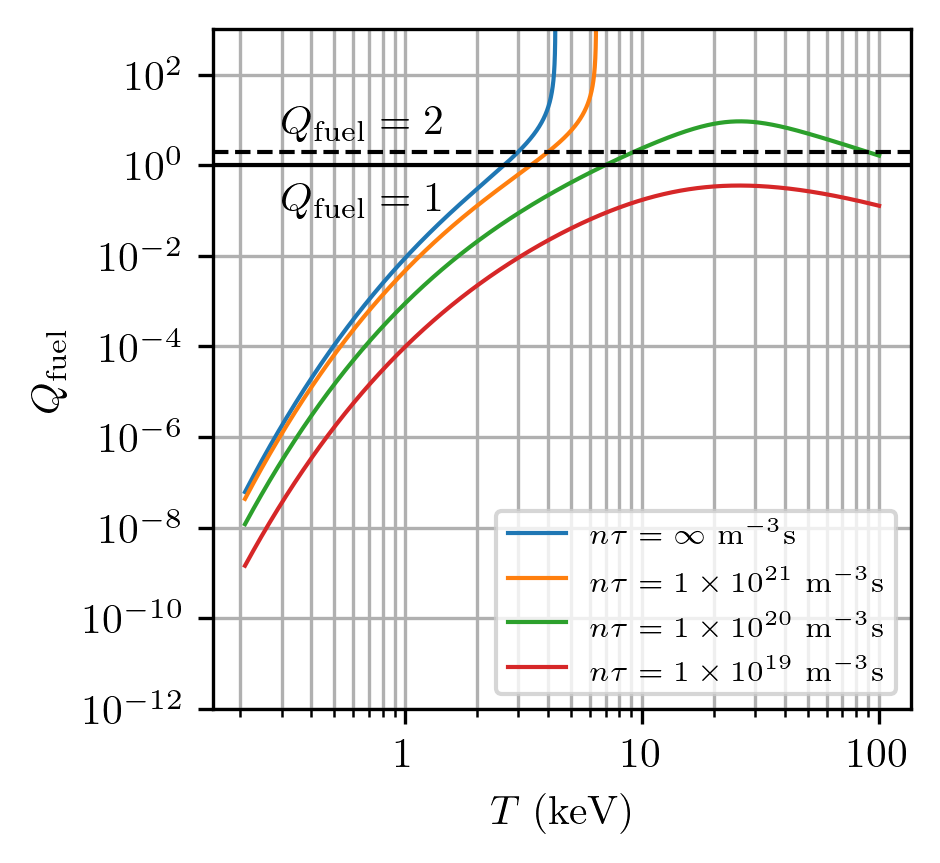

In [19]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "ntau=inf": r"$n\tau=\infty~\si{m^{-3}s}$",
    "ntau=1e+21": r"$n\tau=1\times10^{21}~\si{m^{-3}s}$",
    "ntau=1e+20": r"$n\tau=1\times10^{20}~\si{m^{-3}s}$",
    "ntau=1e+19": r"$n\tau=1\times10^{19}~\si{m^{-3}s}$",
}

Q_vs_T_extended.plot(
    x="Temperature",
    y=legend_dict.keys(),
    # style=['royalblue', 'orange'],
    linewidth=1,
    logy=True,
    logx=True,
    xticks=[1, 10, 100],
    ax=ax,
)

# Must be after plot is called
ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$Q_{\rm fuel}$")
ax.grid("on", which="both", axis="both")
ax.legend(legend_dict.values(), prop={"size": 7})

ax.axhline(1, linewidth=1, linestyle="-", color="black", alpha=1)
ax.axhline(2, linewidth=1, linestyle="--", color="black", alpha=1)
ax.set_xticklabels([1, 10, 100])
ax.set_ylim(1e-12, 1e3)

ax.annotate(
    r"$Q_{\rm fuel}=2$",
    xy=(1, 1),
    xycoords="data",
    xytext=(0.3, 5),
)
ax.annotate(
    r"$Q_{\rm fuel}=1$",
    xy=(1, 0.1),
    xycoords="data",
    xytext=(0.3, 0.1),
)
fig.savefig(os.path.join("images", "Q_vs_T_generalized.png"), bbox_inches="tight")

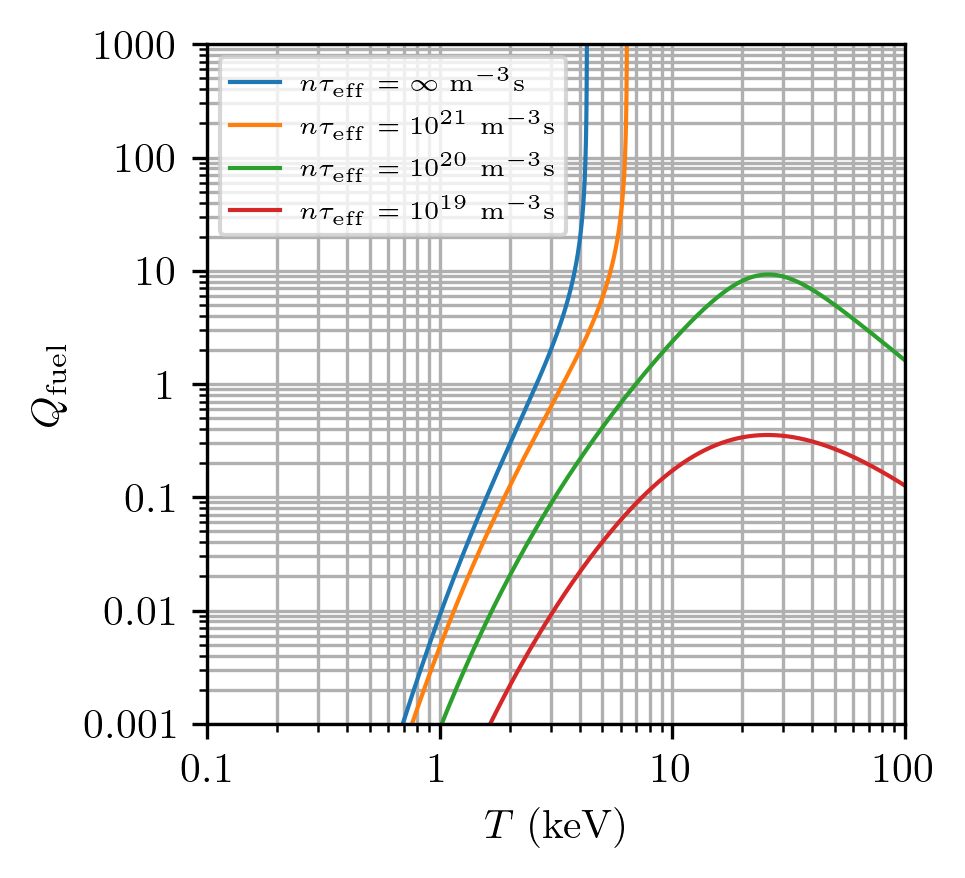

In [20]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "ntau=inf": r"$n\tau_{\rm eff}=\infty~\si{m^{-3}s}$",
    "ntau=1e+21": r"$n\tau_{\rm eff}=10^{21}~\si{m^{-3}s}$",
    "ntau=1e+20": r"$n\tau_{\rm eff}=10^{20}~\si{m^{-3}s}$",
    "ntau=1e+19": r"$n\tau_{\rm eff}=10^{19}~\si{m^{-3}s}$",
}

Q_vs_T_extended.plot(
    x="Temperature",
    y=legend_dict.keys(),
    # style=['royalblue', 'orange'],
    linewidth=1,
    logy=True,
    logx=True,
    xticks=[0.1, 1, 10, 100],
    yticks=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    ax=ax,
)

# Must be after plot is called
ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$Q_{\rm fuel}$")
ax.grid("on", which="both", axis="both")
ax.legend(legend_dict.values(), prop={"size": 6})
ax.set_xticklabels([0.1, 1, 10, 100])
ax.set_yticklabels([0.001, 0.01, 0.1, 1, 10, 100, 1000])
ax.set_xlim(0.1, 100)
ax.set_ylim(1e-3, 1e3)
fig.savefig(
    os.path.join("images", label_filename_dict["fig:Q_vs_T_extended"]),
    bbox_inches="tight",
)

## D-T reaction Lawson parameter and triple product for idealized MCF and ICF

### Idealized MCF and ICF: Calculate confinement parameter $n_e\tau_E$ vs $T$ for a range of $Q_{\rm fuel}$ and $Q_{\rm sci}$ for D-T

In [21]:
log_temperature_values = np.logspace(math.log10(0.5), math.log10(100), 300)
DT_lawson_parameter_df = pd.DataFrame(log_temperature_values, columns=["T"])

ideal_eta_ex = experiment.UniformProfileDTExperiment()
high_eta_ex = experiment.UniformProfileHighEtaDTExperiment()
low_eta_ex = experiment.UniformProfileLowEtaDTExperiment()

icf_ex = experiment.IndirectDriveICFDTExperiment()
icf_no_sh_ex = experiment.IndirectDriveICFDTNoSelfHeatingExperiment()

for ex in [ideal_eta_ex, high_eta_ex, low_eta_ex, icf_ex, icf_no_sh_ex]:
    for Q in [float("inf"), 100, 20, 10, 5, 2, 1, 0.5, 0.2, 0.1, 0.01, 0.001]:
        # Hack to correctly handle fuel gain correction and no Q_sci for ICF
        if ex.name in [
            "icf_indirect_drive_dt_experiment",
            "icf_indirect_drive_dt_no_sh_experiment",
        ]:
            DT_lawson_parameter_df[
                ex.name + "_Q_fuel=" + str(Q)
            ] = DT_lawson_parameter_df.apply(
                lambda row: ex.lawson_parameter_Q_fuel(
                    T_i0=row["T"], Q_fuel=Q / ex.eta_hs
                ),
                axis=1,
            )
        # For non, ICF evaluate Q_fuel and Q_sci
        else:
            DT_lawson_parameter_df[
                ex.name + "_Q_fuel=" + str(Q)
            ] = DT_lawson_parameter_df.apply(
                lambda row: ex.lawson_parameter_Q_fuel(T_i0=row["T"], Q_fuel=Q),
                axis=1,
            )
            DT_lawson_parameter_df[
                ex.name + "_Q_sci=" + str(Q)
            ] = DT_lawson_parameter_df.apply(
                lambda row: ex.lawson_parameter_Q_sci(T_i0=row["T"], Q_sci=Q),
                axis=1,
            )
DT_lawson_parameter_df

,T,uniform_profile_experiment_Q_fuel=inf,uniform_profile_experiment_Q_sci=inf,uniform_profile_experiment_Q_fuel=100,uniform_profile_experiment_Q_sci=100,uniform_profile_experiment_Q_fuel=20,uniform_profile_experiment_Q_sci=20,uniform_profile_experiment_Q_fuel=10,uniform_profile_experiment_Q_sci=10,uniform_profile_experiment_Q_fuel=5,uniform_profile_experiment_Q_sci=5,uniform_profile_experiment_Q_fuel=2,uniform_profile_experiment_Q_sci=2,uniform_profile_experiment_Q_fuel=1,uniform_profile_experiment_Q_sci=1,uniform_profile_experiment_Q_fuel=0.5,uniform_profile_experiment_Q_sci=0.5,uniform_profile_experiment_Q_fuel=0.2,uniform_profile_experiment_Q_sci=0.2,uniform_profile_experiment_Q_fuel=0.1,uniform_profile_experiment_Q_sci=0.1,uniform_profile_experiment_Q_fuel=0.01,uniform_profile_experiment_Q_sci=0.01,uniform_profile_experiment_Q_fuel=0.001,uniform_profile_experiment_Q_sci=0.001,uniform_profile_high_eta_experiment_Q_fuel=inf,uniform_profile_high_eta_experiment_Q_sci=inf,uniform_profile_high_eta_experiment_Q_fuel=100,uniform_profile_high_eta_experiment_Q_sci=100,uniform_profile_high_eta_experiment_Q_fuel=20,uniform_profile_high_eta_experiment_Q_sci=20,uniform_profile_high_eta_experiment_Q_fuel=10,uniform_profile_high_eta_experiment_Q_sci=10,uniform_profile_high_eta_experiment_Q_fuel=5,uniform_profile_high_eta_experiment_Q_sci=5,uniform_profile_high_eta_experiment_Q_fuel=2,uniform_profile_high_eta_experiment_Q_sci=2,uniform_profile_high_eta_experiment_Q_fuel=1,uniform_profile_high_eta_experiment_Q_sci=1,uniform_profile_high_eta_experiment_Q_fuel=0.5,uniform_profile_high_eta_experiment_Q_sci=0.5,uniform_profile_high_eta_experiment_Q_fuel=0.2,uniform_profile_high_eta_experiment_Q_sci=0.2,uniform_profile_high_eta_experiment_Q_fuel=0.1,uniform_profile_high_eta_experiment_Q_sci=0.1,uniform_profile_high_eta_experiment_Q_fuel=0.01,uniform_profile_high_eta_experiment_Q_sci=0.01,uniform_profile_high_eta_experiment_Q_fuel=0.001,uniform_profile_high_eta_experiment_Q_sci=0.001,uniform_profile_low_eta_experiment_Q_fuel=inf,uniform_profile_low_eta_experiment_Q_sci=inf,uniform_profile_low_eta_experiment_Q_fuel=100,uniform_profile_low_eta_experiment_Q_sci=100,uniform_profile_low_eta_experiment_Q_fuel=20,uniform_profile_low_eta_experiment_Q_sci=20,uniform_profile_low_eta_experiment_Q_fuel=10,uniform_profile_low_eta_experiment_Q_sci=10,uniform_profile_low_eta_experiment_Q_fuel=5,uniform_profile_low_eta_experiment_Q_sci=5,uniform_profile_low_eta_experiment_Q_fuel=2,uniform_profile_low_eta_experiment_Q_sci=2,uniform_profile_low_eta_experiment_Q_fuel=1,uniform_profile_low_eta_experiment_Q_sci=1,uniform_profile_low_eta_experiment_Q_fuel=0.5,uniform_profile_low_eta_experiment_Q_sci=0.5,uniform_profile_low_eta_experiment_Q_fuel=0.2,uniform_profile_low_eta_experiment_Q_sci=0.2,uniform_profile_low_eta_experiment_Q_fuel=0.1,uniform_profile_low_eta_experiment_Q_sci=0.1,uniform_profile_low_eta_experiment_Q_fuel=0.01,uniform_profile_low_eta_experiment_Q_sci=0.01,uniform_profile_low_eta_experiment_Q_fuel=0.001,uniform_profile_low_eta_experiment_Q_sci=0.001,icf_indirect_drive_dt_experiment_Q_fuel=inf,icf_indirect_drive_dt_experiment_Q_fuel=100,icf_indirect_drive_dt_experiment_Q_fuel=20,icf_indirect_drive_dt_experiment_Q_fuel=10,icf_indirect_drive_dt_experiment_Q_fuel=5,icf_indirect_drive_dt_experiment_Q_fuel=2,icf_indirect_drive_dt_experiment_Q_fuel=1,icf_indirect_drive_dt_experiment_Q_fuel=0.5,icf_indirect_drive_dt_experiment_Q_fuel=0.2,icf_indirect_drive_dt_experiment_Q_fuel=0.1,icf_indirect_drive_dt_experiment_Q_fuel=0.01,icf_indirect_drive_dt_experiment_Q_fuel=0.001,icf_indirect_drive_dt_no_sh_experiment_Q_fuel=inf,icf_indirect_drive_dt_no_sh_experiment_Q_fuel=100,icf_indirect_drive_dt_no_sh_experiment_Q_fuel=20,icf_indirect_drive_dt_no_sh_experiment_Q_fuel=10,icf_indirect_drive_dt_no_sh_experiment_Q_fuel=5,icf_indirect_drive_dt_no_sh_experiment_Q_fuel=2,icf_indirect_drive_dt_no_sh_experiment_Q_fuel=1,icf_indirect_drive_dt_no_sh_experiment_Q_fuel=0.5,icf_

### Plot MCF confinement parameter $n \tau_E$ vs $T$ for $\eta_{abs}=0.9$ for $Q_{\rm fuel}$ and $Q_{\rm sci}$

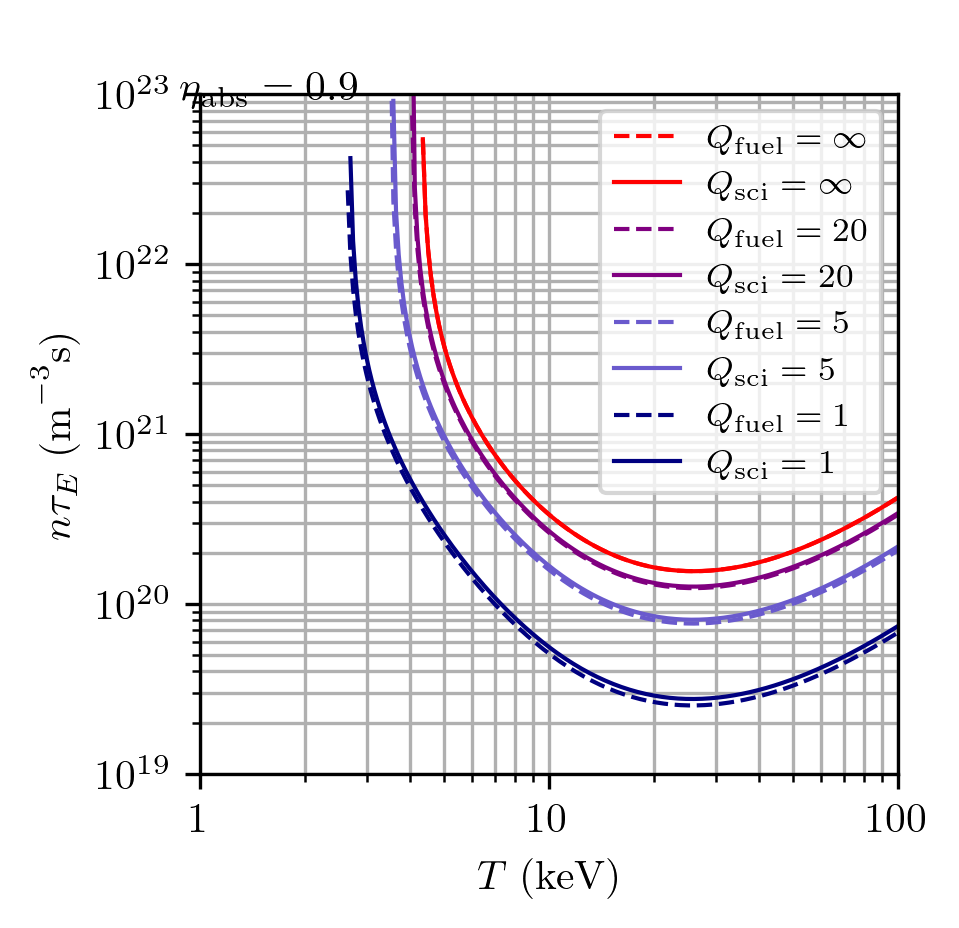

In [22]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "uniform_profile_experiment_Q_fuel=inf": r"$Q_{\rm fuel}=\infty$",
    "uniform_profile_high_eta_experiment_Q_sci=inf": r"$Q_{\rm sci}=\infty$",
    "uniform_profile_experiment_Q_fuel=20": r"$Q_{\rm fuel}=20$",
    "uniform_profile_high_eta_experiment_Q_sci=20": r"$Q_{\rm sci}=20$",
    "uniform_profile_experiment_Q_fuel=5": r"$Q_{\rm fuel}=5$",
    "uniform_profile_high_eta_experiment_Q_sci=5": r"$Q_{\rm sci}=5$",
    "uniform_profile_experiment_Q_fuel=1": r"$Q_{\rm fuel}=1$",
    "uniform_profile_high_eta_experiment_Q_sci=1": r"$Q_{\rm sci}=1$",
}
styles = ["--", "-", "--", "-", "--", "-", "--", "-"]
double_four_colors = [
    "red",
    "red",
    "purple",
    "purple",
    "slateblue",
    "slateblue",
    "navy",
    "navy",
]


DT_lawson_parameter_df.plot(
    x="T",
    y=legend_dict.keys(),
    linewidth=1,
    color=double_four_colors,
    style=styles,
    loglog=True,
    ax=ax,
)

ax.legend(legend_dict.values(), loc="upper right", prop={"size": 8})
ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n \tau_E \; \si{(m^{-3}s)}$")
ax.annotate(
    r"$\eta_{\rm abs}=0.9$",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(0.2, 0.92),
)

ax.grid("on", which="both", axis="both")
ax.set_xlim(1, 100)
ax.set_ylim(1e19, 1e23)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
fig.savefig(
    os.path.join("images", label_filename_dict["fig:MCF_ntau_contours_q_fuel_q_sci"]),
    bbox_inches="tight",
)

### Plot ICF confinement parameter $n \tau$ vs $T$ for $Q_{\rm fuel}$ and $Q_{\rm sci}$ with self heating

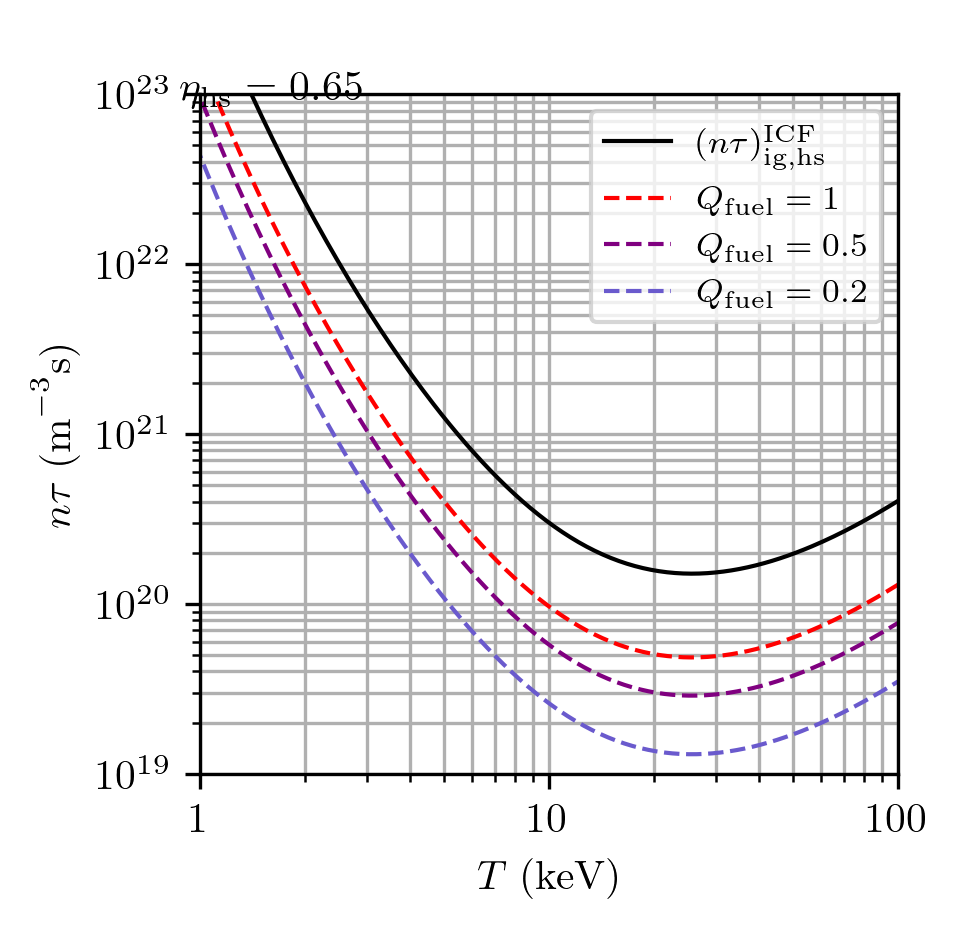

In [23]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "icf_indirect_drive_dt_experiment_Q_fuel=inf": r"$(n\tau)_{\rm ig, hs}^{\rm ICF}$",
    #'icf_indirect_drive_dt_experiment_Q_sci=inf': r'$Q_{\rm sci}=\infty$',
    #'icf_indirect_drive_dt_experiment_Q_fuel=20': r'$Q_{\rm fuel}=20$',
    #'icf_indirect_drive_dt_experiment_Q_sci=20': r'$Q_{\rm sci}=20$',
    #'icf_indirect_drive_dt_no_sh_experiment_Q_fuel=5': r'$Q_{\rm fuel}=5$',
    #'icf_indirect_drive_dt_experiment_Q_fuel=5': r'$Q_{\rm fuel}=5$',
    #'icf_indirect_drive_dt_no_sh_experiment_Q_fuel=2': r'$Q_{\rm fuel}=2$',
    #'icf_indirect_drive_dt_no_sh_experiment_Q_fuel=1': r'$Q_{\rm fuel}^{\rm no (\alpha)}=1$',
    #'icf_indirect_drive_dt_no_sh_experiment_Q_fuel=0.5': r'$Q_{\rm fuel}^{\rm no (\alpha)}=0.5$',
    #'icf_indirect_drive_dt_no_sh_experiment_Q_fuel=0.2': r'$Q_{\rm fuel}^{\rm no (\alpha)}=0.2$',
    "icf_indirect_drive_dt_experiment_Q_fuel=1": r"$Q_{\rm fuel}=1$",
    "icf_indirect_drive_dt_experiment_Q_fuel=0.5": r"$Q_{\rm fuel}=0.5$",
    "icf_indirect_drive_dt_experiment_Q_fuel=0.2": r"$Q_{\rm fuel}=0.2$",
}

styles = ["-", "--", "--", "--"]
double_four_colors = ["black", "red", "purple", "slateblue", "navy"]

DT_lawson_parameter_df.plot(
    x="T",
    y=legend_dict.keys(),
    linewidth=1,
    color=double_four_colors,
    # color=['black', 'red', 'red'],
    style=styles,
    loglog=True,
    ax=ax,
)
ax.legend(legend_dict.values(), loc="upper right", prop={"size": 8})
ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n \tau \; \si{(m^{-3}s)}$")
ax.annotate(
    r"$\eta_{\rm hs}=0.65$",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(0.2, 0.92),
)
# ax.annotate(r'$\eta_{\rm abs}=0.0087 \quad \eta_{\rm hs}=0.65$', xy=(0, 0),  xycoords='figure fraction',
#            xytext=(0.2, 0.92),
#            )
# ax.annotate(f'$\\eta_{{\\rm abs}}={icf_ex.eta_abs}$', xy=(0, 0),  xycoords='figure fraction',
#            xytext=(0.2, 0.92),
#            )

ax.grid("on", which="both", axis="both")
ax.set_xlim(1, 100)
ax.set_ylim(1e19, 1e23)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
fig.savefig(
    os.path.join("images", label_filename_dict["fig:ICF_ntau_contours_q_fuel_q_sci"]),
    bbox_inches="tight",
)

### Calculate triple product $n T \tau_E$ vs $T$ for a range of $Q_{\rm fuel}$ for D-T

In [24]:
log_temperature_values = np.logspace(math.log10(0.5), math.log10(100), 300)
DT_triple_product_df = pd.DataFrame(log_temperature_values, columns=["T_i0"])

ideal_eta_ex = experiment.UniformProfileDTExperiment()
high_eta_ex = experiment.UniformProfileHighEtaDTExperiment()
low_eta_ex = experiment.UniformProfileLowEtaDTExperiment()

for ex in [ideal_eta_ex, high_eta_ex, low_eta_ex]:
    for Q in [float("inf"), 20, 5, 1]:
        if ex.name == "uniform_profile_experiment":
            DT_triple_product_df[
                ex.name + "_Q_fuel=" + str(Q)
            ] = DT_triple_product_df.apply(
                lambda row: ex.triple_product_Q_fuel(T_i0=row["T_i0"], Q_fuel=Q),
                axis=1,
            )
        else:
            DT_triple_product_df[
                ex.name + "_Q_sci=" + str(Q)
            ] = DT_triple_product_df.apply(
                lambda row: ex.triple_product_Q_sci(T_i0=row["T_i0"], Q_sci=Q),
                axis=1,
            )
DT_triple_product_df

,T_i0,uniform_profile_experiment_Q_fuel=inf,uniform_profile_experiment_Q_fuel=20,uniform_profile_experiment_Q_fuel=5,uniform_profile_experiment_Q_fuel=1,uniform_profile_high_eta_experiment_Q_sci=inf,uniform_profile_high_eta_experiment_Q_sci=20,uniform_profile_high_eta_experiment_Q_sci=5,uniform_profile_high_eta_experiment_Q_sci=1,uniform_profile_low_eta_experiment_Q_sci=inf,uniform_profile_low_eta_experiment_Q_sci=20,uniform_profile_low_eta_experiment_Q_sci=5,uniform_profile_low_eta_experiment_Q_sci=1
0,0.500000,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,0.508939,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,0.518038,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,0.527299,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,0.536726,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,93.157321,3.593919e+22,2.849811e+22,1.757906e+22,5.776001e+21,3.593919e+22,2.910063e+22,1.852547e+22,6.305185e+21,3.593919e+22,3.547604e+22,3.415554e+22,2.849811e+22
296,94.822793,3.741155e+22,2.966205e+22,1.829381e+22,6.009700e+21,3.741155e+22,3.028947e+22,1.927899e+22,6.560351e+21,3.741155e+22,3.692914e+22,3.555379e+22,2.966205e+22
297,96.518040,3.895201e+22,3.087960e+22,1.904126e+22,6.254020e+21,3.895201e+22,3.153309e+22,2.006701e+22,6.827117e+21,3.895201e+22,3.844945e+22,3.701667e+22,3.087960e+22
298,98.243595,4.056392e+22,3.215336e+22,1.982300e+22,6.509466e+21,4.056392e+22,3.283415e+22,2.089120e+22,7.106036e+21,4.056392e+22,4.004024e+22,3.854731e+22,3.215336e+22


### Plot optimal triple product $n_i T_i \tau_E$ vs $T$

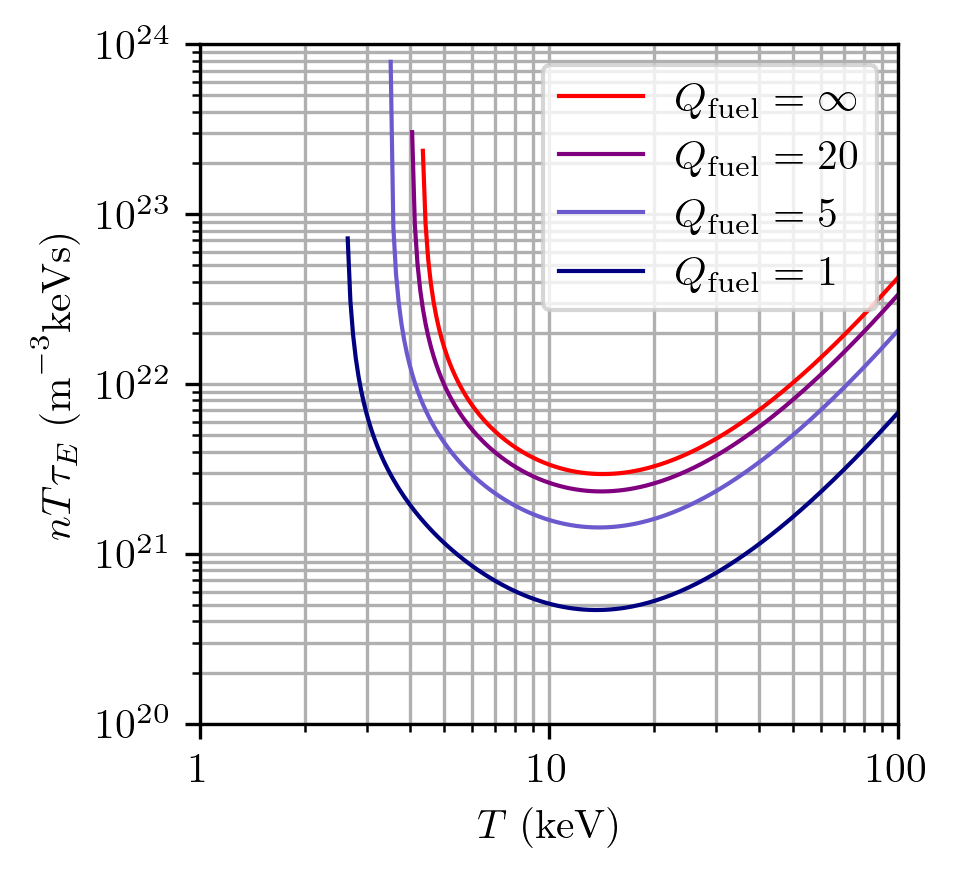

In [25]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "uniform_profile_experiment_Q_fuel=inf": r"$Q_{\rm fuel}=\infty$",
    "uniform_profile_experiment_Q_fuel=20": r"$Q_{\rm fuel}=20$",
    "uniform_profile_experiment_Q_fuel=5": r"$Q_{\rm fuel}=5$",
    "uniform_profile_experiment_Q_fuel=1": r"$Q_{\rm fuel}=1$",
}

DT_triple_product_df.plot(
    x="T_i0", y=legend_dict.keys(), linewidth=1, color=four_colors, loglog=True, ax=ax
)
ax.legend(legend_dict.values(), loc="upper right")
ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n T \tau_E \; \si{(m^{-3} keV s)}$")
ax.grid("on", which="both", axis="both")
ax.set_xlim(1, 100)
ax.set_ylim(1e20, 1e24)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
fig.savefig(
    os.path.join("images", label_filename_dict["fig:MCF_nTtau_contours_q_fuel"]),
    bbox_inches="tight",
)

## Catalyzed D-D reactions

In [ ]:
# Only go to 511 keV since that's the limit of validity of the relativistic bremsstrahlung correction
log_temperature_values = np.logspace(math.log10(0.2), math.log10(511), 300)

density = "ion"
relativistic_mode = "putvinski"

catalyzed_DD_df = pd.DataFrame(log_temperature_values, columns=["Temperature"])
for Q_fuel in [float("inf"), 20, 5, 1]:
    catalyzed_DD_df[f"LP Q_fuel={Q_fuel}"] = catalyzed_DD_df.apply(
        lambda row: fusionlib.catalyzed_DD_lawson_parameter(
            T_i=row["Temperature"],
            Q_fuel=Q_fuel,
            density=density,
            relativistic_mode=relativistic_mode,
        ),
        axis=1,
    )

    catalyzed_DD_df[f"TP Q_fuel={Q_fuel}"] = catalyzed_DD_df.apply(
        lambda row: fusionlib.catalyzed_DD_triple_product(
            T_i=row["Temperature"],
            Q_fuel=Q_fuel,
            density=density,
            relativistic_mode=relativistic_mode,
        ),
        axis=1,
    )
    print(f"Q_fuel={Q_fuel} done")

catalyzed_DD_df

/mnt/hdd/github/PlasmaPy/PlasmaPy/plasmapy/reaction_rates/reactivity.py:118: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(
/mnt/hdd/github/PlasmaPy/PlasmaPy/plasmapy/reaction_rates/reactivity.py:118: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(


Q_fuel=inf done

/mnt/hdd/github/PlasmaPy/PlasmaPy/plasmapy/reaction_rates/reactivity.py:118: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(
/mnt/hdd/github/PlasmaPy/PlasmaPy/plasmapy/reaction_rates/reactivity.py:118: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(


Q_fuel=20 done

/mnt/hdd/github/PlasmaPy/PlasmaPy/plasmapy/reaction_rates/reactivity.py:118: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(
/mnt/hdd/github/PlasmaPy/PlasmaPy/plasmapy/reaction_rates/reactivity.py:118: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(


Q_fuel=5 done

/mnt/hdd/github/PlasmaPy/PlasmaPy/plasmapy/reaction_rates/reactivity.py:118: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(


In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)
four_colors = ["red", "purple", "slateblue", "navy"]

legend_dict = {
    "LP Q_fuel=inf": r"$Q_{\rm fuel}=\infty$",
    "LP Q_fuel=20": r"$Q_{\rm fuel}=20$",
    "LP Q_fuel=5": r"$Q_{\rm fuel}=5$",
    "LP Q_fuel=1": r"$Q_{\rm fuel}=1$",
}

catalyzed_DD_df.plot(
    x="Temperature",
    y=legend_dict.keys(),
    linewidth=1,
    color=four_colors,
    logy=True,
    logx=True,
    ax=ax,
)

ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n_i \tau_E \; \si{(m^{-3}.s)}$")
ax.grid("on", which="both", axis="both")
# ax.set_title('Catalyzed D-D')
ax.legend(legend_dict.values(), prop={"size": 8})

ax.set_xlim(1, 1000)
ax.set_ylim(1e20, 1e22)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
fig.savefig(
    os.path.join("images", label_filename_dict["fig:CAT_D-D_a"]), bbox_inches="tight"
)

In [ ]:
four_colors = ["red", "purple", "slateblue", "navy"]

legend_dict = {
    "TP Q_fuel=inf": r"$Q_{\rm fuel}=\infty$",
    "TP Q_fuel=20": r"$Q_{\rm fuel}=20$",
    "TP Q_fuel=5": r"$Q_{\rm fuel}=5$",
    "TP Q_fuel=1": r"$Q_{\rm fuel}=1$",
}

fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)
print(legend_dict.keys())
catalyzed_DD_df.plot(
    x="Temperature",
    y=legend_dict.keys(),
    linewidth=1,
    color=four_colors,
    logy=True,
    logx=True,
    ax=ax,
)

ax.set_xlim(1, 1000)
ax.set_ylim(1e22, 1e24)
ax.grid("on", which="both", axis="both")
# ax.set_title('Catalyzed D-D')
ax.legend(legend_dict.values(), prop={"size": 8})
ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n_i T \tau_E \; \si{(m^{-3}.keV.s)}$")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
fig.savefig(
    os.path.join("images", label_filename_dict["fig:CAT_D-D_b"]), bbox_inches="tight"
)

## D-3He reaction

In [ ]:
# Only go to 511 keV since that's the limit of validity of the relativistic bremsstrahlung correction
log_temperature_values = np.logspace(math.log10(0.2), math.log10(511), 300)

D_3He_df = pd.DataFrame(log_temperature_values, columns=["Temperature"])

for Q_fuel in [float("inf"), 20, 5, 1]:
    D_3He_df[f"LP Q_fuel={Q_fuel}"] = D_3He_df.apply(
        lambda row: fusionlib.optimal_mix_lawson_parameter(
            row["Temperature"],
            "3He(d,p)4He",
            Q_fuel,
            density="ion",
            relativistic_mode="putvinski",
        ),
        axis=1,
    )
    D_3He_df[f"TP Q_fuel={Q_fuel}"] = D_3He_df.apply(
        lambda row: fusionlib.optimal_mix_triple_product(
            row["Temperature"],
            "3He(d,p)4He",
            Q_fuel,
            density="ion",
            relativistic_mode="putvinski",
        ),
        axis=1,
    )
    print(f"Q_fuel={Q_fuel} done")

D_3He_df

In [ ]:
four_colors = ["red", "purple", "slateblue", "navy"]
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "LP Q_fuel=inf": r"$Q_{\rm fuel}=\infty$",
    "LP Q_fuel=20": r"$Q_{\rm fuel}=20$",
    "LP Q_fuel=5": r"$Q_{\rm fuel}=5$",
    "LP Q_fuel=1": r"$Q_{\rm fuel}=1$",
}

D_3He_df.plot(
    x="Temperature",
    y=legend_dict.keys(),
    linewidth=1,
    color=four_colors,
    logx=True,
    logy=True,
    ax=ax,
)

ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n_i \tau_E^* \; \si{(m^{-3}.s)}$")
ax.grid("on", which="both", axis="both")
# ax.set_title('D-$^3$He')
ax.legend(legend_dict.values(), loc="lower left")

ax.set_xlim(1, 1000)
ax.set_ylim(1e20, 1e22)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:D-3He_a"]), bbox_inches="tight"
)

In [ ]:
four_colors = ["red", "purple", "slateblue", "navy"]
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "TP Q_fuel=inf": r"$Q_{\rm fuel}=\infty$",
    "TP Q_fuel=20": r"$Q_{\rm fuel}=20$",
    "TP Q_fuel=5": r"$Q_{\rm fuel}=5$",
    "TP Q_fuel=1": r"$Q_{\rm fuel}=1$",
    #'TP Q_fuel=0.5': r'$Q_{\rm fuel}=0.5$',
    #'TP Q_fuel=0.1': r'$Q_{\rm fuel}=0.1$',
    #'TP Q_fuel=0.05': r'$Q_{\rm fuel}=0.05$',
}

D_3He_df.plot(
    x="Temperature",
    y=legend_dict.keys(),
    linewidth=1,
    color=four_colors,
    logx=True,
    logy=True,
    ax=ax,
)

ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n_i T \tau_E^* \; \si{(m^{-3}.keV.s)}$")
ax.grid("on", which="both", axis="both")
# ax.set_title('D-$^3$He')
ax.legend(legend_dict.values(), loc="lower left")

ax.set_xlim(1, 1000)
ax.set_ylim(1e22, 1e24)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:D-3He_b"]), bbox_inches="tight"
)

## p-11B reaction

In [ ]:
# Only go to 500 keV since that's the limit of validity of the parameterized reactivity
log_temperature_values = np.logspace(math.log10(0.5), math.log10(500), 300)
p_B11_df = pd.DataFrame(log_temperature_values, columns=["Temperature"])

xis = [1, 0.333, 0.1]

for Q_fuel in [float("inf"), 20, 5, 3, 1, 0.8, 0.5, 0.1]:
    for xi in xis:
        p_B11_df[f"TP xi={xi} Q_fuel={Q_fuel}"] = p_B11_df.apply(
            lambda row: fusionlib.optimal_mix_triple_product(
                row["Temperature"],
                "11B(p,4He)4He4He",
                Q_fuel,
                xi=xi,
                density="ion",
                relativistic_mode="putvinski",
                method="parameterized",
            ),
            axis=1,
        )
        p_B11_df[f"LP xi={xi} Q_fuel={Q_fuel}"] = p_B11_df.apply(
            lambda row: fusionlib.optimal_mix_lawson_parameter(
                row["Temperature"],
                "11B(p,4He)4He4He",
                Q_fuel,
                xi=xi,
                density="ion",
                relativistic_mode="putvinski",
                method="parameterized",
            ),
            axis=1,
        )
p_B11_df

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "LP xi=1 Q_fuel=0.5": r"$Q_{\rm fuel}=0.5$",
    "LP xi=1 Q_fuel=0.1": r"$Q_{\rm fuel}=0.1$",
}

p_B11_df.plot(
    x="Temperature",
    y=legend_dict.keys(),
    linewidth=1,
    style=["-"],
    color=["slateblue", "navy", "darkred", "red"],
    logx=True,
    logy=True,
    ax=ax,
)

ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n_i \tau_E \; \si{(m^{-3}.s)}$")
ax.grid("on", which="both", axis="both")
# ax.set_title(r'p-$^{11}$B,$ ~ \xi=%s$' % xi)
ax.legend(legend_dict.values(), loc="upper left")

ax.set_xlim(1, 1000)
ax.set_ylim(1e20, 1e23)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:pB11_a"]), bbox_inches="tight"
)

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {  #'TP xi=0.333 Q_fuel=1': r'$Q_{\rm fuel}=1, T_e=T_i/3$',
    #'TP xi=0.333 Q_fuel=5': r'$Q_{\rm fuel}=5, T_e=T_i/3$',
    #'TP xi=0.333 Q_fuel=20': r'$Q_{\rm fuel}=20, T_e=T_i/3$',
    #'TP xi=0.333 Q_fuel=inf': r'$Q_{\rm fuel}=\infty, T_e=T_i/3$',
    "TP xi=1 Q_fuel=0.5": r"$Q_{\rm fuel}=0.5$",
    "TP xi=1 Q_fuel=0.1": r"$Q_{\rm fuel}=0.1$",
}

p_B11_df.plot(
    x="Temperature",
    y=legend_dict.keys(),
    linewidth=1,
    style=["-"],
    color=["slateblue", "navy", "darkred", "red"],
    logx=True,
    logy=True,
    ax=ax,
)

ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n_i T \tau_E \; \si{(m^{-3}.keV.s)}$")
ax.grid("on", which="both", axis="both")
# ax.set_title(r'p-$^{11}$B,$ ~ \xi=%s$' % xi)
ax.legend(legend_dict.values(), loc="upper left")

ax.set_xlim(1, 1000)
ax.set_ylim(1e22, 1e25)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:pB11_b"]), bbox_inches="tight"
)

### Charged fusion power density vs bremsstrahlung power density

In [ ]:
# Create list of temperatures on log scale
log_temperature_values = np.logspace(math.log10(0.5), math.log10(500), 2000)

# Import the reactivity coefficients from config file
config.read("reactions.ini")
reaction_info = config["11B(p,4He)4He4He"]

# Create dataframe with list of temperatures on log scale
relative_power_df = pd.DataFrame(log_temperature_values, columns=["Temperature"])

### p-11B
p11B_energy_per_reaction_total_keV = reaction_info.getfloat(
    "energy_per_reaction_total_keV"
)
p11B_fraction_charged = reaction_info.getfloat("fraction_charged")

# Zeff = sum((Zj^2 nj)/ne)
# for p-11B, this evaluates to 3 when assuming max fusion power and
# relative density k_p = 1/2 and k_B = 1/10 are assumed
p11B_Zeff = 3  # In optimal case

# We want to calculate charged Fusion power density per electron number density squared:
# F_c / ne^2 = k1 k2 ne^2 <σv> E_charged / ne^2
# and
# Bremsstrahlung power density per electron number density squared
# F_B / ne^2 = Cb * Zeff * ne^2 / ne^2

# Assume optimal reactant mix at constant n_e^2
# Factor of 1/20 is because optimal relative densities are
# Protons:
# kp = np/ne = 1/(2*Zp) = 1/2
# Boron 11 ions:
# k11B = n11B/ne = 1/(2*Z11B) = 1/10
# so kp*k11B= 1/20

reaction = "11B(p,4He)4He4He"

# Charged fusion power density per ne^2
relative_power_df["Charged Power"] = relative_power_df.apply(
    lambda row: (1 / 20)
    * p11B_fraction_charged
    * reactivity.reactivity(row["Temperature"], reaction)
    * p11B_energy_per_reaction_total_keV,
    axis=1,
)

# Bremsstrahlung power density per ne^2
relative_power_df["Bremsstrahlung"] = relative_power_df.apply(
    lambda row: fusionlib.power_density_bremsstrahlung(
        T_e=row["Temperature"], n_e=1, Zeff=p11B_Zeff, relativistic_mode="putvinski"
    ),
    axis=1,
)

# Bremsstrahlung power density per ne^2 when Te = (1/2) Ti
relative_power_df["Bremsstrahlung Te=Ti/2"] = relative_power_df.apply(
    lambda row: fusionlib.power_density_bremsstrahlung(
        T_e=0.5 * row["Temperature"],
        n_e=1,
        Zeff=p11B_Zeff,
        relativistic_mode="putvinski",
    ),
    axis=1,
)

# Bremsstrahlung power density per ne^2 when Te = (1/100) Ti
relative_power_df["Bremsstrahlung Te=Ti/10"] = relative_power_df.apply(
    lambda row: fusionlib.power_density_bremsstrahlung(
        T_e=0.1 * row["Temperature"],
        n_e=1,
        Zeff=p11B_Zeff,
        relativistic_mode="putvinski",
    ),
    axis=1,
)

relative_power_df["P_c/P_b"] = relative_power_df.apply(
    lambda row: row["Charged Power"] / row["Bremsstrahlung"],
    axis=1,
)

relative_power_df

In [ ]:
fig, ax = plt.subplots(dpi=200)
fig.set_size_inches(3, 3)

legend_dict = {
    "P_c/P_b": "$P_{c}/P_{b}$",
}
# legend_dict = {'Charged Power':'$P_{c}/n^{2}$',
#               'Bremsstrahlung': r'$P_{B}/n^{2}, ~ T_e = T_i$',
#               'Bremsstrahlung Te=Ti/2': r'$P_{B}/n^{2}, ~ T_e = T_i/2$',
#               'Bremsstrahlung Te=Ti/10': r'$P_{B}/n^{2}, ~ T_e = T_i/10$',
#              }

relative_power_df.plot(
    x="Temperature",
    y=legend_dict.keys(),
    style=["purple", "red", "orange", "green"],
    linewidth=1,
    logx=True,
    ax=ax,
)

# Must be after plot is called
ax.legend(legend_dict.values(), prop={"size": 7})

ax.set_xlabel(r"$T \; \si{(keV)}$")
# ax.set_ylabel(r'$\si{(keV s^{-1} m^{3})}$ ')
ax.grid("on", which="both", axis="both")
# ax.legend(['$P_{c}$', '$P_{B}$'])
ax.set_xlim(1, 1000)
# ax.set_ylim(0, 0.2e-17)
# ax.set_ylim(1e-25, 1e-17)
# ax.axvline(4.3, linewidth=1, linestyle='--', color='black', alpha=0.5)
# ax.set_xticklabels([1,4.3,10,100])
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig("images/pB11_fusion_vs_bremsstrahlung.png", bbox_inches="tight")

### Assume some fixed electron density and use watts

In [ ]:
n_e = 1e20  # n = n_e in m^-3
# Only go to 511 keV since that's the limit of validity of the relativistic bremsstrahlung correction
# Create list of temperatures on log scale
log_temperature_values = np.logspace(math.log10(0.5), math.log10(500), 2000)

# Import the reactivity coefficients from config file
config.read("reactions.ini")
reaction_info = config["11B(p,4He)4He4He"]

# Create dataframe with list of temperatures on log scale
relative_power_df = pd.DataFrame(log_temperature_values, columns=["Temperature"])

### p-11B
p11B_energy_per_reaction_total_keV = reaction_info.getfloat(
    "energy_per_reaction_total_keV"
)
p11B_fraction_charged = reaction_info.getfloat("fraction_charged")

# Zeff = sum((Zj^2 nj)/ne)
# for p-11B, this evaluates to 3 when assuming max fusion power and
# relative density k_p = 1/2 and k_B = 1/10 are assumed
p11B_Zeff = 3  # In optimal case

# We want to calculate charged Fusion power density per electron number density squared:
# F_c / ne^2 = k1 k2 ne^2 <σv> E_charged / ne^2
# and
# Bremsstrahlung power density per electron number density squared
# F_B / ne^2 = Cb * Zeff * ne^2 / ne^2

# Assume optimal reactant mix at constant n_e^2
# Factor of 1/20 is because optimal relative densities are
# Protons:
# kp = np/ne = 1/(2*Zp) = 1/2
# Boron 11 ions:
# k11B = n11B/ne = 1/(2*Z11B) = 1/10
# so kp*k11B= 1/20

# Note that at optimal mix, n_i = n_p + n_B11 = (3/5)n_e
# So to recreate Figure 4 of Putvinski you should use n_e = 1.66e20 since that
# corresponds to n_i = 1e20 which is what is graphed there.

reaction = "11B(p,4He)4He4He"

# Charged fusion power density per ne^2
relative_power_df["Charged Power"] = relative_power_df.apply(
    lambda row: (1 / 20)
    * n_e
    * n_e
    * reactivity.reactivity(row["Temperature"], reaction)
    * p11B_fraction_charged
    * p11B_energy_per_reaction_total_keV
    * 1000  # convert keV to Joules
    / 6.242e18,
    axis=1,
)

relativistic_mode = "putvinski"
# Bremsstrahlung power density per ne^2
relative_power_df["Bremsstrahlung"] = relative_power_df.apply(
    lambda row: fusionlib.power_density_bremsstrahlung(
        T_e=row["Temperature"],
        n_e=n_e,
        Zeff=p11B_Zeff,
        return_units="W/m^3",
        relativistic_mode=relativistic_mode,
    ),
    axis=1,
)

# Bremsstrahlung power density per ne^2 when Te = (1/2) Ti
relative_power_df["Bremsstrahlung Te=Ti/2"] = relative_power_df.apply(
    lambda row: fusionlib.power_density_bremsstrahlung(
        T_e=0.5 * row["Temperature"],
        n_e=n_e,
        Zeff=p11B_Zeff,
        return_units="W/m^3",
        relativistic_mode=relativistic_mode,
    ),
    axis=1,
)

# Bremsstrahlung power density per ne^2 when Te = (1/3) Ti
relative_power_df["Bremsstrahlung Te=Ti/3"] = relative_power_df.apply(
    lambda row: fusionlib.power_density_bremsstrahlung(
        T_e=(1 / 3) * row["Temperature"],
        n_e=n_e,
        Zeff=p11B_Zeff,
        return_units="W/m^3",
        relativistic_mode=relativistic_mode,
    ),
    axis=1,
)

# Bremsstrahlung power density per ne^2 when Te = (1/10) Ti
relative_power_df["Bremsstrahlung Te=Ti/10"] = relative_power_df.apply(
    lambda row: fusionlib.power_density_bremsstrahlung(
        T_e=0.1 * row["Temperature"],
        n_e=n_e,
        Zeff=p11B_Zeff,
        return_units="W/m^3",
        relativistic_mode=relativistic_mode,
    ),
    axis=1,
)


relative_power_df

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "Charged Power": "$P_{c}$",
    "Bremsstrahlung": r"$P_{B}, ~ T_e = T_i$",
    "Bremsstrahlung Te=Ti/2": r"$P_{B}, ~ T_e = T_i/2$",
    "Bremsstrahlung Te=Ti/3": r"$P_{B}, ~ T_e = T_i/3$",
    "Bremsstrahlung Te=Ti/10": r"$P_{B}, ~ T_e = T_i/10$",
}

relative_power_df.plot(
    x="Temperature",
    y=legend_dict.keys(),
    style=["purple", "red", "orange", "green"],
    linewidth=1,
    loglog=True,
    ax=ax,
)

ax.annotate(
    r"$\times (\frac{n_e}{10^{20}m^{-3}})^2$",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(0.2, 0.91),
)

# Must be after plot is called
ax.legend(
    legend_dict.values(),
    prop={"size": 7}
    # loc='upper left'
)

ax.set_xlabel(r"$T_i \; \si{(keV)}$")
ax.set_ylabel(r"$P_c, P_B~\si{(W~m^{-3})}$")
ax.grid("on", which="both", axis="both")
# ax.legend(['$P_{c}$', '$P_{B}$'])
ax.set_xlim(1, 500)
# ax.set_ylim(0, 0.2e-17)
ax.set_ylim(1000, 1.6e6)
# ax.axvline(4.3, linewidth=1, linestyle='--', color='black', alpha=0.5)
# ax.set_xticklabels([1,4.3,10,100])
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:pB11_vs_bremsstrahlung"]),
    bbox_inches="tight",
)

## D-T, Catalyzed D-D, D-3He, and p-11B Combined

### Calculate requirements for D-T, Catalyzed D-D, D-3He, and p-11B

In [ ]:
log_temperature_values = np.logspace(math.log10(0.5), math.log10(500), 300)

all_reactions_df = pd.DataFrame(log_temperature_values, columns=["Temperature"])

Q_fuels = [0.5, 1, float("inf")]

reaction_ranges = {
    "T(d,n)4He": [1, 100],
    "CAT-D": [1, 200],
    "3He(d,p)4He": [1, 300],
    "11B(p,4He)4He4He": [1, 700],
}
# relativistic_mode = 'nonrelativistic'
# density = 'electron'

relativistic_mode = "putvinski"
density = "ion"

for reaction in reaction_ranges.keys():
    for Q_fuel in Q_fuels:
        if reaction == "CAT-D":
            all_reactions_df[f"{reaction} LP Q_fuel={Q_fuel}"] = all_reactions_df.apply(
                lambda row: fusionlib.catalyzed_DD_lawson_parameter(
                    T_i=row["Temperature"],
                    Q_fuel=Q_fuel,
                    density=density,
                    relativistic_mode=relativistic_mode,
                )
                if reaction_ranges[reaction][0]
                < row["Temperature"]
                < reaction_ranges[reaction][1]
                else float("inf"),
                axis=1,
            )
            all_reactions_df[f"{reaction} TP Q_fuel={Q_fuel}"] = all_reactions_df.apply(
                lambda row: fusionlib.catalyzed_DD_triple_product(
                    T_i=row["Temperature"],
                    Q_fuel=Q_fuel,
                    density=density,
                    relativistic_mode=relativistic_mode,
                )
                if reaction_ranges[reaction][0]
                < row["Temperature"]
                < reaction_ranges[reaction][1]
                else float("inf"),
                axis=1,
            )
        else:
            if reaction == "11B(p,4He)4He4He":
                all_reactions_df[
                    f"{reaction} LP Q_fuel={Q_fuel}"
                ] = all_reactions_df.apply(
                    lambda row: fusionlib.optimal_mix_lawson_parameter(
                        T_i=row["Temperature"],
                        reaction=reaction,
                        Q_fuel=Q_fuel,
                        xi=1,
                        density=density,
                        relativistic_mode=relativistic_mode,
                        method="parameterized",
                    )
                    if reaction_ranges[reaction][0]
                    < row["Temperature"]
                    < reaction_ranges[reaction][1]
                    else float("inf"),
                    axis=1,
                )
                all_reactions_df[
                    f"{reaction} TP Q_fuel={Q_fuel}"
                ] = all_reactions_df.apply(
                    lambda row: fusionlib.optimal_mix_triple_product(
                        T_i=row["Temperature"],
                        reaction=reaction,
                        Q_fuel=Q_fuel,
                        xi=1,
                        density=density,
                        relativistic_mode=relativistic_mode,
                        method="parameterized",
                    )
                    if reaction_ranges[reaction][0]
                    < row["Temperature"]
                    < reaction_ranges[reaction][1]
                    else float("inf"),
                    axis=1,
                )
            else:
                all_reactions_df[
                    f"{reaction} LP Q_fuel={Q_fuel}"
                ] = all_reactions_df.apply(
                    lambda row: fusionlib.optimal_mix_lawson_parameter(
                        T_i=row["Temperature"],
                        reaction=reaction,
                        Q_fuel=Q_fuel,
                        density=density,
                        relativistic_mode=relativistic_mode,
                    )
                    if reaction_ranges[reaction][0]
                    < row["Temperature"]
                    < reaction_ranges[reaction][1]
                    else float("inf"),
                    axis=1,
                )
                all_reactions_df[
                    f"{reaction} TP Q_fuel={Q_fuel}"
                ] = all_reactions_df.apply(
                    lambda row: fusionlib.optimal_mix_triple_product(
                        T_i=row["Temperature"],
                        reaction=reaction,
                        Q_fuel=Q_fuel,
                        density=density,
                        relativistic_mode=relativistic_mode,
                    )
                    if reaction_ranges[reaction][0]
                    < row["Temperature"]
                    < reaction_ranges[reaction][1]
                    else float("inf"),
                    axis=1,
                )

all_reactions_df

In [ ]:
# Numerically find minimum Lawson parameters and triple products and ion temperatures to achieve
# breakeven and ignition for all reactions.

data = {
    "reaction": [],
    "Q_fuel": [],
    "LP_T_i": [],
    "LP_minimum": [],
    "TP_T_i": [],
    "TP_minimum": [],
}
for reaction in reaction_ranges.keys():
    for Q_fuel in [1, float("inf")]:
        data["reaction"].append(reaction)
        data["Q_fuel"].append(Q_fuel)

        # Find minimum Lawson parameter and temperature
        LP_column = f"{reaction} LP Q_fuel={Q_fuel}"
        LP_index = all_reactions_df[LP_column].idxmin()
        LP_T_i = all_reactions_df.iloc[LP_index]["Temperature"]
        LP_minimum = all_reactions_df.iloc[LP_index][LP_column]
        # Handle pB11 ignition (or any result where minimum triple product is infinity)
        if LP_minimum == float("inf"):
            LP_T_i = None
            LP_minimum = None

        data["LP_T_i"].append(LP_T_i)
        data["LP_minimum"].append(LP_minimum)

        # Find minimum triple product and temperature
        TP_column = f"{reaction} TP Q_fuel={Q_fuel}"
        TP_index = all_reactions_df[TP_column].idxmin()
        TP_T_i = all_reactions_df.iloc[TP_index]["Temperature"]
        TP_minimum = all_reactions_df.iloc[TP_index][TP_column]

        # Handle pB11 ignition (or any result where minimum triple product is infinity)
        if TP_minimum == float("inf"):
            TP_T_i = None
            TP_minimum = None

        data["TP_T_i"].append(TP_T_i)
        data["TP_minimum"].append(TP_minimum)

# print(data)
print(f"{relativistic_mode}, {density}")

min_quantity_df = pd.DataFrame(data)
min_quantity_df

In [ ]:
# Lawson parameter Table
display_header_map = {
    "reaction": "Reaction",
    "Q_fuel": r"$Q_{\rm fuel}$",
    "LP_T_i": r"\thead{$T$ \\ (\si{keV})}",
    "LP_minimum": r"\thead{$n_i \tau_E$ \\ (\si{m^{-3} s})}",
}

columns = display_header_map.keys()

reaction_map = {
    "T(d,n)4He": r"$\mathrm{D + T}$",
    "CAT-D": r"Catalyzed D-D",
    "3He(d,p)4He": r"$\mathrm{D + ^{3}He}$",
    "11B(p,4He)4He4He": r"$\mathrm{p + ^{11}B}$",
}

# Make latex table


def process_min_triple_product(row):
    if not math.isnan(row["LP_minimum"]):
        row["LP_minimum"] = "{:0.1e}".format(row["LP_minimum"])
        row["LP_minimum"] = latexutils.siunitx_num(row["LP_minimum"])
    if not math.isnan(row["LP_T_i"]):
        row["LP_T_i"] = str(round(row["LP_T_i"]))
    return row


min_quantity_df = min_quantity_df.apply(
    lambda row: process_min_triple_product(row), axis=1
)

label = "tab:minimum_lawson_parameter_table"

min_lawson_parameter_latex = min_quantity_df.to_latex(
    columns=columns,
    caption=r"Values of minimum $n_i \tau_E$ and corresponding $T$ for $Q_{\rm fuel}=1$ and $Q_{\rm fuel}=\infty$ for different fusion fuels assuming $T=T_i=T_e$ based on Eq.~(\ref{eq:MCF_Lawson_parameter_Q_fuel}) for D-T (see Appendix~\ref{sec:advanced_fuels} for advanced fuels).",
    label=label,
    escape=False,
    index=False,
    # column_format='lrll{6cm}',
    formatters={
        "reaction": lambda r: reaction_map[r],
        "Q_fuel": latexutils.display_Q,
    },
    na_rep=latexutils.table_placeholder,
    header=display_header_map.values(),
)
min_lawson_parameter_latex = latexutils.JFE_comply(min_lawson_parameter_latex)
fh = open(os.path.join("tables", label_filename_dict[label]), "w")
fh.write(min_lawson_parameter_latex)
fh.close()
print(min_lawson_parameter_latex)

In [ ]:
# Triple product Table
display_header_map = {
    "reaction": "Reaction",
    "Q_fuel": r"$Q_{\rm fuel}$",
    "TP_T_i": r"\thead{$T$ \\ (\si{keV})}",
    "TP_minimum": r"\thead{$n_i T \tau_E$ \\ (\si{m^{-3} keV s})}",
}

columns = display_header_map.keys()

reaction_map = {
    "T(d,n)4He": r"$\mathrm{D+T}$",
    "CAT-D": r"Catalyzed D-D",
    "3He(d,p)4He": r"$\mathrm{D + ^{3}He}$",
    "11B(p,4He)4He4He": r"$\mathrm{p + ^{11}B}$",
}

# Make latex table


def process_min_triple_product(row):
    if not math.isnan(row["TP_minimum"]):
        row["TP_minimum"] = "{:0.1e}".format(row["TP_minimum"])
        row["TP_minimum"] = latexutils.siunitx_num(row["TP_minimum"])
    if not math.isnan(row["TP_T_i"]):
        row["TP_T_i"] = str(round(row["TP_T_i"]))
    return row


min_quantity_df = min_quantity_df.apply(
    lambda row: process_min_triple_product(row), axis=1
)

label = "tab:minimum_triple_product_table"

min_triple_product_latex = min_quantity_df.to_latex(
    columns=columns,
    caption=r"Values of minimum $n_i T \tau_E$ and corresponding $T$ for $Q_{\rm fuel}=1$ and $Q_{\rm fuel}=\infty$ for different fusion fuels assuming $T=T_i=T_e$ based on Eq.~(\ref{eq:triple_product_steady_state}) for D-T (see Appendix~\ref{sec:advanced_fuels} for advanced fuels).",
    label=label,
    escape=False,
    index=False,
    formatters={
        "reaction": lambda r: reaction_map[r],
        "Q_fuel": latexutils.display_Q,
    },
    na_rep=latexutils.table_placeholder,
    header=display_header_map.values(),
)
min_triple_product_latex = latexutils.JFE_comply(min_triple_product_latex)
fh = open(os.path.join("tables", label_filename_dict[label]), "w")
fh.write(min_triple_product_latex)
fh.close()
print(min_triple_product_latex)

In [ ]:
color_dict = {
    "T(d,n)4He": "blue",
    "CAT-D": "green",
    "3He(d,p)4He": "red",
    "11B(p,4He)4He4He": "purple",
}

style_dict = {float("inf"): "-", 1: "--", 0.5: ":"}

fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

for reaction in color_dict.keys():
    for Q_fuel in [0.5, 1, float("inf")]:
        if Q_fuel == 0.5 and reaction != "11B(p,4He)4He4He":
            continue
        else:
            all_reactions_df.plot(
                x="Temperature",
                y=f"{reaction} LP Q_fuel={Q_fuel}",
                linewidth=1,
                style=style_dict[Q_fuel],
                color=color_dict[reaction],
                logx=True,
                logy=True,
                ax=ax,
            )

ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n_i \tau_E \; \si{(m^{-3}.s)}$")
ax.grid("on", which="both", axis="both")
# ax.set_title('')

legend_dict = {
    "T(d,n)4He LP Q_fuel=inf": r"$\mathrm{D+T} \rightarrow \mathrm{\alpha + n}$",
    "CAT-D LP Q_fuel=inf": r"Catalyzed D-D",
    "3He(d,p)4He LP Q_fuel=inf": r"$\mathrm{^{3}He + D} \rightarrow \mathrm{p+\alpha}$",
    "11B(p,4He)4He4He LP Q_fuel=inf": r"p~+$^{11}$B $\rightarrow 3 \alpha$",
}

legend = [legend_dict.values()]
ax.legend(
    [legend_dict.get(l, "_nolegend_") for l in ax.get_legend_handles_labels()[1]],
    prop={"size": 6},
    loc="lower right",
)

# ax.set_xlim(0, 100)

# ax.set_xlim(.1, 10000)
ax.set_ylim(1e19, 1e23)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:all_reactions_a"]),
    bbox_inches="tight",
)

In [ ]:
color_dict = {
    "T(d,n)4He": "blue",
    "CAT-D": "green",
    "3He(d,p)4He": "red",
    "11B(p,4He)4He4He": "purple",
}

style_dict = {float("inf"): "-", 1: "--", 0.5: ":"}

fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

for reaction in color_dict.keys():
    for Q_fuel in [0.5, 1, float("inf")]:
        if Q_fuel == 0.5 and reaction != "11B(p,4He)4He4He":
            continue
        else:
            all_reactions_df.plot(
                x="Temperature",
                y=f"{reaction} TP Q_fuel={Q_fuel}",
                linewidth=1,
                style=style_dict[Q_fuel],
                color=color_dict[reaction],
                logx=True,
                logy=True,
                ax=ax,
            )


ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n_i T_i \tau_E \; \si{(m^{-3}.keV.s)}$")
ax.grid("on", which="both", axis="both")
# ax.set_title('')

legend_dict = {
    "T(d,n)4He TP Q_fuel=inf": r"$\mathrm{D+T} \rightarrow \mathrm{\alpha + n}$",
    "CAT-D TP Q_fuel=inf": r"Catalyzed D-D",
    "3He(d,p)4He TP Q_fuel=inf": r"$\mathrm{^{3}He + D} \rightarrow \mathrm{p+\alpha}$",
    "11B(p,4He)4He4He TP Q_fuel=inf": r"p~+$^{11}$B $\rightarrow 3 \alpha$",
}

legend = [legend_dict.values()]
ax.legend(
    [legend_dict.get(l, "_nolegend_") for l in ax.get_legend_handles_labels()[1]],
    prop={"size": 6},
    loc="lower right",
)

# ax.legend(legend, loc='lower left')
# ax.set_xlim(0, 100)

# ax.set_xlim(.1, 10000)
ax.set_ylim(1e20, 1e25)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:all_reactions_b"]),
    bbox_inches="tight",
)

## Recreate D-T, Cat-DD, and D-3He plots from published literature as a check

In [ ]:
log_temperature_values = np.logspace(math.log10(0.5), math.log10(100), 300)

nevins_triple_product_df = pd.DataFrame(log_temperature_values, columns=["Temperature"])

Qs = [float("inf")]

reaction_ranges = {
    "T(d,n)4He": [1, 100],
    "CAT-D": [1, 200],
    "3He(d,p)4He": [1, 300],
}
relativistic_mode = "putvinski"
# relativistic_mode = 'ryder'
# relativistic_mode = 'nonrelativistic'

for reaction in reaction_ranges.keys():
    for Q in Qs:
        if reaction == "CAT-D":
            nevins_triple_product_df[
                reaction + " Q=" + str(Q)
            ] = nevins_triple_product_df.apply(
                lambda row: fusionlib.catalyzed_DD_triple_product(
                    row["Temperature"],
                    Q,
                    density="electron",
                    relativistic_mode=relativistic_mode,
                ),
                axis=1,
            )
        else:
            nevins_triple_product_df[
                "{} Q={}".format(reaction, Q)
            ] = nevins_triple_product_df.apply(
                lambda row: fusionlib.optimal_mix_triple_product(
                    row["Temperature"],
                    reaction,
                    Q,
                    density="electron",
                    bremsstrahlung_frac=1,
                    relativistic_mode=relativistic_mode,
                )
                if reaction_ranges[reaction][0]
                < row["Temperature"]
                < reaction_ranges[reaction][1]
                else float("inf"),
                axis=1,
            )
nevins_triple_product_df

In [ ]:
color_dict = {
    "T(d,n)4He": "blue",
    "CAT-D": "green",
    "3He(d,p)4He": "red",
}

style_dict = {float("inf"): "-", 1: "--"}

fig, ax = plt.subplots(dpi=200)
fig.set_size_inches(4, 3)

for reaction in color_dict.keys():
    for Q in Qs:
        nevins_triple_product_df.plot(
            x="Temperature",
            y="{} Q={}".format(reaction, Q),
            linewidth=1,
            style=style_dict[Q],
            color=color_dict[reaction],
            logx=True,
            logy=True,
            ax=ax,
        )

ax.set_xlabel(r"$T_{i} \; \si{(keV)}$")
ax.set_ylabel(r"$n_e T_i \tau_E \; \si{(m^{-3}.keV.s)}$")
ax.grid("on", which="both", axis="both")
ax.set_title("Recreation of Nevins 1998 Fig. 4")

legend_dict = {
    "T(d,n)4He Q=inf": r"$\mathrm{D+T} \rightarrow \mathrm{\alpha + n}$",
    "PURE-D Q=inf": r"Pure D-D",
    "SCAT-D Q=inf": r"Semi-catalyzed D-D",
    "CAT-D Q=inf": r"Catalyzed D-D",
    "3He(d,p)4He Q=inf": r"$\mathrm{He^{3} + D} \rightarrow \mathrm{p+\alpha}$",
    "11B(p,4He)4He4He Q=inf": r"$\mathrm{p+B^{11}} \rightarrow \mathrm{3 \alpha}$",
}

legend = [legend_dict.values()]
ax.legend([legend_dict.get(l, "_nolegend_") for l in ax.get_legend_handles_labels()[1]])

# ax.legend(legend, loc='lower left')
# ax.set_xlim(0, 100)

ax.set_xlim(0.1, 100)
ax.set_ylim(1e15, 1e24)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig("images/Nevins_1998_fig_4.png", bbox_inches="tight")

In [ ]:
color_dict = {
    "T(d,n)4He": "blue",
    "CAT-D": "green",
    "3He(d,p)4He": "red",
}

style_dict = {float("inf"): "-", 1: "--"}

fig, ax = plt.subplots(dpi=200)
fig.set_size_inches(4, 3)

for reaction in color_dict.keys():
    for Q in Qs:
        nevins_triple_product_df.plot(
            x="Temperature",
            y=f"{reaction} Q={Q}",
            linewidth=1,
            style=style_dict[Q],
            color=color_dict[reaction],
            logx=False,
            logy=True,
            ax=ax,
        )

ax.set_xlabel(r"$T_{i} \; \si{(keV)}$")
ax.set_ylabel(r"$n_e T_i \tau_E \; \si{(m^{-3}.keV.s)}$")
ax.grid("on", which="both", axis="both")
ax.set_title("Recreation of Nevins 1998 Fig. 5 (no impurities)")

legend_dict = {
    "T(d,n)4He Q=inf": r"$\mathrm{D+T} \rightarrow \mathrm{\alpha + n}$",
    "PURE-D Q=inf": r"Pure D-D",
    "SCAT-D Q=inf": r"Semi-catalyzed D-D",
    "CAT-D Q=inf": r"Catalyzed D-D",
    "3He(d,p)4He Q=inf": r"$\mathrm{He^{3} + D} \rightarrow \mathrm{p+\alpha}$",
    "11B(p,4He)4He4He Q=inf": r"$\mathrm{p+B^{11}} \rightarrow \mathrm{3 \alpha}$",
}

legend = [legend_dict.values()]
ax.legend([legend_dict.get(l, "_nolegend_") for l in ax.get_legend_handles_labels()[1]])

# ax.legend(legend, loc='lower left')
ax.set_xlim(0, 100)
# ax.set_xlim(0.1, 100)
ax.set_ylim(1e21, 1e24)

fig.savefig("images/Nevins_1998_Fig_5.png", bbox_inches="tight")

In [ ]:
color_dict = {
    "T(d,n)4He": "blue",
    "CAT-D": "green",
    #'SCAT-D': 'orange',
    #'PURE-D': 'purple',
    "3He(d,p)4He": "red",
}

style_dict = {float("inf"): "-", 10: "--"}

fig, ax = plt.subplots(dpi=200)
fig.set_size_inches(4, 3)

for reaction in color_dict.keys():
    for Q in Qs:
        nevins_triple_product_df.plot(
            x="Temperature",
            y=f"{reaction} Q={Q}",
            linewidth=1,
            style=style_dict[Q],
            color=color_dict[reaction],
            logx=False,
            logy=True,
            ax=ax,
        )

ax.set_xlabel(r"$T_{i} \; \si{(keV)}$")
ax.set_ylabel(r"$n_i T_i \tau_E \; \si{(m^{-3}.keV.s)}$")
ax.grid("on", which="both", axis="both")
ax.set_title("Recreation of Khvesyuk 2000 Fig. 1")

legend_dict = {
    "T(d,n)4He Q=inf": r"$\mathrm{D+T} \rightarrow \mathrm{\alpha + n}$",
    "PURE-D Q=inf": r"Pure D-D",
    "SCAT-D Q=inf": r"Semi-catalyzed D-D",
    "CAT-D Q=inf": r"Catalyzed D-D",
    "3He(d,p)4He Q=inf": r"$\mathrm{He^{3} + D} \rightarrow \mathrm{p+\alpha}$",
    "11B(p,4He)4He4He Q=inf": r"$\mathrm{p+B^{11}} \rightarrow \mathrm{3 \alpha}$",
}

legend = [legend_dict.values()]
ax.legend([legend_dict.get(l, "_nolegend_") for l in ax.get_legend_handles_labels()[1]])

# ax.legend(legend, loc='lower left')
# ax.set_xlim(0, 100)

ax.set_xlim(0, 100)
ax.set_ylim(1e21, 1e27)

fig.savefig("images/nevins_1998_d=5_n_T_tau_E_vs_T.png", bbox_inches="tight")

## Engineering Q

In [ ]:
def Q_eng(Q_sci, eta_e, eta_elec):
    return eta_elec * eta_e * (Q_sci + 1) - 1


def Q_sci(Q_eng, eta_e, eta_elec):
    return (Q_eng + 1) / (eta_elec * eta_e) - 1


eta_e_values = np.logspace(math.log10(0.01), math.log10(1), 100)
Q_sci_vs_eta_e_df = DataFrame(eta_e_values, columns=["eta e"])

for eta_elec in [0.4, 0.95]:
    Q_eng_values = [10, 5, 3, 2, 1, 0.3, 0.1, 0]
    for Q_eng in Q_eng_values:
        Q_sci_vs_eta_e_df[
            "eta_elec=" + str(eta_elec) + " Qeng=" + str(Q_eng)
        ] = Q_sci_vs_eta_e_df.apply(
            lambda row: Q_sci(Q_eng, eta_e=row["eta e"], eta_elec=eta_elec),
            axis=1,
        )

Q_sci_vs_eta_e_df

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)
legend = [r"$Q_{\rm eng}=%s$" % Q_eng for Q_eng in Q_eng_values]
colors = ["red", "orangered", "orange", "purple", "slateblue", "blue", "navy", "black"]

y = []
eta_elec = 0.4
for Q_eng in Q_eng_values:
    y.append(f"eta_elec={eta_elec} Qeng={Q_eng}")
Q_sci_vs_eta_e_df.plot(
    x="eta e",
    y=y,
    linewidth=1,
    logx=True,
    logy=True,
    color=colors,
    legend=[r"$Q_{eng}=4, \eta_{in} = 0.4$"],
    ax=ax,
)
ax.annotate(
    rf"$\eta_{{\rm elec}}={eta_elec}$",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(0.2, 0.91),
)
ax.legend(legend, prop={"size": 7})
ax.set_xlabel(r"$\eta_E$")
ax.set_ylabel(r"$Q_{\rm sci}$")
ax.set_ylim(0.01, 3000)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
# ax.axhline(4, linewidth=2, linestyle='-', color='green', alpha=0.8, zorder=0)
ax.grid("on", which="both", axis="both")
fig.savefig(
    os.path.join("images", label_filename_dict["fig:Qeng"]), bbox_inches="tight"
)

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)
legend = [r"$Q_{\rm eng}=%s$" % Q_eng for Q_eng in Q_eng_values]
y = []
eta_elec = 0.95
for Q_eng in Q_eng_values:
    y.append(f"eta_elec={eta_elec} Qeng={Q_eng}")
Q_sci_vs_eta_e_df.plot(
    x="eta e",
    y=y,
    linewidth=1,
    logx=True,
    logy=True,
    color=colors,
    legend=[r"$Q_{eng}=4, \eta_{in} = 0.4$"],
    ax=ax,
)
ax.annotate(
    rf"$\eta_{{\rm elec}}={eta_elec}$",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(0.2, 0.91),
)
ax.legend(legend, prop={"size": 7})
ax.set_xlabel(r"$\eta_E$")
ax.set_ylabel(r"$Q_{\rm sci}$")
ax.set_ylim(0.01, 3000)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
ax.grid("on", which="both", axis="both")
fig.savefig(
    os.path.join("images", label_filename_dict["fig:Qeng_high_efficiency"]),
    bbox_inches="tight",
)

In [ ]:
def Q_eng_mechanical_recirculation(Q_sci, eta_r, eta_elec):
    return eta_elec * eta_r * (Q_sci + 1) - eta_elec


def Q_sci_mechanical_recirculation(Q_eng, eta_r, eta_elec):
    return (Q_eng + eta_elec) / (eta_elec * eta_r) - 1


eta_r_values = np.logspace(math.log10(0.01), math.log10(1), 100)
Q_sci_vs_eta_r_df = DataFrame(eta_r_values, columns=["eta r"])

for eta_elec in [0.1, 0.4, 0.95]:
    Q_eng_values = [10, 5, 3, 2, 1, 0.3, 0.1, 0]
    for Q_eng in Q_eng_values:
        Q_sci_vs_eta_r_df[
            "eta_elec=" + str(eta_elec) + " Qeng=" + str(Q_eng)
        ] = Q_sci_vs_eta_r_df.apply(
            lambda row: Q_sci_mechanical_recirculation(
                Q_eng, eta_r=row["eta r"], eta_elec=eta_elec
            ),
            axis=1,
        )

Q_sci_vs_eta_r_df

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)
legend = [r"$Q_{\rm eng}=%s$" % Q_eng for Q_eng in Q_eng_values]
y = []
eta_elec = 0.40
for Q_eng in Q_eng_values:
    y.append(f"eta_elec={eta_elec} Qeng={Q_eng}")
Q_sci_vs_eta_r_df.plot(
    x="eta r",
    y=y,
    linewidth=1,
    logx=True,
    logy=True,
    color=colors,
    # legend = [r'$Q_{eng}=4, \eta_{r} = 0.4$'],
    ax=ax,
)
ax.annotate(
    rf"$\eta_{{\rm elec}}={eta_elec}$",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(0.2, 0.91),
)
ax.legend(legend, prop={"size": 7})
ax.set_xlabel(r"$\eta_r$")
ax.set_ylabel(r"$Q_{\rm sci}$")
ax.set_ylim(0.01, 3000)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)
ax.grid("on", which="both", axis="both")
fig.savefig(
    os.path.join("images", label_filename_dict["fig:Qeng_appendix"]),
    bbox_inches="tight",
)

## Efficiency table

In [ ]:
efficiency_table_dict = {
    "Class": ["MCF", "MIF", "Laser ICF (direct drive)", "Laser ICF (indirect drive)"],
    "$\eta_{E}$": ["0.7", "0.5", "0.1", "0.1"],
    "$\eta_{\rm abs}$": ["0.9", "0.1", "0.064", "0.0087"],
    "$\eta_{\rm hs}$": ["-", "-", "0.4", "0.65"],
    "$\eta_{\rm elec}$": ["0.4", "0.4", "0.4", "0.4"],
}

efficiency_table_rounded_dict = {
    "Class": ["MCF", "MIF", "Laser ICF (direct drive)", "Laser ICF (indirect drive)"],
    "$\eta_{E}$": ["0.7", "0.5", "0.1", "0.1"],
    "$\eta_{\rm abs}$": ["0.9", "0.1", "0.06", "0.009"],
    "$\eta_{\rm hs}$": ["-", "-", "0.4", "0.7"],
    "$\eta_{\rm elec}$": ["0.4", "0.4", "0.4", "0.4"],
}
efficiency_table_df = DataFrame.from_dict(efficiency_table_rounded_dict)
efficiency_table_df

In [ ]:
label = "tab:efficiency_table"

efficiency_table_latex = efficiency_table_df.to_latex(
    caption=r"""Typical efficiency values $\eta_{E}$, $\eta_{\rm abs}$, $\eta_{\rm hs}$, and $\eta_{\rm elec}$
                              for different classes of fusion concepts. Note that $\eta_{\rm hs}$ is only defined for ICF concepts
                              pursuing hot spot ignition. Approximate values of $\eta_{\rm abs}$ and $\eta_{\rm hs}$ for
                              direct and indirect drive ICF are from Ref. \onlinecite{Craxton2015} and
                              Ref. \onlinecite{Zylstra_2021}, respectively. The approximate value of $\eta_{\rm E}$ for MIF is from Ref. {\onlinecite{Lovberg1982}.}
                              """,
    label=label,
    escape=False,
    index=False,
    formatters={},
    col_space=20,
    na_rep=latexutils.table_placeholder,
    # header=display_header_map.values(),
)
efficiency_table_latex = latexutils.JFE_comply(efficiency_table_latex)
fh = open(os.path.join("tables", label_filename_dict[label]), "w")
fh.write(efficiency_table_latex)
fh.close()
# print(efficiency_table_latex)

## Profile Plots

#### Bennett Profile Plotting

In [ ]:
bennett_ex = experiment.BennettProfileDTExperiment()

bennett_profile_df = pd.DataFrame(np.linspace(0, 3, 1000), columns=["x"])

bennett_profile_df["n_i"] = bennett_profile_df.apply(
    lambda row: bennett_ex.profile.n_i(row["x"]),
    axis=1,
)

print(bennett_profile_df)

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(3, 1)  # custom size


bennett_profile_df.plot(
    x="x",
    y="n_i",
    color="black",
    ylim=(0, 1),
    xlim=(0, 3),
    ax=ax,
)
ax.set_ylabel("$n/n_0$")

ax.legend("no legend", loc="lower left")
ax.get_legend().remove()
ax.set_xlabel("$x=r/r_0$")

fig.savefig(
    os.path.join("images", label_filename_dict["fig:bennett_profiles"]),
    bbox_inches="tight",
)

#### Parabolic and Peaked Broad profiles

In [ ]:
ex_parabolic = experiment.ParabolicProfileDTExperiment()
ex_peaked_broad = experiment.PeakedAndBroadDTExperiment()

example_profile_df = pd.DataFrame(np.linspace(0, 3, 1000), columns=["x"])

example_profile_df["T_i_parabolic"] = example_profile_df.apply(
    lambda row: ex_parabolic.profile.T_i(row["x"]),
    axis=1,
)

example_profile_df["n_i_parabolic"] = example_profile_df.apply(
    lambda row: ex_parabolic.profile.n_i(row["x"]),
    axis=1,
)
example_profile_df["T_i_peaked_broad"] = example_profile_df.apply(
    lambda row: ex_peaked_broad.profile.T_i(row["x"]),
    axis=1,
)

example_profile_df["n_i_peaked_broad"] = example_profile_df.apply(
    lambda row: ex_peaked_broad.profile.n_i(row["x"]),
    axis=1,
)
print(example_profile_df)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, dpi=dpi)
fig.set_size_inches(figsize)

# fig.suptitle('Simple parabolic profile')

example_profile_df.plot(
    x="x",
    y="T_i_parabolic",
    color="black",
    xlim=(0, 1),
    ylim=(0, 1),
    ax=ax1,
)

ax1.set_ylabel("$T/T_{0}$")


example_profile_df.plot(
    x="x",
    y="n_i_parabolic",
    color="black",
    ylim=(0, 1),
    ax=ax2,
)
ax2.set_ylabel("$n/n_0$")

# legend=['$T_i$', '$T_e$', '$n$']
ax1.legend(["$T_i$"], loc="lower left")
ax2.legend(["$n$"], loc="lower left")

# ax2.set_xlabel('$x=r/a$')
ax2.set_xlabel("$x=r/a$")

fig.savefig(
    os.path.join("images/", label_filename_dict["fig:parabolic_profiles_a"]),
    bbox_inches="tight",
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, dpi=dpi)
fig.set_size_inches(figsize)

# fig.suptitle('Simple parabolic profile')

example_profile_df.plot(
    x="x",
    y="T_i_peaked_broad",
    color="black",
    xlim=(0, 1),
    ylim=(0, 1),
    ax=ax1,
)

ax1.set_ylabel("$T/T_{0}$")


example_profile_df.plot(
    x="x",
    y="n_i_peaked_broad",
    color="black",
    ylim=(0, 1),
    ax=ax2,
)
ax2.set_ylabel("$n/n_0$")

# legend=['$T_i$', '$T_e$', '$n$']
ax1.legend(["$T_i$"], loc="lower left")
ax2.legend(["$n$"], loc="lower left")

# ax2.set_xlabel('$x=r/a$')
ax2.set_xlabel("$x=r/a$")

fig.savefig(
    os.path.join("images/", label_filename_dict["fig:peaked_broad_profiles_a"]),
    bbox_inches="tight",
)

In [ ]:
#### Evaluate lambdas as an example
log_temperature_values = np.logspace(math.log10(0.3), math.log10(100), 100)
power_fraction_df = pd.DataFrame(log_temperature_values, columns=["Temperature"])

power_fraction_df["lambda_F_parabolic"] = power_fraction_df.apply(
    lambda row: ex_parabolic.profile.lambda_F_of_T(T_i0=row["Temperature"]),
    axis=1,
)

power_fraction_df["lambda_F_peaked_broad"] = power_fraction_df.apply(
    lambda row: ex_peaked_broad.profile.lambda_F_of_T(T_i0=row["Temperature"]),
    axis=1,
)
# pd.set_option('display.max_rows', None)
print("lambda_B_parabolic = %s" % ex_parabolic.profile.lambda_B())
print("lambda_kappa_parabolic = %s" % ex_parabolic.profile.lambda_kappa())
print("lambda_B_peaked_broad = %s" % ex_peaked_broad.profile.lambda_B())
print("lambda_kappa_peaked_broad = %s" % ex_peaked_broad.profile.lambda_kappa())

print("lambda_F:")
power_fraction_df

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(3, 1)  # custom size

legend = [
    "$\lambda_F(T_{i0})$"
    #'$\\langle P_{F}( n(x),T(x) \\rangle / P_{F}(n(0), T(0))$',
    #'$P_{F}(\\langle n \\rangle, \\langle T \\rangle) / P_{F}(n(0), T(0))$'
]

power_fraction_df.plot(
    x="Temperature",
    y="lambda_F_parabolic",
    linewidth=1,
    logx=True,
    ylim=(0, 0.5),
    xlim=(0.3, 30),
    ax=ax,
)
ax.legend(legend)
ax.set_xlabel("$T_{i0}$~(keV)")
ax.set_ylabel("$\lambda_F$")
ax.set_xlabel(r"$T_{i0}$~(keV)")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images/", label_filename_dict["fig:parabolic_profiles_b"]),
    bbox_inches="tight",
)

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(3, 1)  # custom size

legend = [
    "$\lambda_F(T_{i0})$"
    #'$\\langle P_{F}( n(x),T(x) \\rangle / P_{F}(n(0), T(0))$',
    #'$P_{F}(\\langle n \\rangle, \\langle T \\rangle) / P_{F}(n(0), T(0))$'
]

power_fraction_df.plot(
    x="Temperature",
    y="lambda_F_peaked_broad",
    linewidth=1,
    logx=True,
    ylim=(0, 0.5),
    xlim=(0.3, 30),
    ax=ax,
)
ax.legend(legend)
ax.set_xlabel("$T_{i0}$~(keV)")
ax.set_ylabel("$\lambda_F$")
ax.set_xlabel(r"$T_{i0}$~(keV)")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images/", label_filename_dict["fig:peaked_broad_profiles_b"]),
    bbox_inches="tight",
)

## Calculate DT requirements accounting for adjustments (profiles, impurities, $C_B$)

In [ ]:
# number_of_temperature_values sets the number of temperature values for all further plots
number_of_temperature_values = 300

log_temperature_values = np.logspace(
    math.log10(0.5), math.log10(100), number_of_temperature_values
)
DT_requirements_df = pd.DataFrame(log_temperature_values, columns=["T_i0"])

Qs = [float("inf"), 20, 10, 2, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

experiments = [
    experiment.UniformProfileDTExperiment(),
    experiment.UniformProfileHalfBremsstrahlungDTExperiment(),
    experiment.LowImpurityPeakedAndBroadDTExperiment(),
    experiment.HighImpurityPeakedAndBroadDTExperiment(),
    experiment.IndirectDriveICFDTExperiment(),
    experiment.ParabolicProfileDTExperiment(),
    experiment.PeakedAndBroadDTExperiment(),
]

for ex in experiments:
    print(f"Calculating lawson and triple product requirements for {ex.name}...")
    for Q in Qs:
        # Calculate triple product needed to achieve Q_fuel
        DT_requirements_df[
            ex.name + "__nTtauE_Q_fuel=" + str(Q)
        ] = DT_requirements_df.apply(
            lambda row: ex.triple_product_Q_fuel(T_i0=row["T_i0"], Q_fuel=Q),
            axis=1,
        )
        # Calculate confinement parameter needed to achieve Q_fuel
        DT_requirements_df[
            ex.name + "__ntauE_Q_fuel=" + str(Q)
        ] = DT_requirements_df.apply(
            lambda row: ex.lawson_parameter_Q_fuel(T_i0=row["T_i0"], Q_fuel=Q),
            axis=1,
        )
        # Calculate triple product needed to achieve Q_sci
        DT_requirements_df[
            ex.name + "__nTtauE_Q_sci=" + str(Q)
        ] = DT_requirements_df.apply(
            lambda row: ex.triple_product_Q_sci(T_i0=row["T_i0"], Q_sci=Q),
            axis=1,
        )
        # Calculate confinement parameter needed to achieve Q_sci
        DT_requirements_df[
            ex.name + "__ntauE_Q_sci=" + str(Q)
        ] = DT_requirements_df.apply(
            lambda row: ex.lawson_parameter_Q_sci(T_i0=row["T_i0"], Q_sci=Q),
            axis=1,
        )

# Required for obtaining clean looking plots
DT_requirements_df = DT_requirements_df.replace(math.inf, 1e30)

DT_requirements_df

## Plot DT requirements

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "uniform_profile_experiment__ntauE_Q_fuel=inf": r"$Q_{\rm fuel}=\infty$",
    "parabolic_experiment__ntauE_Q_fuel=inf": r"$\langle Q_{\rm fuel} \rangle=\infty$",
    "uniform_profile_experiment__ntauE_Q_fuel=1": r"$Q_{\rm fuel}=1$",
    "parabolic_experiment__ntauE_Q_fuel=1": r"$\langle Q_{\rm fuel} \rangle=1$",
}

styles = ["-", "--", "-", "--"]

DT_requirements_df.plot(
    x="T_i0",
    y=legend_dict.keys(),
    linewidth=1,
    style=styles,
    color=[four_colors[0], four_colors[0], four_colors[-1], four_colors[-1]],
    loglog=True,
    ax=ax,
)

ax.legend(legend_dict.values(), loc="lower left", prop={"size": 8})
ax.set_xlabel(r"$T_0 \; \si{(keV)}$")
ax.set_ylabel(r"$n_0 \tau_E \; \si{(m^{-3}s)}$")
ax.grid("on", which="both", axis="both")
ax.set_xlim(1, 30)
ax.set_ylim(1e19, 1e23)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:parabolic_profiles_c"]),
    bbox_inches="tight",
)

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "uniform_profile_experiment__ntauE_Q_fuel=inf": r"$Q_{\rm fuel}=\infty$",
    "pabdt_experiment__ntauE_Q_fuel=inf": r"$\langle Q_{\rm fuel} \rangle=\infty$",
    "uniform_profile_experiment__ntauE_Q_fuel=1": r"$Q_{\rm fuel}=1$",
    "pabdt_experiment__ntauE_Q_fuel=1": r"$\langle Q_{\rm fuel} \rangle=1$",
}

styles = ["-", "--", "-", "--"]

DT_requirements_df.plot(
    x="T_i0",
    y=legend_dict.keys(),
    linewidth=1,
    style=styles,
    color=[four_colors[0], four_colors[0], four_colors[-1], four_colors[-1]],
    loglog=True,
    ax=ax,
)

ax.legend(legend_dict.values(), loc="lower left", prop={"size": 8})
ax.set_xlabel(r"$T_0 \; \si{(keV)}$")
ax.set_ylabel(r"$n_0 \tau_E \; \si{(m^{-3}s)}$")
ax.grid("on", which="both", axis="both")
ax.set_xlim(1, 30)
ax.set_ylim(1e19, 1e23)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:peaked_broad_profiles_c"]),
    bbox_inches="tight",
)

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

xmin = 1
xmax = 100
ax.set_xlim(xmin, xmax)
ax.set_xscale("log")
ymin = 1e19
ymax = 1e23
ax.set_ylim(ymin, ymax)
ax.set_yscale("log")

alpha = 0.3
Q_color = {
    0.01: "darkblue",
    0.1: "navy",
    1: "blue",
    2: "green",
    10: "orange",
    20: "darkorange",
    float("inf"): "red",
}

bands = [
    {"Q": float("inf"), "color": "red", "label": "$Q_{MCF} = \\infty$", "alpha": alpha},
    # {'Q':10,
    # 'color': 'orange',
    # 'label': '$Q_{MCF} = 10$',
    # 'alpha': alpha},
    # {'Q':2,
    # 'color': 'green',
    # 'label': '$Q_{MCF} = 2$',
    # 'alpha': alpha},
    {"Q": 1, "color": "blue", "label": "$Q_{MCF} = 1$", "alpha": alpha},
]

##### Bands
# In order for ax.fill_between to correctly fill the region that goes to
# infinity, the values of infinity in the dataframe must be replaced with
# non-infinite values. We replace the infinities with the values of the
# maximum y that is plotted here.
DT_requirements_df = DT_requirements_df.replace(math.inf, ymax)

ex1 = experiment.LowImpurityPeakedAndBroadDTExperiment()
ex2 = experiment.HighImpurityPeakedAndBroadDTExperiment()

bands_or_lines = "lines"

legend_handles = []
for band in bands:
    handle = ax.fill_between(
        DT_requirements_df["T_i0"],
        DT_requirements_df[ex1.name + "__ntauE_Q_fuel=%s" % band["Q"]],
        DT_requirements_df[ex2.name + "__ntauE_Q_fuel=%s" % band["Q"]],
        color=band["color"],
        label=r"$\langle Q_{\rm sci} \rangle = %s$"
        % str(band["Q"]).replace("inf", r"\infty"),
        zorder=0,
        alpha=band["alpha"],
    )
    legend_handles.append(handle)
legend_dict = {
    "uniform_profile_high_eta_experiment_Q_sci=inf": r"$Q_{\rm sci}=\infty$",
    "uniform_profile_high_eta_experiment_Q_sci=20": r"$Q_{\rm sci}=20$",
    "uniform_profile_high_eta_experiment_Q_sci=5": r"$Q_{\rm sci}=5$",
    "uniform_profile_high_eta_experiment_Q_sci=1": r"$Q_{\rm sci}=1$",
}
# Uncomment below to show compareson contours for uniform plasma
"""
handle = ax.plot(DT_confinement_parameter_df['T'],
        DT_confinement_parameter_df['uniform_profile_high_eta_experiment_Q_sci=inf'],
        linewidth=1,
        color='red',
        label=r'$Q_{\rm sci}=\infty$',
        )
legend_handles.append(handle[0])

handle = ax.plot(DT_confinement_parameter_df['T'],
        DT_confinement_parameter_df['uniform_profile_high_eta_experiment_Q_sci=1'],
        linewidth=1,
        color='darkblue',
        label=r'$Q_{\rm sci}=1$',
        )
legend_handles.append(handle[0])
"""

ax.annotate(
    r"$\eta_{\rm abs}=0.9$", xy=(0, 0), xycoords="figure fraction", xytext=(0.2, 0.92)
)

plt.legend(legend_handles, [H.get_label() for H in legend_handles], loc="lower left")
ax.set_xlabel(r"$T_0 \; \si{(keV)}$")
ax.set_ylabel(r"$n_{i0} \tau_E \; \si{(m^{-3}.s)}$")
ax.grid("on", which="major", axis="both")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join(
        "images", label_filename_dict["fig:nTtauE_vs_T_peaked_and_broad_bands"]
    ),
    bbox_inches="tight",
)

### Effect of reduced bremsstrahlung losses

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "uniform_profile_experiment__ntauE_Q_fuel=inf": r"$Q_{\rm fuel}=\infty$",
    "uniform_profile_half_bremsstrahlung_experiment__ntauE_Q_fuel=inf": r"_nolegend_",
    "uniform_profile_experiment__ntauE_Q_fuel=1": r"$Q_{\rm fuel}=1$",
    "uniform_profile_half_bremsstrahlung_experiment__ntauE_Q_fuel=1": r"_nolegend_",
}

styles = ["-", "--", "-", "--"]

DT_requirements_df.plot(
    x="T_i0",
    y=legend_dict.keys(),
    linewidth=1,
    style=styles,
    color=[four_colors[0], four_colors[0], four_colors[-1], four_colors[-1]],
    loglog=True,
    ax=ax,
)

ax.legend(legend_dict.values(), loc="upper right")
ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n \tau_E \; \si{(m^{-3}s)}$")
ax.grid("on", which="both", axis="both")
ax.set_xlim(1, 100)
ax.set_ylim(1e19, 1e23)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:effect_of_bremsstrahlung_a"]),
    bbox_inches="tight",
)

In [ ]:
fig, ax = plt.subplots(dpi=dpi)
fig.set_size_inches(figsize)

legend_dict = {
    "uniform_profile_experiment__nTtauE_Q_fuel=inf": r"$Q_{\rm fuel}=\infty$",
    "uniform_profile_half_bremsstrahlung_experiment__nTtauE_Q_fuel=inf": r"_nolegend_",
    "uniform_profile_experiment__nTtauE_Q_fuel=1": r"$Q_{\rm fuel}=1$",
    "uniform_profile_half_bremsstrahlung_experiment__nTtauE_Q_fuel=1": r"_nolegend_",
}

styles = ["-", "--", "-", "--"]

DT_requirements_df.plot(
    x="T_i0",
    y=legend_dict.keys(),
    linewidth=1,
    style=styles,
    color=[four_colors[0], four_colors[0], four_colors[-1], four_colors[-1]],
    loglog=True,
    ax=ax,
)

ax.legend(legend_dict.values(), loc="upper right")
ax.set_xlabel(r"$T \; \si{(keV)}$")
ax.set_ylabel(r"$n T \tau_E \; \si{(m^{-3}s)}$")
ax.grid("on", which="both", axis="both")
ax.set_xlim(1, 100)
ax.set_ylim(1e20, 1e24)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
)

fig.savefig(
    os.path.join("images", label_filename_dict["fig:effect_of_bremsstrahlung_b"]),
    bbox_inches="tight",
)

## Calculate Lawson parameter, triple product, and p-tau minima

In [ ]:
# Evaluate minimum Lawson parameters, triple product and p-tau and ion
# tmperatures to achieve various levels of Q. Used to create bands on triple
# product vs time graph.

data = {"requirement": [], "minimum_value": [], "T_i0": []}
for col in DT_requirements_df.columns:
    if col != "T_i0":
        i = DT_requirements_df[col].idxmin()
        ion_temperature = DT_requirements_df.iloc[i]["T_i0"]
        minimum_value = DT_requirements_df.iloc[i][col]

        data["requirement"].append(col)
        data["T_i0"].append(ion_temperature)
        data["minimum_value"].append(minimum_value)

        DT_requirement_minimum_values_df = pd.DataFrame(data)
DT_requirement_minimum_values_df

## Analysis of Experimental Results

### Load experimental data

In [ ]:
# import extract_data
# Get the raw experimental result dataframe
filename = "data/experimental_results.pkl"
# Uncomment below to extract data from database
# extract_data.extract_data_from_airtable(filename)
experimental_result_df = pd.read_pickle(filename)

# Copy the temperatures to a separate display column so the printed tables have correct number of signficant figures
experimental_result_df["T_e_avg"] = experimental_result_df["T_e_avg"]
experimental_result_df["T_e_max"] = experimental_result_df["T_e_max"]
experimental_result_df["T_i_avg"] = experimental_result_df["T_i_avg"]
experimental_result_df["T_i_max"] = experimental_result_df["T_i_max"]
experimental_result_df["n_e_avg"] = experimental_result_df["n_e_avg"].astype(float)
experimental_result_df["n_e_max"] = experimental_result_df["n_e_max"].astype(float)
experimental_result_df["n_i_avg"] = experimental_result_df["n_i_avg"].astype(float)
experimental_result_df["n_i_max"] = experimental_result_df["n_i_max"].astype(float)
experimental_result_df["tau_E"] = experimental_result_df["tau_E"].astype(float)
experimental_result_df["tau_E_star"] = experimental_result_df["tau_E_star"].astype(
    float
)
experimental_result_df["Z_eff"] = experimental_result_df["Z_eff"].astype(float)
experimental_result_df["rhoR_tot"] = experimental_result_df["rhoR_tot"].astype(float)
experimental_result_df["YOC"] = experimental_result_df["YOC"].astype(float)
experimental_result_df["p_stag"] = experimental_result_df["p_stag"]
experimental_result_df["tau_stag"] = experimental_result_df["tau_stag"].astype(float)
experimental_result_df.sort_values(by=["Year", "Shot"], inplace=True)

### Split experimental results into MCF, MIF, and ICF dataframes, define headers for dataframe and latex tables

In [ ]:
notes = "notes"

#######################

# MCF
MCF_concepts = [
    "Tokamak",
    "Spherical Tokamak",
    "Stellarator",
    "RFP",
    "Pinch",
    "Spheromak",
    "Mirror",
    "Z Pinch",
    "FRC",
]
mcf_experimental_result_df = experimental_result_df.loc[
    experimental_result_df["Concept Displayname"].isin(MCF_concepts)
]

mcf_airtable_latex_map = {
    "Project Displayname": "Project",
    "Concept Displayname": "Concept",
    "Year": "Year",
    "Shot": "Shot identifier",
    "Bibtex Strings": "Reference",
    "T_i_max": r"\thead{$T_{i0}$ \\ (\si{keV})}",
    "T_i_avg": r"\thead{$\langle T_{i} \rangle$ \\ (\si{keV})}",
    "T_e_max": r"\thead{$T_{e0}$ \\ (\si{keV})}",
    "T_e_avg": r"\thead{$\langle T_{e} \rangle$ \\ (\si{keV})}",
    "n_i_max": r"\thead{$n_{i0}$ \\ (\si{m^{-3}})}",
    "n_i_avg": r"\thead{$\langle n_{i} \rangle$ \\ (\si{m^{-3}})}",
    "n_e_max": r"\thead{$n_{e0}$ \\ (\si{m^{-3}})}",
    "n_e_avg": r"\thead{$\langle n_{e} \rangle$ \\ (\si{m^{-3}})}",
    "Z_eff": r"$\thead{Z_{eff} \\ }$",
    "tau_E_star": r"\thead{$\tau_{E}^{*}$ \\ (\si{s})}",
    "tau_E": r"\thead{$\tau_{E}$ \\ (\si{s})}$",
}

mcf_calculated_latex_map = {
    "ntauEstar_max": r"\thead{$n_{i0} \tau_{E}^{*}$ \\ (\si{m^{-3}~s})}",
    "nTtauEstar_max": r"\thead{$n_{i0} T_{i0} \tau_{E}^{*}$ \\ (\si{keV~m^{-3}~s})}",
}

# Only keep columns that are relevant to MCF
mcf_df = mcf_experimental_result_df.filter(
    items=list(mcf_airtable_latex_map.keys()) + [notes]
)

#######################
# ICF/MIF
ICF_MIF_concepts = ["Laser ICF", "MagLIF"]
icf_mif_experimental_result_df = experimental_result_df.loc[
    experimental_result_df["Concept Displayname"].isin(ICF_MIF_concepts)
]
icf_mif_airtable_latex_map = {
    "Project Displayname": "Project",
    "Concept Displayname": "Concept",
    "Year": "Year",
    "Shot": "Shot identifier",
    "Bibtex Strings": "Reference",
    "T_i_avg": r"\thead{$\langle T_i \rangle_{\rm n}$ \\ (\si{keV})}",
    "T_e_avg": r"\thead{$T_e$ \\ (\si{keV})}",
    "rhoR_tot": r"\thead{$\rho R_{tot(n)}^{no (\alpha)}$ \\ (\si{g/cm^{-2}})}",
    "YOC": r"YOC",
    #'mu': r'$\mu$',
    "p_stag": r"\thead{$p_{stag}$ \\ (\si{Gbar})}",
    "tau_stag": r"\thead{$\tau_{stag}$ \\ (\si{s})}",
}

icf_mif_calculated_latex_map = {
    "ptau": r"\thead{$P\tau$ \\ (\si{atm~s})}",
    "ntauE_avg": r"\thead{$n\tau$ \\ (\si{m^{-3}~s})}",
    "nTtauE_avg": r"\thead{$n \langle T \rangle_{\rm n} \tau$ \\ (\si{keV~m^{-3}~s})}",
}

icf_mif_df = icf_mif_experimental_result_df.filter(
    items=list(icf_mif_airtable_latex_map.keys()) + [notes]
)

print(
    f"Split data into {len(mcf_df)} MCF experimental results and {len(icf_mif_df)} MIF/ICF results."
)
# mcf_df
# icf_mif_df

### Infer, and calculate ICF and MIF values

In [ ]:
def ptau_betti_2010(rhoR_tot, T_i_avg, YOC, mu=0.5):
    """Calculate the effective ptau using Betti's 2010 approach and return
    pressure * confinement time in atm s.

    The details of this approach are published here,
    https://doi.org/10.1063/1.3380857
    This approach is limited to sub-ignited capsules that don't produce
    signficant alpha heating. In practice it's only used for older OMEGA
    shots where pressure is not inferred.
    From private communication with Betti, this approach should not
    be used with more recent data as now pressure is inferred and is reported
    directly. See function ptau_betti_2019.

    Keyword arguments:
    rhoR_tot -- total areal densityin g/cm^2
    T_i_avg -- average ion temperature over burn in keV
    YOC -- yield over clean
    mu -- mu as defined in https://doi.org/10.1063/1.3380857
          mu is fixed at 0.5 as suggested in paper.
    """
    ptau = 8 * ((rhoR_tot * float(T_i_avg)) ** 0.8) * (YOC**mu)
    return ptau


def ptau_betti_2019(p_stag_Gbar, tau_burn_s):
    """Calculate the effective ptau using Betti's 2019 approach and return
    pressure * confinement time in atm s.

    This approach takes inferred pressure p_stag in Gbar
    According to private communication with Betti ptau should be calculated
    directly rather than using his 2010 paper approach. However a correction
    factor of 0.93/(2*1.4) times the burn time is needed to get a confinement
    time for which ignition corresponds to the onset of propagating burn.
    This is from private communication and is also published here,
    https://doi.org/10.1103/PhysRevE.99.021201

    Keyword arguments:
    p_stag_Gbar -- inferred stagnation pressure in Gbar
    tau_burn_s -- burn duration in s. FWHM of neutron emissions.
    """
    # First convert p_stag from Gbar to atm
    p_stag_atm = p_stag_Gbar * conversions.atm_per_gbar

    # We approximate the confinement time tau as tau_burn * [0.93/(2*1.4)]
    # per https://doi.org/10.1103/PhysRevE.99.021201
    ### May need to change 2 ---> 4, See Atzeni p. 40
    ### #betti_factor = 0.93/(4*1.4)

    betti_factor = 0.93 / (2 * 1.4)

    tau = tau_burn_s * betti_factor
    ptau = p_stag_atm * tau
    return ptau


def ptau_direct(p_stag_Gbar, tau_burn_s):
    """Directly an effective ptau value with no corrections.

    Here we assume tau_burn is the confinement time exactly.

    Keyword arguments:
    p_stag_Gbar -- Inferred stagnation pressure in Gbar
    tau_burn_s -- Burn time in seconds
    """
    # First convert p_stag from Gbar to atm
    p_stag_atm = p_stag_Gbar * conversions.atm_per_gbar
    ptau = p_stag_atm * tau_burn_s
    return ptau


def icf_mcf_calculate(row):
    """Calculate ptau and nTtau_E for ICF and MCF experiments.

    The approach for calculating ptau varies. See paper for details.
    """
    # Use Betti 2010 for older OMEGA shots without reported pressure
    if row["Project Displayname"] == "OMEGA" and pd.isnull(row["p_stag"]):
        row["ptau"] = ptau_betti_2010(
            rhoR_tot=row["rhoR_tot"], T_i_avg=row["T_i_avg"], YOC=row["YOC"]
        )
    elif row["Project Displayname"] == "NOVA":
        row["ptau"] = ptau_betti_2019(
            p_stag_Gbar=float(row["p_stag"]), tau_burn_s=row["tau_stag"]
        )
    elif row["Project Displayname"] == "OMEGA" and not pd.isnull(float(row["p_stag"])):
        row["ptau"] = ptau_betti_2019(
            p_stag_Gbar=float(row["p_stag"]), tau_burn_s=row["tau_stag"]
        )
    elif row["Project Displayname"] == "NIF":
        row["ptau"] = ptau_betti_2019(
            p_stag_Gbar=float(row["p_stag"]), tau_burn_s=row["tau_stag"]
        )
    elif row["Project Displayname"] == "MagLIF":
        row["ptau"] = ptau_direct(
            p_stag_Gbar=float(row["p_stag"]), tau_burn_s=row["tau_stag"]
        )
    elif row["Project Displayname"] == "FIREX":
        row["ptau"] = ptau_direct(
            p_stag_Gbar=float(row["p_stag"]), tau_burn_s=row["tau_stag"]
        )
    else:
        raise ValueError(
            f"""Could not find a method for calculating ptau for
                           {row['Project Displayname']}. Stopping."""
        )

    # Once ptau is calculated, calculating nTtau_E is the same
    row["nTtauE_avg"] = conversions.ptau_to_nTtau_E(row["ptau"])
    # ntau_E is obtained simply by dividing out the ion temp (except for FIREX)
    if row["Project Displayname"] == "FIREX":
        row["ntauE_avg"] = row["nTtauE_avg"] / float(row["T_e_avg"])
    else:
        row["ntauE_avg"] = row["nTtauE_avg"] / float(row["T_i_avg"])
    return row


icf_mif_df = icf_mif_df.apply(lambda row: icf_mcf_calculate(row), axis=1)
icf_mif_df

### Make LaTeX dataframe for ICF/MIF experimental data, save data tables

In [ ]:
# Note we are relying on ordered dictionaries here so the headers keys (dataframe headers)
# line up correctly with the table header values (latex headers)
# Ordered dictionaries are a feature of Python 3.7+ See this link for more info:
# https://stackoverflow.com/questions/39980323/are-dictionaries-ordered-in-python-3-6

# header keys are the dataframe headers
header_keys = {**icf_mif_airtable_latex_map, **icf_mif_calculated_latex_map}.keys()
# header values are the corresponding latex table headers
header_values = {**icf_mif_airtable_latex_map, **icf_mif_calculated_latex_map}.values()

# Set final order of columns in new table
icf_mif_df = icf_mif_df[header_keys]


def format_icf_mif_experimental_result(row):
    ### Infer peak ion temperatures so it can be compared to MCF and MIF###
    if not math.isnan(row["ptau"]):
        row["ptau"] = "{:.2f}".format(row["ptau"])
        row["ptau"] = latexutils.siunitx_num(row["ptau"])

    row["tau_stag"] = latexutils.siunitx_num(row["tau_stag"])

    row["nTtauE_avg"] = "{:0.1e}".format(row["nTtauE_avg"])
    row["nTtauE_avg"] = latexutils.siunitx_num(row["nTtauE_avg"])

    row["ntauE_avg"] = "{:0.1e}".format(row["ntauE_avg"])
    row["ntauE_avg"] = latexutils.siunitx_num(row["ntauE_avg"])
    row["Bibtex Strings"] = latexutils.cite(row["Bibtex Strings"])
    return row


latex_icf_mif_df = icf_mif_df.apply(
    lambda row: format_icf_mif_experimental_result(row), axis=1
)

caption = "Data for ICF and MIF concepts."
label = "tab:icf_mif_data_table"
# Make latex table and save to file
# Due to obscure bug described here, https://github.com/pandas-dev/pandas/issues/6491
# we use the `with` statement to set context
with pd.option_context("max_colwidth", 1000):
    icf_mif_table_latex = latex_icf_mif_df.to_latex(
        caption=caption,
        label=label,
        escape=False,
        na_rep=latexutils.table_placeholder,
        index=False,
        formatters={},
        header=header_values,
    )
icf_mif_table_latex = latexutils.JFE_comply(icf_mif_table_latex)
icf_mif_table_latex = latexutils.full_width_table(icf_mif_table_latex)
icf_mif_table_latex = latexutils.sideways_table(icf_mif_table_latex)
fh = open(os.path.join("tables", label_filename_dict[label]), "w")
fh.write(icf_mif_table_latex)
fh.close()

latex_icf_mif_df

### Set peaking values

In [ ]:
# Values of peaking depend on Concept Type. Some are calculated from
# profiles, some are quoted directly.
spherical_tokamak_profile = plasmaprofile.SphericalTokamakProfile()
spherical_tokamak_peaking_temperature = spherical_tokamak_profile.peaking_temperature()
spherical_tokamak_peaking_density = spherical_tokamak_profile.peaking_density()

tokamak_profile = plasmaprofile.TokamakProfile()
tokamak_peaking_temperature = tokamak_profile.peaking_temperature()
tokamak_peaking_density = tokamak_profile.peaking_density()

stellarator_profile = plasmaprofile.StellaratorProfile()
stellarator_peaking_temperature = stellarator_profile.peaking_temperature()
stellarator_peaking_density = stellarator_profile.peaking_density()

frc_peaking_temperature = 1
frc_peaking_density = 1.3
frc_citations = ["Slough_1995", "Steinhauer_2018"]

rfp_peaking_temperature = 1.2
rfp_peaking_density = 1.2
rfp_citations = ["Chapman_2002"]


peaking_dict = {
    "Tokamak": {
        "peaking_temperature": tokamak_peaking_temperature,
        "peaking_density": tokamak_peaking_density,
        "citations": tokamak_profile.citations,
    },
    "Stellarator": {
        "peaking_temperature": stellarator_peaking_temperature,
        "peaking_density": stellarator_peaking_density,
        "citations": stellarator_profile.citations,
    },
    "Spherical Tokamak": {
        "peaking_temperature": spherical_tokamak_peaking_temperature,
        "peaking_density": spherical_tokamak_peaking_density,
        "citations": spherical_tokamak_profile.citations,
    },
    "FRC": {
        "peaking_temperature": frc_peaking_temperature,
        "peaking_density": frc_peaking_density,
        "citations": frc_citations,
    },
    "RFP": {
        "peaking_temperature": rfp_peaking_temperature,
        "peaking_density": rfp_peaking_density,
        "citations": rfp_citations,
    },
    "Spheromak": {
        "peaking_temperature": 2,
        "peaking_density": 1.5,
        "citations": ["Hill_2000"],
    },
    # Peaking factors are not needed for the following concepts
    #'Z Pinch': {'peaking_temperature': 2,
    #            'peaking_density': 2},
    #'Pinch': {'peaking_temperature': 2,
    #          'peaking_density': 2},
    #'Mirror': {'peaking_temperature': 2,
    #           'peaking_density': 2},
}

### Make LaTeX table for peaking values

In [ ]:
peaking_dict_for_df = {
    "Concept": list(peaking_dict.keys()),
    "Peaking Temperature": [
        peaking_dict.get(concept).get("peaking_temperature")
        for concept in list(peaking_dict.keys())
    ],
    "Peaking Density": [
        peaking_dict.get(concept).get("peaking_density")
        for concept in list(peaking_dict.keys())
    ],
    "Reference": [
        latexutils.cite(peaking_dict.get(concept).get("citations"))
        for concept in list(peaking_dict.keys())
    ],
    #'Citation': [' '.join([f'\cite{{{citation}}}' for citation in peaking_dict.get(concept).get('citations', [])]) for concept in list(peaking_dict.keys())]
}
peaking_df = pd.DataFrame.from_dict(peaking_dict_for_df)
peaking_df

label = "tab:mcf_peaking_values_table"

with pd.option_context("max_colwidth", 1000):
    mcf_peaking_values_table_latex = peaking_df.to_latex(
        caption=r"Peaking values required to convert reported volume-averaged quantities to peak value quantities.",
        label=label,
        escape=False,
        index=False,
        formatters={},
        na_rep=latexutils.table_placeholder,
        header=[
            "Concept",
            r"$T_0 / \langle T \rangle$",
            r"$n_0 / \langle n \rangle$",
            "Reference",
        ],
    )
    mcf_peaking_values_table_latex = latexutils.JFE_comply(
        mcf_peaking_values_table_latex
    )
    # mcf_table_latex = latexutils.include_table_footnote(mcf_peaking_values_table_latex, 'some footnote')
    # print(mcf_peaking_values_table_latex)
    fh = open(os.path.join("tables", label_filename_dict[label]), "w")
    fh.write(mcf_peaking_values_table_latex)
    fh.close()
peaking_df

### Adjust, infer, and calculate MCF values

In [ ]:
def process_mcf_experimental_result(row):
    ### Adjust peaking values based on
    peaking_temperature = peaking_dict.get(row["Concept Displayname"], {}).get(
        "peaking_temperature", None
    )
    peaking_density = peaking_dict.get(row["Concept Displayname"], {}).get(
        "peaking_density", None
    )

    ### Set all inferred flags to false initially
    row["inferred_T_i_max_from_T_e_max"] = False
    row["inferred_T_i_max_from_T_i_avg"] = False
    row["inferred_T_i_max_from_T_e_avg"] = False

    row["inferred_n_i_max_from_n_e_max"] = False
    row["inferred_n_i_max_from_n_i_avg"] = False
    row["inferred_n_i_max_from_n_e_avg"] = False

    row["inferred_tau_E_star_from_tau_E"] = False

    ### Infer missing ion temperatures if necessary###
    if pd.isnull(row["T_i_max"]) and not pd.isnull(row["T_i_avg"]):
        row["T_i_max"] = float(row["T_i_avg"]) * peaking_temperature
        # TODO sigfigs
        row["inferred_T_i_max_from_T_i_avg"] = True
    elif pd.isnull(row["T_i_max"]) and not pd.isnull(row["T_e_max"]):
        row["T_i_max"] = row["T_e_max"]
        row["inferred_T_i_max_from_T_e_max"] = True
    elif pd.isnull(row["T_i_max"]) and not pd.isnull(row["T_e_avg"]):
        row["T_i_max"] = row["T_e_avg"] * peaking_temperature
        row["inferred_T_i_max_from_T_e_avg"] = True

    ### Infer missing ion densities if necessary###
    if pd.isnull(row["n_i_max"]) and not pd.isnull(row["n_i_avg"]):
        row["n_i_max"] = row["n_i_avg"] * peaking_density
        row["inferred_n_i_max_from_n_i_avg"] = True
    elif pd.isnull(row["n_i_max"]) and not pd.isnull(row["n_e_max"]):
        row["n_i_max"] = row["n_e_max"]
        row["inferred_n_i_max_from_n_e_max"] = True
    elif pd.isnull(row["n_i_max"]) and not pd.isnull(row["n_e_avg"]):
        row["n_i_max"] = row["n_e_avg"] * peaking_density
        row["inferred_n_i_max_from_n_e_avg"] = True

    ### Infer tau_E* from tau_E here rather than in airtable
    # In this case we assume dW/dt = 0 and assume tau_E* = tau_E
    # This case does not trigger a "#" flag on the data table.
    if pd.isnull(row["tau_E_star"]) and not pd.isnull(row["tau_E"]):
        row["tau_E_star"] = row["tau_E"]
        row["inferred_tau_E_star_from_tau_E"] = False
    # In this case we have separately calculated tau_E_star for use.
    # Note that both tau_E and tau_E* must be reported and be different
    # in order to flag the "#" superscript
    if (
        not pd.isnull(row["tau_E_star"])
        and not pd.isnull(row["tau_E"])
        and row["tau_E"] != row["tau_E_star"]
    ):
        row["inferred_tau_E_star_from_tau_E"] = True
    # print(row['tau_E'], row['tau_E_star'], row['inferred_tau_E_star_from_tau_E'])

    ### Calculate the lawson parameter
    row["ntauEstar_max"] = row["n_i_max"] * row["tau_E_star"]

    ### Calculate the triple product
    row["nTtauEstar_max"] = float(row["T_i_max"]) * row["n_i_max"] * row["tau_E_star"]
    return row


mcf_df = mcf_df.apply(process_mcf_experimental_result, axis=1)
mcf_df

### Make LaTeX dataframe for MCF experimental data and create table file

In [ ]:
# Handle custom formatting, both asterisks, daggers, significant figures, scientific notation, citations, etc.

# header keys are the dataframe headers
header_keys = {**mcf_airtable_latex_map, **mcf_calculated_latex_map}.keys()
# header values are the corresponding latex table headers
header_values = {**mcf_airtable_latex_map, **mcf_calculated_latex_map}.values()


def mcf_formatting(row):
    # Round values that were multiplied
    if (
        row["inferred_T_i_max_from_T_i_avg"] == True
        or row["inferred_T_i_max_from_T_e_avg"] == True
    ):
        row["T_i_max"] = round(row["T_i_max"], 2)

    if (
        row["inferred_n_i_max_from_n_i_avg"] == True
        or row["inferred_n_i_max_from_n_e_avg"] == True
    ):
        row["n_i_max"] = "{:0.2e}".format(row["n_i_max"])

    # Format values
    row["T_i_max"] = latexutils.siunitx_num(row["T_i_max"])
    row["T_i_avg"] = latexutils.siunitx_num(row["T_i_avg"])
    row["T_e_max"] = latexutils.siunitx_num(row["T_e_max"])
    row["T_e_avg"] = latexutils.siunitx_num(row["T_e_avg"])

    row["n_i_max"] = latexutils.siunitx_num(row["n_i_max"])
    row["n_i_avg"] = latexutils.siunitx_num(row["n_i_avg"])
    row["n_e_max"] = latexutils.siunitx_num(row["n_e_max"])
    row["n_e_avg"] = latexutils.siunitx_num(row["n_e_avg"])

    row["tau_E"] = latexutils.siunitx_num(row["tau_E"])
    row["tau_E_star"] = latexutils.siunitx_num(row["tau_E_star"])

    # This is an attempt to standardize the display of the energy confinement times. It doesn't seem to work.
    # row['tau_E_star'] = r'\num[exponent-mode = fixed, fixed-exponent = 6]{' + str(row['tau_E_star']) + r'}'

    row["nTtauEstar_max"] = "{:0.1e}".format(row["nTtauEstar_max"])
    row["nTtauEstar_max"] = latexutils.siunitx_num(row["nTtauEstar_max"])

    row["ntauEstar_max"] = "{:0.1e}".format(row["ntauEstar_max"])
    row["ntauEstar_max"] = latexutils.siunitx_num(row["ntauEstar_max"])
    # print(row)
    row["Bibtex Strings"] = latexutils.cite(row["Bibtex Strings"])

    # Logic for adding typographical symbols to convey the inferred values is here!
    # Add asterisks to inferred ion temperatures. Note elif is not used as
    # these are all independent conditions (though never can more than one be true per row).
    if row["inferred_T_i_max_from_T_e_max"] == True:
        row["T_i_max"] += r"$^{\dagger}$"
    if row["inferred_T_i_max_from_T_i_avg"] == True:
        row["T_i_max"] += r"$^*$"
    if row["inferred_T_i_max_from_T_e_avg"] == True:
        row["T_i_max"] += r"$^{\dagger *}$"
    if row["inferred_n_i_max_from_n_e_max"] == True:
        row["n_i_max"] += r"$^{\ddagger}$"
    if row["inferred_n_i_max_from_n_i_avg"] == True:
        row["n_i_max"] += r"$^*$"
    if row["inferred_n_i_max_from_n_e_avg"] == True:
        row["n_i_max"] += r"$^{\ddagger *}$"
    if row["inferred_tau_E_star_from_tau_E"] == True:
        row["tau_E_star"] += r"$^{\#}$"

    return row


latex_mcf_df = mcf_df.apply(mcf_formatting, axis=1)


mcf_table_footnote = r"""\\$*$ Peak value of density or temperature has been inferred from volume-averaged value as described in Sec.~\ref{sec:inferring_peak_from_average}.\\
$\dagger$ Ion temperature has been inferred from electron temperature as described in Sec.~\ref{sec:inferring_ion_quantities_from_electron_quantities}.\\
$\ddagger$ Ion density has been inferred from electron density as described in Sec.~\ref{sec:inferring_ion_quantities_from_electron_quantities}.\\
$\#$ Energy confinement time $\tau_E^*$ (TFTR/Lawson method) has been inferred from a measurement of the energy confinement time $\tau_E$ (JET/JT-60) method as described in Sec.~\ref{sec:accounting_for_transient_effects}."""

# Only display these headers. ORDER MUST MATCH!
mcf_columns_to_display = [
    "Project Displayname",
    "Concept Displayname",
    "Year",
    "Shot",
    "Bibtex Strings",
    "T_i_max",
    #'T_i_avg',
    "T_e_max",
    #'T_e_avg',
    "n_i_max",
    #'n_i_avg',
    "n_e_max",
    #'n_e_avg',
    #'Z_eff',
    "tau_E_star",
    #'tau_E',
    "ntauEstar_max",
    "nTtauEstar_max",
]

## Split into multiple MCF tables since there are too many rows for one page
table_list = [
    {
        "concepts": ["Tokamak", "Spherical Tokamak", "Stellarator"],
        "caption": "Data for tokamaks, spherical tokamaks, and stellarators.",
        "label": "tab:mainstream_mcf_data_table",
        "filename": "data_table_mcf_mainstream.tex",
    },
    {
        "concepts": ["FRC", "RFP", "Z Pinch", "Pinch", "Mirror", "Spheromak"],
        "caption": "Data for magnetic alternate concepts.",
        "label": "tab:alternates_mcf_data_table",
        "filename": "data_table_mcf_alternates.tex",
    },
]

for table_dict in table_list:
    concept_latex_mcf_df = latex_mcf_df[
        latex_mcf_df["Concept Displayname"].isin(table_dict["concepts"])
    ]
    # Filter the data to only show what is desired
    header_map = {**mcf_airtable_latex_map, **mcf_calculated_latex_map}
    display_header_map = {}
    for header in header_map:
        if header in mcf_columns_to_display:
            display_header_map[header] = header_map[header]
    filtered_concept_latex_mcf_df = concept_latex_mcf_df.filter(
        items=mcf_columns_to_display
    )

    # Make latex table and save to file
    # Due to obscure bug descrived here, https://github.com/pandas-dev/pandas/issues/6491
    # we use the `with` statement to set context
    with pd.option_context("max_colwidth", 1000):
        mcf_table_latex = filtered_concept_latex_mcf_df.to_latex(
            caption=table_dict["caption"],
            label=table_dict["label"],
            escape=False,
            index=False,
            formatters={},
            na_rep=latexutils.table_placeholder,
            header=display_header_map.values(),
        )
    mcf_table_latex = latexutils.JFE_comply(mcf_table_latex)
    mcf_table_latex = latexutils.full_width_table(mcf_table_latex)
    mcf_table_latex = latexutils.sideways_table(mcf_table_latex)
    mcf_table_latex = latexutils.include_table_footnote(
        mcf_table_latex, mcf_table_footnote
    )
    # print(mcf_table_latex)
    fh = open(os.path.join("tables", label_filename_dict[table_dict["label"]]), "w")
    fh.write(mcf_table_latex)
    fh.close()

latex_mcf_df

### Adjust MIF and ICF values so they can be combined with MCF data


In [ ]:
# Adjust and infer MIF and ICF values so they can be combined with MCF data
# TODO justify this adjustment in the paper
# for i, row in icf_mif_df.iterrows():
#    icf_mif_df.loc[i, 'T_i_max'] = row['T_i_avg']
#    icf_mif_df.loc[i, 'nTtauEstar_max'] = row['nTtauE']


def adjust_icf_mif_result(row):
    # Special exception for FIREX
    if row["Project Displayname"] == "FIREX":
        row["T_i_max"] = row["T_e_avg"]
    else:
        row["T_i_max"] = row["T_i_avg"]
    row["nTtauEstar_max"] = row["nTtauE_avg"]
    row["ntauEstar_max"] = row["ntauE_avg"]

    return row


icf_mif_df = icf_mif_df.apply(adjust_icf_mif_result, axis=1)
icf_mif_df

### Merge `mcf_df`, `mif_df` and `icf_df` so they can be plotted together

In [ ]:
# Because merging fails with unhashable list object, we drop the Bibtex Strings column before merging
icf_mif_df_no_bibtex = icf_mif_df.drop(columns=["Bibtex Strings"])
mcf_df_no_bibtex = mcf_df.drop(columns=["Bibtex Strings"])

mcf_mif_icf_df = mcf_df_no_bibtex.merge(icf_mif_df_no_bibtex, how="outer")

# Before plotting we convert all fields which are kept as strings (to maintain sigfigs for tables) to floats for plotting
mcf_mif_icf_df["T_i_max"] = mcf_mif_icf_df["T_i_max"].astype(float)
mcf_mif_icf_df

## Global Plotting Configuration

In [ ]:
#%matplotlib widget
# Use standard matplotlib color cycle for color pallette
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
blue = colors[0]
orange = colors[1]
green = colors[2]
red = colors[3]
purple = colors[4]
brown = colors[5]
pink = colors[6]
grey = colors[7]
lime = colors[8]
teal = colors[9]
black = "black"

concept_dict = {
    "Tokamak": {
        "color": red,
        "marker": "o",
    },
    "Stellarator": {
        "color": green,
        "marker": "*",
    },
    "RFP": {
        "color": orange,
        "marker": "v",
    },
    "Z Pinch": {
        "color": blue,
        "marker": "|",
    },
    "MagLIF": {
        "color": purple,
        "marker": "2",
    },
    "FRC": {
        "color": teal,
        "marker": "d",
    },
    "Spheromak": {
        "color": pink,
        "marker": "s",
    },
    "Pinch": {
        "color": lime,
        "marker": "X",
    },
    "Mirror": {
        "color": brown,
        "marker": "_",
    },
    "Spherical Tokamak": {
        "color": grey,
        "marker": "p",
    },
    "Laser ICF": {
        "color": black,
        "marker": "x",
    },
}

concept_list = [
    "Tokamak",
    "Laser ICF",
    "Stellarator",
    "MagLIF",
    "Spherical Tokamak",
    "Z Pinch",
    "FRC",
    "Spheromak",
    "Mirror",
    "RFP",
    "Pinch",
]

point_size = 70
alpha = 0.5
arrow_width = 0.9

ntau_default_indicator = {"arrow": False, "xoff": 0.05, "yoff": -0.07}

# lower MCF band
mcf_ex1 = experiment.LowImpurityPeakedAndBroadDTExperiment()
# upper MCF band
mcf_ex2 = experiment.HighImpurityPeakedAndBroadDTExperiment()

# Plot Q_fuel or Q_sci
# q_type = 'fuel'
q_type = "sci"

# MCF bands to display
mcf_bands = [
    {
        "Q": float("inf"),
        "color": "darkred",
        "label": r"$Q_{\rm " + q_type + r"}^{\rm MCF} = \infty$",
        "alpha": alpha,
    },
    {
        "Q": 10,
        "color": "red",
        "label": r"$Q_{\rm " + q_type + r"}^{\rm MCF} = 10$",
        "alpha": alpha,
    },
    {
        "Q": 2,
        "color": "darkorange",
        "label": r"$Q_{\rm " + q_type + r"}^{\rm MCF} = 2$",
        "alpha": alpha,
    },
    {
        "Q": 1,
        "color": "green",
        "label": r"$Q_{\rm " + q_type + r"}^{\rm MCF} = 1$",
        "alpha": alpha,
    },
    {
        "Q": 0.1,
        "color": "blue",
        "label": r"$Q_{\rm " + q_type + r"}^{\rm MCF} = 0.1$",
        "alpha": 1 / 3,
    },
    {
        "Q": 0.01,
        "color": "blue",
        "label": r"$Q_{\rm " + q_type + r"}^{\rm MCF} = 0.01$",
        "alpha": 1 / 4,
    },
    {
        "Q": 0.001,
        "color": "blue",
        "label": r"$Q_{\rm " + q_type + r"}^{\rm MCF} = 0.001$",
        "alpha": 1 / 5,
    },
    {
        "Q": 0.0001,
        "color": "blue",
        "label": r"$Q_{\rm " + q_type + r"}^{\rm MCF} = 0.0001$",
        "alpha": 1 / 6,
    },
]

icf_ex = experiment.IndirectDriveICFDTExperiment()

## Lawson parameter vs ion temperature

In [ ]:
ntauE_indicators = {
    "Alcator A": {"arrow": True, "xoff": -0.65, "yoff": 0},
    "Alcator C": {"arrow": True, "xoff": -0.65, "yoff": -0.2},
    "SSPX": {"arrow": True, "xoff": -0.033, "yoff": 0.33},
    "LHD": {
        "arrow": True,
        "xabs": 0.2,
        "yabs": 1e20,
    },
    "LSX": {"arrow": True, "xabs": 0.23, "yabs": 0.9e17},
    "W7-A": {"arrow": True, "xoff": -0.4, "yoff": -0.02},
    "ST": {"arrow": True, "xabs": 0.25, "yabs": 2e17},
    "Globus-M2": {"arrow": True, "xabs": 0.2, "yabs": 1e18},
    "TFR": {"arrow": False, "xoff": -0.23, "yoff": -0.08},
    "C-2W": {"arrow": True, "xabs": 1.8, "yabs": 8e15},
    "C-Mod": {"arrow": True, "xabs": 3.7, "yabs": 2.5e19},
    "EAST": {"arrow": True, "xabs": 3.2, "yabs": 3e18},
    "ASDEX": {"arrow": True, "xoff": -0.55, "yoff": 0},
    "ASDEX-U": {"arrow": True, "xoff": 0.05, "yoff": -0.35},
    "JT-60U": {"arrow": True, "xabs": 21, "yabs": 6e19},
    "TFTR": {"arrow": True, "xabs": 40, "yabs": 3e18},
    "JET": {"arrow": True, "xabs": 20, "yabs": 3e18},
    "DIII-D": {"arrow": True, "xabs": 8, "yabs": 5e19},
    "TFR": {"arrow": True, "xabs": 0.4, "yabs": 5e18},
    "IPA": {"arrow": True, "xabs": 1.5, "yabs": 5e16},
    "MST": {"arrow": True, "xabs": 0.6, "yabs": 8e16},
    "ITER*": {"arrow": True, "xabs": 14.7, "yabs": 3e21},
    "SPARC*": {"arrow": True, "xabs": 23, "yabs": 1e21},
    "NSTX": {"arrow": True, "xoff": -0.25, "yoff": 0.60},
    "OMEGA": {"arrow": True, "xabs": 1.6, "yabs": 7e20},
    "NIF": {"arrow": True, "xabs": 6, "yabs": 1e20},
    "NOVA": {"arrow": True, "xabs": 0.5, "yabs": 2e20},
    "RFX-mod": {"arrow": True, "xabs": 4, "yabs": 8e16},
    "MagLIF": {"arrow": True, "xabs": 1.3, "yabs": 3.9e19},
    "FIREX": {"arrow": True, "xabs": 0.75, "yabs": 3e20},
    "FRX-L": {"arrow": True, "xabs": 0.08, "yabs": 3e17},
    "ETA-BETA II": {"arrow": True, "xabs": 0.015, "yabs": 3e16},
    "GDT": {"arrow": True, "xoff": -0.1, "yoff": -0.4},
    "START": {"arrow": True, "xoff": -0.4, "yoff": 0.3},
    "MAST": {"arrow": True, "xoff": 0.15, "yoff": 0.0},
    "GOL-3": {"arrow": True, "xabs": 3, "yabs": 4e17},
    "T-3": {"arrow": True, "xoff": -0.3, "yoff": 0.0},
    "PLT": {"arrow": True, "xabs": 1.2, "yabs": 5.5e18},
    "KSTAR": {"arrow": True, "xabs": 1.6, "yabs": 1e19},
    "W7-X": {"arrow": True, "xabs": 1.4, "yabs": 1.5e19},
    "Yingguang-I": {"arrow": True, "xoff": -0.14, "yoff": -0.55},
    "ZETA": {
        "arrow": True,
        "xabs": 0.03,
        "yabs": 1e16,
    },
    "ZT-40M": {"arrow": True, "xabs": 0.3, "yabs": 3.2e16},
}

# Iignition ICF curve
icf_curves = [
    {
        "Q": float("inf"),
        "dashes": (1, 0),
        "linewidth": "0.1",
        "color": "black",
        "alpha": 1,
        "label": r"$(n\tau)_{\rm ig, hs}^{\rm ICF}$",
    }
]


# This is needed for the correct ordering of the legend entries
legend_handles = []

with plt.style.context(["seaborn-paper", "./styles/large.mplstyle"], after_reset=True):
    fig, ax = plt.subplots(dpi=dpi)
    fig.set_size_inches(figsize_fullpage)

    xmin = 0.01  # keV
    xmax = 100  # keV
    ax.set_xlim(xmin, xmax)
    ymin = 1e14
    ymax = 1e22
    ax.set_ylim(ymin, ymax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$T_{i0}, \langle T_i \rangle_{\rm n} \; {\rm (keV)}$")
    ax.set_ylabel(r"$n_{i0} \tau_E^*, \; n \tau \; {\rm (m^{-3}~s)}$")
    ax.grid("on", which="major", axis="both")
    # ax.set_title('Lawson Parameter vs Ion Temperature', size=16)

    ##### MCF Bands
    # In order for ax.fill_between to correctly fill the region that goes to
    # infinity, the values of infinity in the dataframe must be replaced with
    # non-infinite values. We replace the infinities with 10x values of the
    # maximum y that is plotted here.
    DT_requirements_df = DT_requirements_df.replace(math.inf, ymax * 10)

    for mcf_band in mcf_bands:
        handle = ax.fill_between(
            DT_requirements_df["T_i0"],
            DT_requirements_df[
                mcf_ex1.name + "__ntauE_Q_" + q_type + "=" + str(mcf_band["Q"])
            ],
            DT_requirements_df[
                mcf_ex2.name + "__ntauE_Q_" + q_type + "=" + str(mcf_band["Q"])
            ],
            color=mcf_band["color"],
            # label=mcf_band['label'],
            label="_hidden" + mcf_band["label"],
            zorder=0,
            alpha=mcf_band["alpha"],
        )
        legend_handles.append(handle)

    ##### ICF curve
    for icf_curve in icf_curves:
        handle = ax.plot(
            DT_requirements_df["T_i0"],
            DT_requirements_df[
                icf_ex.name + "__ntauE_Q_" + q_type + "=" + str(icf_curve["Q"])
            ],
            linewidth=1,
            color=icf_curve["color"],
            # label= icf_curve['label'],
            label="_hidden" + icf_curve["label"],
            alpha=icf_curve["alpha"],
            dashes=icf_curve["dashes"],
        )
        legend_handles.append(handle[0])

    ##### Scatterplot
    mcf_mif_icf_df["Project Displayname"] = mcf_mif_icf_df[
        "Project Displayname"
    ].replace(["ITER"], "ITER*")
    mcf_mif_icf_df["Project Displayname"] = mcf_mif_icf_df[
        "Project Displayname"
    ].replace(["SPARC"], "SPARC*")

    for concept in concept_list:
        # for concept in mcf_mif_icf_df['Concept Displayname'].unique():
        # Plot points for each concept
        concept_df = mcf_mif_icf_df[mcf_mif_icf_df["Concept Displayname"] == concept]
        handle = ax.scatter(
            concept_df["T_i_max"],
            concept_df["ntauEstar_max"],
            c=concept_dict[concept]["color"],
            marker=concept_dict[concept]["marker"],
            edgecolors="white",
            zorder=10,
            s=point_size,
            label=concept,
        )
        # legend_handles.append(handle)
        # Annotate data points
        for index, row in concept_df.iterrows():
            displayname = row["Project Displayname"]
            ntauE_indicator = ntauE_indicators.get(displayname, ntau_default_indicator)
            annotation = {
                "text": row["Project Displayname"],
                "xy": (row["T_i_max"], row["ntauEstar_max"]),
            }
            if ntauE_indicator["arrow"] is True:
                annotation["arrowprops"] = {
                    "arrowstyle": "->",
                    "lw": arrow_width,
                }
            else:
                pass
            if "xabs" in ntauE_indicator:
                # Annotate with absolute placement
                annotation["xytext"] = (
                    ntauE_indicator["xabs"],
                    ntauE_indicator["yabs"],
                )
            else:
                # Annotate with relative placement accounting for logarithmic scale
                annotation["xytext"] = (
                    10 ** ntauE_indicator["xoff"] * row["T_i_max"],
                    10 ** ntauE_indicator["yoff"] * row["ntauEstar_max"],
                )
            annotation["zorder"] = 10
            ax.annotate(**annotation)

    # Custom format temperature axis
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
    )

    ### ANNOTATIONS
    # Prepublication Watermark
    # ax.annotate('Prepublication', (0.02, 1.5e15), alpha=0.1, size=60, rotation=45)

    # Right side annotations
    annotation_offset = 5
    ax.annotate(
        r"$Q_{\rm sci}^{\rm MCF}$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 6e20),
        xycoords="data",
        alpha=1,
        color="darkred",
        rotation=0,
    )
    horiz_line = mpl.patches.Rectangle(
        (1.005, 0.83),
        width=0.06,
        height=0.002,
        transform=ax.transAxes,
        color="darkred",
        clip_on=False,
    )
    ax.add_patch(horiz_line)
    ax.annotate(
        r"$\infty$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 3.1e20),
        xycoords="data",
        alpha=1,
        color="darkred",
        rotation=0,
    )
    ax.annotate(
        r"$10$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 1.8e20),
        xycoords="data",
        alpha=1,
        color="red",
        rotation=0,
    )
    ax.annotate(
        r"$2$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 8.5e19),
        xycoords="data",
        alpha=1,
        color="darkorange",
        rotation=0,
    )
    ax.annotate(
        r"$1$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 4.6e19),
        xycoords="data",
        alpha=1,
        color="green",
        rotation=0,
    )
    ax.annotate(
        r"$10^{-1}$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 5e18),
        xycoords="data",
        alpha=1,
        color="blue",
        rotation=0,
    )
    ax.annotate(
        r"$10^{-2}$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 5.5e17),
        xycoords="data",
        alpha=1,
        color="blue",
        rotation=0,
    )
    ax.annotate(
        r"$10^{-3}$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 5.5e16),
        xycoords="data",
        alpha=1,
        color="blue",
        rotation=0,
    )
    ax.annotate(
        r"$10^{-4}$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 6e15),
        xycoords="data",
        alpha=1,
        color="blue",
        rotation=0,
    )

    # Inner annotations
    ax.annotate(
        r"$(n \tau)_{\rm ig, hs}^{\rm ICF}$",
        xy=(xmax, ymax),
        xytext=(2.76, 1.85e21),
        xycoords="data",
        alpha=1,
        color="black",
        rotation=-56,
    )
    ax.annotate(
        "* maximum projected",
        xy=(xmax, ymax),
        xytext=(10.2, 1.2e14),
        xycoords="data",
        alpha=1,
        color="black",
        size=9,
    )

    # Legend to the right
    # plt.legend(legend_handles,[H.get_label() for H in legend_handles],
    #            bbox_to_anchor=(1, 1.014), ncol=1)

    # Legend below
    # plt.legend(legend_handles,[H.get_label() for H in legend_handles],
    #    bbox_to_anchor=(1.04, -0.12), ncol=4)
    # plt.legend(bbox_to_anchor=(1.04, -0.12), ncol=4)

    # Legend inside
    leg = ax.legend()

    # leg.set_draggable(state=True)
    # fig.canvas.resizable = True
    # plt.show()
    fig.savefig(
        os.path.join("images", label_filename_dict["fig:scatterplot_ntauE_vs_T"]),
        bbox_inches="tight",
    )

## Triple Product vs ion temperature

In [ ]:
default_indicator = {"arrow": False, "xoff": 0.05, "yoff": -0.07}

nTtauE_indicators = {
    "Alcator A": {"arrow": True, "xoff": -0.62, "yoff": 0},
    "ASDEX-U": {"arrow": True, "xoff": 0.1, "yoff": -0.35},
    "ASDEX": {"arrow": True, "xoff": -0.60, "yoff": -0.1},
    "SSPX": {"arrow": True, "xoff": -0.8, "yoff": 0.39},
    "TFR": {"arrow": False, "xoff": -0.23, "yoff": -0.08},
    "C-Mod": {"arrow": True, "xabs": 2.5, "yabs": 2.5e19},
    "W7-X": {"arrow": True, "xoff": 0.1, "yoff": 0.25},
    "JT-60U": {"arrow": True, "xabs": 19, "yabs": 1.55e21},
    "TFTR": {"arrow": True, "xabs": 50, "yabs": 9e19},
    "JET": {"arrow": True, "xabs": 20, "yabs": 0.5e20},
    "LSX": {"arrow": True, "xabs": 0.7, "yabs": 1.2e17},
    "DIII-D": {"arrow": True, "xabs": 10, "yabs": 8e19},
    "TFR": {"arrow": True, "xabs": 0.3, "yabs": 2e18},
    "C-2W": {"arrow": True, "xabs": 3, "yabs": 1e16},
    r"ITER*": {"arrow": True, "xabs": 15, "yabs": 5e22},
    r"SPARC*": {"arrow": True, "xabs": 25, "yabs": 2e22},
    "NSTX": {"arrow": True, "xoff": -0.6, "yoff": 0.4},
    "OMEGA": {"arrow": True, "xabs": 1.3, "yabs": 2e21},
    "Alcator C": {"arrow": True, "xoff": -0.51, "yoff": 0.3},
    "NIF": {"arrow": True, "xabs": 6.2, "yabs": 6e20},
    #'RFX-mod': {'arrow': True,
    #            'xabs': 1.35,
    #            'yabs': 1e17},
    "FuZE": {"arrow": True, "xabs": 2.1, "yabs": 4e17},
    "MagLIF": {"arrow": True, "xabs": 5, "yabs": 2e20},
    "FIREX": {"arrow": True, "xabs": 1.1, "yabs": 5e19},
    "FRX-L": {"arrow": True, "xabs": 0.04, "yabs": 3.5e16},
    "ETA-BETA II": {"arrow": True, "xoff": -0.8, "yoff": -0.1},
    "START": {"arrow": True, "xoff": -0.4, "yoff": 0.36},
    "T-3": {"arrow": True, "xoff": -0.4, "yoff": -0.3},
    "ST": {"arrow": True, "xoff": -0.4, "yoff": 0.15},
    "MST": {"arrow": True, "xabs": 0.2, "yabs": 6e17},
    "ETA-BETA I": {"arrow": True, "xoff": 0.08, "yoff": 0.3},
    "GOL-3": {"arrow": True, "xabs": 3, "yabs": 1e18},
    "W7-AS": {"arrow": True, "xoff": 0.15, "yoff": -0.06},
    "MAST": {"arrow": True, "xoff": 0.15, "yoff": 0.06},
    "NOVA": {"arrow": True, "xoff": -0.51, "yoff": 0.17},
    "KSTAR": {"arrow": True, "xabs": 1, "yabs": 2.3e19},
    "PLT": {"arrow": True, "xabs": 1, "yabs": 9e18},
    "EAST": {"arrow": True, "xabs": 3, "yabs": 2e18},
    "Globus-M2": {"arrow": True, "xabs": 0.5, "yabs": 4e17},
    "W7-A": {"arrow": True, "xoff": -0.45, "yoff": 0.1},
    "TCSU": {"arrow": True, "xoff": 0.08, "yoff": -0.5},
    "IPA": {"arrow": True, "xabs": 0.45, "yabs": 2.9e16},
    "GDT": {"arrow": True, "xabs": 0.8, "yabs": 1.7e15},
    "ZT-40M": {"arrow": True, "xabs": 0.05, "yabs": 7e16},
}
# This is needed for the correct ordering of the legend entries
legend_handles = []

# Needed here for custom ICF curve
icf_curves = [
    {
        "Q": float("inf"),
        "dashes": (1, 0),
        "linewidth": "0.1",
        "color": "black",
        "alpha": 1,
        "label": r"$(n T \tau)_{\rm ig, hs}^{\rm ICF}$",
    }
]

with plt.style.context("./styles/large.mplstyle", after_reset=True):
    fig, ax = plt.subplots(dpi=dpi)
    fig.set_size_inches(figsize_fullpage)

    xmin = 0.01
    xmax = 100
    ax.set_xlim(xmin, xmax)
    ymin = 1e12
    ymax = 1e23
    ax.set_ylim(ymin, ymax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid("on", which="major", axis="both")
    # ax.set_title('Triple Product vs Ion Temperature', size=16)

    ##### MCF Bands
    # In order for ax.fill_between to correctly fill the region that goes to
    # infinity, the values of infinity in the dataframe must be replaced with
    # non-infinite values. We replace the infinities with the values of the
    # maximum y that is plotted here.
    DT_requirements_df = DT_requirements_df.replace(math.inf, ymax)

    for mcf_band in mcf_bands:
        handle = ax.fill_between(
            DT_requirements_df["T_i0"],
            DT_requirements_df[mcf_ex1.name + "__nTtauE_Q_fuel=%s" % mcf_band["Q"]],
            DT_requirements_df[mcf_ex2.name + "__nTtauE_Q_fuel=%s" % mcf_band["Q"]],
            color=mcf_band["color"],
            # label=mcf_band['label'],
            label="_hiden_" + mcf_band["label"],
            zorder=0,
            alpha=mcf_band["alpha"],
        )
        legend_handles.append(handle)

    ##### ICF Curves
    for icf_curve in icf_curves:
        handle = ax.plot(
            DT_requirements_df["T_i0"],
            DT_requirements_df[
                icf_ex.name + "__nTtauE_Q_" + q_type + "=" + str(icf_curve["Q"])
            ],
            linewidth=1,
            color=icf_curve["color"],
            # label=icf_curve['label'],
            label="_hiden_" + mcf_band["label"],
            alpha=icf_curve["alpha"],
            dashes=icf_curve["dashes"],
        )
        legend_handles.append(handle[0])

    ##### Scatterplot
    mcf_mif_icf_df["Project Displayname"] = mcf_mif_icf_df[
        "Project Displayname"
    ].replace(["ITER"], r"ITER*")
    mcf_mif_icf_df["Project Displayname"] = mcf_mif_icf_df[
        "Project Displayname"
    ].replace(["SPARC"], r"SPARC*")

    # for concept in mcf_mif_icf_df['Concept Displayname'].unique():
    for concept in concept_list:
        # Plot points for each concept
        concept_df = mcf_mif_icf_df[mcf_mif_icf_df["Concept Displayname"] == concept]

        # project = project_df['Concept Displayname'].iloc[0]
        handle = ax.scatter(
            concept_df["T_i_max"],
            concept_df["nTtauEstar_max"],
            c=concept_dict[concept]["color"],
            marker=concept_dict[concept]["marker"],
            zorder=10,
            s=point_size,
            label=concept,
        )
        legend_handles.append(handle)
        # Annotate
        for index, row in concept_df.iterrows():
            displayname = row["Project Displayname"]
            nTtauE_indicator = nTtauE_indicators.get(displayname, default_indicator)
            annotation = {
                "text": row["Project Displayname"],
                "xy": (row["T_i_max"], row["nTtauEstar_max"]),
            }
            if nTtauE_indicator["arrow"] is True:
                annotation["arrowprops"] = {"arrowstyle": "->"}
            else:
                pass
            if "xabs" in nTtauE_indicator:
                # Annotate with absolute placement
                annotation["xytext"] = (
                    nTtauE_indicator["xabs"],
                    nTtauE_indicator["yabs"],
                )
            else:
                # Annotate with relative placement
                annotation["xytext"] = (
                    10 ** nTtauE_indicator["xoff"] * row["T_i_max"],
                    10 ** nTtauE_indicator["yoff"] * row["nTtauEstar_max"],
                )
            annotation["zorder"] = 10
            ax.annotate(**annotation)

    # Format temperature axis
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(latexutils.CustomLogarithmicFormatter)
    )

    ### ANNOTATIONS
    # Prepublication Watermark
    # ax.annotate('Prepublication', (0.02, 1.5e15), alpha=0.1, size=60, rotation=45)

    # Right side annotations
    annotation_offset = 5
    ax.annotate(
        r"$Q_{\rm sci}^{\rm MCF}$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 8e22),
        xycoords="data",
        alpha=1,
        color="darkred",
        rotation=0,
    )
    horiz_line = mpl.patches.Rectangle(
        (1.005, 0.975),
        width=0.06,
        height=0.002,
        transform=ax.transAxes,
        color="darkred",
        clip_on=False,
    )
    ax.add_patch(horiz_line)
    ax.annotate(
        r"$\infty$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 3.2e22),
        xycoords="data",
        alpha=1,
        color="darkred",
        rotation=0,
    )
    ax.annotate(
        r"$10$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 1.8e22),
        xycoords="data",
        alpha=1,
        color="red",
        rotation=0,
    )
    ax.annotate(
        r"$2$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 8.5e21),
        xycoords="data",
        alpha=1,
        color="darkorange",
        rotation=0,
    )
    ax.annotate(
        r"$1$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 4e21),
        xycoords="data",
        alpha=1,
        color="green",
        rotation=0,
    )
    ax.annotate(
        r"$10^{-1}$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 6e20),
        xycoords="data",
        alpha=1,
        color="blue",
        rotation=0,
    )
    ax.annotate(
        r"$10^{-2}$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 5e19),
        xycoords="data",
        alpha=1,
        color="blue",
        rotation=0,
    )
    ax.annotate(
        r"$10^{-3}$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 6e18),
        xycoords="data",
        alpha=1,
        color="blue",
        rotation=0,
    )
    ax.annotate(
        r"$10^{-4}$",
        xy=(xmax, ymax),
        xytext=(xmax + annotation_offset, 6e17),
        xycoords="data",
        alpha=1,
        color="blue",
        rotation=0,
    )

    # Inner annotations
    ax.annotate(
        r"$(n T \tau)_{\rm ig, hs}^{\rm ICF}$",
        xy=(xmax, ymax),
        xytext=(1.9, 1.02e22),
        xycoords="data",
        alpha=1,
        color="black",
        rotation=-40,
    )
    ax.annotate(
        "* maximum projected",
        xy=(xmax, ymax),
        xytext=(10.2, 1.3e12),
        xycoords="data",
        alpha=1,
        color="black",
        size=9,
    )

    # Legend to the right
    # plt.legend(legend_handles,[H.get_label() for H in legend_handles],
    #            bbox_to_anchor=(1, 1.014), ncol=1)

    # Legend below
    # plt.legend(legend_handles,[H.get_label() for H in legend_handles],
    #           bbox_to_anchor=(1.01, -0.12), ncol=4)
    # Legend inside
    plt.legend()

    ax.set_xlabel(r"$T_{i0}, \langle T_i \rangle_{\rm n} \; {\rm (keV)}$")
    ax.set_ylabel(
        r"$n_{i0} T_{i0} \tau_E^*, \; n \langle T_i \rangle_{\rm n} \tau \; {\rm (m^{-3}~keV~s)}$"
    )
    fig.savefig(
        os.path.join("images", label_filename_dict["fig:scatterplot_nTtauE_vs_T"]),
        bbox_inches="tight",
    )

## Triple product vs year acheived

In [ ]:
from datetime import datetime


# Identify triple product results which are records for that particular concept
def is_concept_record(row):
    # Don't directly show projected results
    if row["Year"] > datetime.now().year:
        return False

    concept_displayname = row["Concept Displayname"]
    year = row["Year"]
    nTtauEstar_max = row["nTtauEstar_max"]
    matches = mcf_mif_icf_df.query(
        "`Concept Displayname` == @concept_displayname & \
                                    `Year` <= @year & \
                                    `nTtauEstar_max` > @nTtauEstar_max"
    )
    if len(matches.index) == 0:
        return True
    else:
        return False


mcf_mif_icf_df["is_concept_record"] = mcf_mif_icf_df.apply(is_concept_record, axis=1)
mcf_mif_icf_df

### Plot of Triple Product vs Year

In [ ]:
default_indicator = {"arrow": False, "xoff": 1, "yoff": 0}
indicators = {
    "W7-AS": {"arrow": False, "xoff": -9, "yoff": 0.1},
    "W7-A": {"arrow": False, "xoff": -3, "yoff": -0.25},
    "Alcator A": {"arrow": False, "xoff": 0, "yoff": -0.3},
    "Alcator C": {"arrow": False, "xoff": -12, "yoff": 0},
    "JET": {"arrow": False, "xoff": 0, "yoff": -0.25},
    "JT-60U": {"arrow": False, "xoff": 0, "yoff": -0.25},
    "NIF": {"arrow": True, "xabs": 2020, "yabs": 2e21},
    "OMEGA": {"arrow": True, "xabs": 2003, "yabs": 9e19},
    "NOVA": {"arrow": False, "xoff": 1, "yoff": -0.2},
    "LHD": {"arrow": False, "xoff": 0, "yoff": -0.33},
    "MAST": {"arrow": False, "xoff": -5, "yoff": 0.1},
    "RFX-mod": {"arrow": True, "xabs": 2016, "yabs": 3e16},
    "SSPX": {"arrow": True, "xabs": 2005, "yabs": 4e17},
    "START": {"arrow": True, "xabs": 1986, "yabs": 3e16},
    #'MST': {'arrow': True,
    #           'xabs': 1985,
    #           'yabs': 7e16},
    "LSX": {"arrow": False, "xoff": -1, "yoff": 0.2},
    "ZT-40M": {"arrow": False, "xoff": -10, "yoff": -0.1},
    "MagLIF": {"arrow": True, "xabs": 2019, "yabs": 1.5e20},
    "CTX": {"arrow": False, "xoff": 1, "yoff": -0.1},
    "ZaP": {"arrow": False, "xoff": 1, "yoff": -0.1},
    "FuZE": {"arrow": True, "xoff": 1, "yoff": -0.5},
    "C-2U": {"arrow": True, "xabs": 2014, "yabs": 4e17},
    #'C-2W': {'arrow': True,
    #         'xabs': 2021,
    #         'yabs': 1e17},
    "C-Stellarator": {"arrow": True, "xabs": 1963, "yabs": 0.3e14},
    "ETA-BETA II": {"arrow": True, "xabs": 1957, "yabs": 2.5e15},
    "W7-A": {"arrow": True, "xoff": 1, "yoff": -0.5},
    "TFTR": {"arrow": False, "xoff": 1, "yoff": 0},
    "MST": {"arrow": True, "xabs": 2010, "yabs": 1e16},
    "TMX-U": {"arrow": False, "xabs": 1985, "yabs": 2e14},
}

# mcf_horizontal_range_dict sets the horizontal location and width of the Q_sci^MCF lines.
# The keys are the values of Q_sci^MCF, the list in the values are [start year, length of line in years]
mcf_horizontal_range_dict = {
    1: [1950, 100],
    2: [1961, 100],
    10: [1972, 100],
    float("inf"): [1985, 100],
}

icf_horizontal_range_dict = {
    float("inf"): [1997, 100],
}

with plt.style.context("./styles/large.mplstyle", after_reset=True):

    # Generate Figure
    fig, ax = plt.subplots(dpi=dpi)
    fig.set_size_inches(figsize_fullpage)

    # Set Range
    ymin = 1e12
    ymax = 1e23
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(1950, 2045)
    ax.set_yscale("log")

    # Label Title and Axes
    # ax.set_title('Record Triple Product by Concept vs Year', size=16)
    ax.set_xlabel(r"Year")
    ax.set_ylabel(
        r"$n_{i0} T_{i0} \tau_E^*, \; n \langle T_i \rangle_{\rm n} \tau \; {\rm (m^{-3}~keV~s)}$"
    )
    ax.grid(which="major")

    # Plot horizontal line for MCF ignition band (actually rectangle of height
    # equal to difference of Q contour width at minimum value) for limited values of Q
    # mcf_qs = [float('inf'), 1]
    mcf_qs = [float("inf"), 10, 2, 1]
    for mcf_band in [mcf_band for mcf_band in mcf_bands if mcf_band["Q"] in mcf_qs]:
        min_mcf_low_impurities = DT_requirement_minimum_values_df.loc[
            DT_requirement_minimum_values_df["requirement"]
            == "lipabdt_experiment__nTtauE_Q_{q_type}={Q}".format(
                Q=mcf_band["Q"], q_type=q_type
            )
        ].iloc[0]["minimum_value"]
        min_mcf_high_impurities = DT_requirement_minimum_values_df.loc[
            DT_requirement_minimum_values_df["requirement"]
            == "hipabdt_experiment__nTtauE_Q_{q_type}={Q}".format(
                Q=mcf_band["Q"], q_type=q_type
            )
        ].iloc[0]["minimum_value"]

        # min_mcf_high_impurities = DT_min_triple_product_df.loc[DT_min_triple_product_df['Q'] == 'peaked_and_broad_high_impurities Q={Q}'.format(Q=Q)].iloc[0]['minimum_triple_product']
        mcf_patch_height = min_mcf_high_impurities - min_mcf_low_impurities
        mcf_patch = patches.Rectangle(
            xy=(
                mcf_horizontal_range_dict.get(mcf_band["Q"], [1950])[0],
                min_mcf_low_impurities,
            ),
            width=mcf_horizontal_range_dict.get(mcf_band["Q"], [0, 100])[
                1
            ],  # width of line in years
            height=mcf_patch_height,
            linewidth=0,
            facecolor=mcf_band["color"],
            alpha=mcf_band["alpha"],
        )
        ax.add_patch(mcf_patch)
        # Uncomment the below phantom line to display Q_MCF lines in legend
        # legend_string = r'$Q_{{\rm ' + q_type + r'}}^{{\rm MCF}}={' + str(mcf_band['Q']).replace('inf', '\infty') + r'}$'
        # ax.hlines(0, 0, 0, color=mcf_band['color'], alpha=mcf_band['alpha'],
        #          linestyles="solid", linewidths=3, label=legend_string, zorder=0)

    # Plot horizontal line for ICF ignition only assuming T_i=5 keV
    icf_ignition_5keV = icf_ex.triple_product_Q_sci(
        T_i0=5.0,
        Q_sci=float("inf"),
    )
    icf_ignition_4keV = icf_ex.triple_product_Q_sci(
        T_i0=4.0,
        Q_sci=float("inf"),
    )
    ax.hlines(
        icf_ignition_4keV,
        xmin=icf_horizontal_range_dict[float("inf")][0],
        xmax=icf_horizontal_range_dict[float("inf")][0]
        + icf_horizontal_range_dict[float("inf")][1],
        color=icf_curve["color"],
        linewidth=1,
        linestyle=(0, icf_curve["dashes"]),
        label="_hidden",
        # label=r'$(n T \tau)_{\rm ig}^{\rm ICF}$',
        zorder=9,
    )

    # Scatterplot of data
    d = mcf_mif_icf_df[mcf_mif_icf_df["is_concept_record"] == True]
    # for concept in d['Concept Displayname'].unique():
    for concept in concept_list:
        # Draw datapoints
        concept_df = d[d["Concept Displayname"] == concept]
        scatter = ax.scatter(
            concept_df["Year"],
            concept_df["nTtauEstar_max"],
            c=concept_dict[concept]["color"],
            marker=concept_dict[concept]["marker"],
            zorder=10,
            s=point_size,
            label=concept,
        )
        # Draw lines between datapoints
        plot = ax.plot(
            concept_df["Year"],
            concept_df["nTtauEstar_max"],
            c=concept_dict[concept]["color"],
            marker=concept_dict[concept]["marker"],
            zorder=10,
        )
        # Annotate
        for index, row in concept_df.iterrows():
            displayname = row["Project Displayname"]
            indicator = indicators.get(displayname, default_indicator)
            annotation = {
                "text": row["Project Displayname"],
                "xy": (row["Year"], row["nTtauEstar_max"]),
            }
            if indicator["arrow"] is True:
                annotation["arrowprops"] = {"arrowstyle": "->"}
            else:
                pass
            if "xabs" in indicator:
                # Annotate with absolute placement
                annotation["xytext"] = (indicator["xabs"], indicator["yabs"])
            else:
                # Annotate with relative placement
                annotation["xytext"] = (
                    indicator["xoff"] + row["Year"],
                    10 ** indicator["yoff"] * row["nTtauEstar_max"],
                )
            annotation["zorder"] = 10
            ax.annotate(**annotation)

    # SPARC
    sparc_tp = mcf_mif_icf_df.loc[mcf_mif_icf_df["Project Displayname"] == r"SPARC*"][
        "nTtauEstar_max"
    ].iloc[0]
    sparc_rect = patches.Rectangle(
        (2025, sparc_tp), 5, 0, linewidth=5, edgecolor="r", facecolor="r", alpha=1
    )
    sparc_minus_error = (
        4.1e21  # lower bound is at bottom of what's projected, Q_fuel = 2
    )
    sparc_rect = patches.Rectangle(
        (2025, sparc_tp - sparc_minus_error),
        5,
        sparc_minus_error,
        edgecolor="r",
        facecolor="r",
        alpha=1,
    )

    ax.add_patch(sparc_rect)
    annotation = {
        "s": "SPARC*",
        "xy": (2027.5, sparc_tp - 2e21),
        "xytext": (2022.5, 6e20),
        "arrowprops": {"arrowstyle": "->"},
        "zorder": 10,
    }
    ax.annotate(**annotation)

    # ITER
    iter_tp = mcf_mif_icf_df.loc[mcf_mif_icf_df["Project Displayname"] == r"ITER*"][
        "nTtauEstar_max"
    ].iloc[0]
    iter_minus_error = (
        2.2e21  # lower bound is at bottom of what's projected, Q_fuel = 10
    )
    # iter_rect = patches.Rectangle((2035, iter_tp), 5, 0, linewidth=5, edgecolor='r', facecolor='b', alpha=1)
    iter_rect = patches.Rectangle(
        (2035, iter_tp - iter_minus_error),
        5,
        iter_minus_error,
        edgecolor="r",
        facecolor="r",
        alpha=1,
    )

    ax.add_patch(iter_rect)
    annotation = {
        "s": "ITER*",
        "xy": (2037.5, iter_tp),
        "xytext": (2034, 6e20),
        "arrowprops": {"arrowstyle": "->"},
        "zorder": 10,
    }
    ax.annotate(**annotation)

    # Label horizontal lines
    ax.annotate(
        r"$Q_{\rm sci}^{\rm MCF}=1$",
        (mcf_horizontal_range_dict[1][0] + 0.5, 1.45e21),
        alpha=1,
        color="green",
    )
    ax.annotate(
        r"$Q_{\rm sci}^{\rm MCF}=2$",
        (mcf_horizontal_range_dict[2][0] + 0.5, 2.55e21),
        alpha=1,
        color="darkorange",
    )
    ax.annotate(
        r"$Q_{\rm sci}^{\rm MCF}=10$",
        (mcf_horizontal_range_dict[10][0] + 0.5, 6.85e21),
        alpha=1,
        color="red",
    )
    ax.annotate(
        r"$Q_{\rm sci}^{\rm MCF}=\infty$",
        (mcf_horizontal_range_dict[float("inf")][0] + 0.5, 1.22e22),
        alpha=1,
        color="darkred",
    )
    ax.annotate(
        r"$(n T \tau)_{\rm ig, hs}^{\rm ICF}$",
        (icf_horizontal_range_dict[float("inf")][0] + 0.5, 1.2e22),
        alpha=1,
        color="black",
    )

    ax.annotate(
        "* maximum projected",
        xy=(1960, 1.1e12),
        xytext=(1960, 1.1e12),
        xycoords="data",
        alpha=1,
        color="black",
        size=9,
    )

    # Add watermark
    # ax.annotate('Prepublication', (1960, 1.5e13), alpha=0.1, size=60, rotation=45)

    # Legend to the right
    # plt.legend(bbox_to_anchor=(1, 1.015), ncol=1)

    # Legend below
    # plt.legend(bbox_to_anchor=(1.01, -0.12), ncol=4)

    # Legend inside graph
    plt.legend(ncol=2)

    plt.show()
    fig.savefig(
        os.path.join("images", label_filename_dict["fig:scatterplot_nTtauE_vs_year"]),
        bbox_inches="tight",
    )